<div style="font-size: 10px;">

# Final Evaluation: Test Set Performance

================================================================================
PURPOSE: Evaluate final models on the held-out test set
================================================================================

**CRITICAL**: This notebook evaluates on the **TEST set** which was separated
at the beginning (in 01_data_split.ipynb) and has NEVER been used for training,
model selection, feature selection, or any development decisions.

**Evaluation Protocol:**
1. Load best model/classifier combinations (based on Dev set results from
   03_train_evaluate.ipynb and 04_early_fusion.ipynb)
2. Extract features for TEST set (if not already extracted)
3. Retrain models on combined Train+Dev data (final training)
4. Evaluate on TEST set (unbiased final performance estimate)
5. Generate comprehensive final reports, plots, and summary tables

**Important Notes:**
- Test set is ONLY accessed in this notebook
- Models are retrained on Train+Dev before test evaluation
- This provides an unbiased estimate of generalization performance
- Results from this notebook represent the final competition submission metrics

================================================================================
INPUTS (What this notebook loads)
================================================================================

**From GitHub:**
- Repository code (cloned automatically if not present)
- Source modules from `src/` directory:
  - `src.storage.manager` (StorageManager)
  - `src.features.extraction` (feature extraction functions)
  - `src.models.trainer` (training and evaluation functions)
  - `src.models.classifiers` (classifier definitions)
  - `src.evaluation.metrics` (metric computation functions)
  - `src.evaluation.tables` (results table functions)
  - `src.evaluation.visualizer` (plotting functions)

**From Google Drive:**
- Dataset splits: `splits/dataset_splits.pkl`
  - Test split (ONLY accessed in this notebook, 308 samples)
  - Train and Dev splits (for combined training)
- Feature matrices (if already extracted):
  - `features/raw/X_test_{model}_{task}.npy` (may not exist yet)
  - `features/raw/X_train_{model}_{task}.npy` (from 02_feature_extraction_separate.ipynb)
  - `features/raw/X_dev_{model}_{task}.npy` (from 02_feature_extraction_separate.ipynb)

**From HuggingFace Hub:**
- Transformer models (if test features need extraction):
  - BERT, RoBERTa, DeBERTa, XLNet tokenizers and models

================================================================================
OUTPUTS (What this notebook saves)
================================================================================

**To Google Drive:**
- Test features (if extracted): `features/raw/X_test_{model}_{task}.npy`
  - For each model (bert, roberta, deberta, xlnet)
  - For each task (clarity, evasion)
  - Shape: (308_samples, 19_features)
- Final predictions: `predictions/pred_test_{model}_{classifier}_{task}.npy`
  - Hard label predictions for Test set
  - For each model/classifier/task combination
- Final probabilities: `features/probabilities/probs_test_{model}_{classifier}_{task}.npy`
  - Probability distributions for Test set
  - For each model/classifier/task combination
- Final evaluation plots: `plots/final_evaluation/{model}_{task}_{classifier}/`
  - Confusion matrices
  - Precision-Recall curves
  - ROC curves

**To GitHub:**
- Test feature metadata: `metadata/features_test_{model}_{task}.json`
  - Feature names and dimensions
  - Timestamp information
- Final results metadata: `results/FINAL_TEST_{model}_{task}.json`
  - Final test set metrics
  - Model/classifier/task information
  - Test sample counts

**Evaluation Metrics Computed and Printed:**
- Accuracy
- Macro Precision, Recall, F1
- Weighted Precision, Recall, F1
- Per-class metrics (precision, recall, F1, support)
- Cohen's Kappa
- Matthews Correlation Coefficient
- Hamming Loss
- Jaccard Score (IoU)
- Confusion Matrix

**What represents final competition submission:**
- All test set predictions and probabilities
- Final evaluation metrics (computed on 308 test samples)
- Complete evaluation results for all model/classifier/task combinations

</div>


In [1]:
# ============================================================================
# SETUP: Repository Clone, Drive Mount, and Path Configuration
# ============================================================================
# This cell performs minimal setup required for the notebook to run:
# 1. Clones repository from GitHub (if not already present)
# 2. Mounts Google Drive for persistent data storage
# 3. Configures Python paths and initializes StorageManager
# 4. Loads test split (ONLY accessed in this notebook)

import shutil
import os
import subprocess
import time
import requests
import zipfile
import sys
from pathlib import Path
from google.colab import drive
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
!rm -rf /content/semeval-context-tree-modular
!git clone https://github.com/EonTechie/semeval-context-tree-modular.git
!cd /content/semeval-context-tree-modular && git pull
# Repository configuration
repo_dir = '/content/semeval-context-tree-modular'
repo_url = 'https://github.com/EonTechie/semeval-context-tree-modular.git'
zip_url = 'https://github.com/EonTechie/semeval-context-tree-modular/archive/refs/heads/main.zip'

# Clone repository (if not already present)
if not os.path.exists(repo_dir):
    print("Cloning repository from GitHub...")
    max_retries = 2
    clone_success = False

    for attempt in range(max_retries):
        try:
            result = subprocess.run(
                ['git', 'clone', repo_url],
                cwd='/content',
                capture_output=True,
                text=True,
                timeout=60
            )
            if result.returncode == 0:
                print("Repository cloned successfully via git")
                clone_success = True
                break
            else:
                if attempt < max_retries - 1:
                    time.sleep(3)
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(3)

    # Fallback: Download as ZIP if git clone fails
    if not clone_success:
        print("Git clone failed. Downloading repository as ZIP archive...")
        zip_path = '/tmp/repo.zip'
        try:
            response = requests.get(zip_url, stream=True, timeout=60)
            response.raise_for_status()
            with open(zip_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall('/content')
            extracted_dir = '/content/semeval-context-tree-modular-main'
            if os.path.exists(extracted_dir):
                os.rename(extracted_dir, repo_dir)
            os.remove(zip_path)
            print("Repository downloaded and extracted successfully")
        except Exception as e:
            raise RuntimeError(f"Failed to obtain repository: {e}")

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass  # Already mounted

# Configure paths
BASE_PATH = Path('/content/semeval-context-tree-modular')
DATA_PATH = Path('/content/drive/MyDrive/semeval_data')

# Verify repository structure exists
if not BASE_PATH.exists():
    raise RuntimeError(f"Repository directory not found: {BASE_PATH}")
if not (BASE_PATH / 'src').exists():
    raise RuntimeError(f"src directory not found in repository: {BASE_PATH / 'src'}")
if not (BASE_PATH / 'src' / 'storage' / 'manager.py').exists():
    raise RuntimeError(f"Required file not found: {BASE_PATH / 'src' / 'storage' / 'manager.py'}")

# Add repository to Python path
sys.path.insert(0, str(BASE_PATH))

# Verify imports work
try:
    from src.storage.manager import StorageManager
    from src.features.extraction import featurize_hf_dataset_in_batches_v2
    from src.models.classifiers import get_classifier_dict
    from src.evaluation.metrics import compute_all_metrics, print_classification_report
    from src.evaluation.tables import print_results_table
    from src.evaluation.visualizer import visualize_all_evaluation
except ImportError as e:
    raise ImportError(
        f"Failed to import required modules. "
        f"Repository path: {BASE_PATH}, "
        f"Python path: {sys.path[:3]}, "
        f"Error: {e}"
    )

# Initialize StorageManager
storage = StorageManager(
    base_path=str(BASE_PATH),
    data_path=str(DATA_PATH),
    github_path=str(BASE_PATH)
)

# Test splits will be loaded per-task in the evaluation loop
# Clarity and Evasion have different test splits (Evasion uses majority voting)

print("Setup complete")
print(f"  Repository: {BASE_PATH}")
print(f"  Data storage: {DATA_PATH}")
print(f"\nCRITICAL: Test sets will be loaded per-task (task-specific splits)")
print("         Clarity and Evasion have different test splits due to majority voting")
print("         These sets have NEVER been used for training or development!")


Cloning into 'semeval-context-tree-modular'...
remote: Enumerating objects: 663, done.
remote: Counting objects: 100% (304/304), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 663 (delta 204), reused 213 (delta 137), pack-reused 359 (from 1)
Receiving objects: 100% (663/663), 13.45 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (403/403), done.
Already up to date.
Mounted at /content/drive
Setup complete
  Repository: /content/semeval-context-tree-modular
  Data storage: /content/drive/MyDrive/semeval_data

CRITICAL: Test sets will be loaded per-task (task-specific splits)
         Clarity and Evasion have different test splits due to majority voting
         These sets have NEVER been used for training or development!


In [2]:
# ============================================================================
# CONFIGURE MODELS, TASKS, AND CLASSIFIERS FOR FINAL EVALUATION
# ============================================================================
# Defines the models, tasks, and classifiers for final evaluation
# NOTE: In practice, you should select best model/classifier based on Dev set
# results. For comprehensive comparison, all combinations are evaluated here.

from src.models.final_evaluation import run_final_evaluation

MODELS = ['bert', 'bert_political', 'bert_ambiguity', 'roberta', 'deberta', 'xlnet']
TASKS = ['clarity', 'evasion']

# Label mappings for each task
CLARITY_LABELS = ['Ambivalent', 'Clear Non-Reply', 'Clear Reply']
EVASION_LABELS = ['Claims ignorance', 'Clarification', 'Declining to answer',
                  'Deflection', 'Dodging', 'Explicit',
                  'General', 'Implicit', 'Partial/half-answer']

# Model configurations (HuggingFace model names)
MODEL_CONFIGS = {
    'bert': 'bert-base-uncased',
    'bert_political': 'bert-base-uncased',  # TODO: Replace with actual political discourse BERT model
    'bert_ambiguity': 'bert-base-uncased',  # TODO: Replace with actual ambiguity-focused BERT model
    'roberta': 'roberta-base',
    'deberta': 'microsoft/deberta-v3-base',
    'xlnet': 'xlnet-base-cased'
}

# Max sequence lengths for each model
MODEL_MAX_LENGTHS = {
    'bert': 512,
    'bert_political': 512,
    'bert_ambiguity': 512,
    'roberta': 512,
    'deberta': 512,
    'xlnet': 1024
}

# Label lists for each task
LABEL_LISTS = {
    'clarity': CLARITY_LABELS,
    'evasion': EVASION_LABELS
}

# Initialize classifiers with fixed random seed for reproducibility
classifiers = get_classifier_dict(random_state=42)

# Configure device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Configuration for final evaluation:")
print(f"  Models: {MODELS}")
print(f"  Tasks: {TASKS}")
print(f"  Classifiers: {list(classifiers.keys())}")
print(f"  Device: {device}")
print(f"\nNOTE: Evaluating all model/classifier combinations on TEST set")
print("      In practice, select best combination based on Dev set results")


Configuration for final evaluation:
  Models: ['bert', 'bert_political', 'bert_ambiguity', 'roberta', 'deberta', 'xlnet']
  Tasks: ['clarity', 'evasion']
  Classifiers: ['LogisticRegression', 'LinearSVC', 'RandomForest', 'MLP', 'XGBoost', 'LightGBM']
  Device: cuda

NOTE: Evaluating all model/classifier combinations on TEST set
      In practice, select best combination based on Dev set results


Created all output directories:
  Drive: /content/drive/MyDrive/semeval_data/results/FinalResultsType1/plots
  Drive: /content/drive/MyDrive/semeval_data/results/FinalResultsType1/predictions
  Drive: /content/drive/MyDrive/semeval_data/results/FinalResultsType1/tables
  Drive: /content/drive/MyDrive/semeval_data/results/FinalResultsType1
  GitHub: /content/semeval-context-tree-modular/results/FinalResultsType1Results
FINAL EVALUATION: YARIŞMAYA UYGUN TEK FONKSİYON
Models: ['bert', 'bert_political', 'bert_ambiguity', 'roberta', 'deberta', 'xlnet']
Tasks: ['clarity', 'evasion']
Classifiers: ['LogisticRegression', 'LinearSVC', 'RandomForest', 'MLP', 'XGBoost', 'LightGBM']
Device: cuda
Checkpoint: Always enabled (load if exists, extract and save if not)

ADIM 1: TEST FEATURE EXTRACTION

------------------------------------------------------------
Model: BERT
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

  Max sequence length: 512

  Task: clarity
    ✓ Loaded from Drive: (308, 19)

  Task: evasion
    ✓ Loaded from Drive: (275, 19)

------------------------------------------------------------
Model: BERT_POLITICAL
------------------------------------------------------------
  Max sequence length: 512

  Task: clarity
    ✓ Loaded from Drive: (308, 19)

  Task: evasion
    ✓ Loaded from Drive: (275, 19)

------------------------------------------------------------
Model: BERT_AMBIGUITY
------------------------------------------------------------
  Max sequence length: 512

  Task: clarity
    ✓ Loaded from Drive: (308, 19)

  Task: evasion
    ✓ Loaded from Drive: (275, 19)

------------------------------------------------------------
Model: ROBERTA
------------------------------------------------------------


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Max sequence length: 512

  Task: clarity
    ✓ Loaded from Drive: (308, 19)

  Task: evasion
    ✓ Loaded from Drive: (275, 19)

------------------------------------------------------------
Model: DEBERTA
------------------------------------------------------------


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

  Max sequence length: 512

  Task: clarity
    ✓ Loaded from Drive: (308, 19)

  Task: evasion


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

    ✓ Loaded from Drive: (275, 19)

------------------------------------------------------------
Model: XLNET
------------------------------------------------------------


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

  Max sequence length: 1024

  Task: clarity
    ✓ Loaded from Drive: (308, 19)

  Task: evasion
    ✓ Loaded from Drive: (275, 19)

ADIM 2: FINAL TRAINING & TEST EVALUATION

--------------------------------------------------------------------------------
MODEL: BERT
--------------------------------------------------------------------------------

  Task: CLARITY


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

    Training: 3448 samples (train+dev)
    Testing: 308 samples

    Training LogisticRegression...

Classification Report: TEST - bert - clarity - LogisticRegression
                 precision    recall  f1-score   support

     Ambivalent     0.7607    0.4320    0.5511       206
Clear Non-Reply     0.2031    0.5652    0.2989        23
    Clear Reply     0.2992    0.4810    0.3689        79

       accuracy                         0.4545       308
      macro avg     0.4210    0.4928    0.4063       308
   weighted avg     0.6007    0.4545    0.4855       308




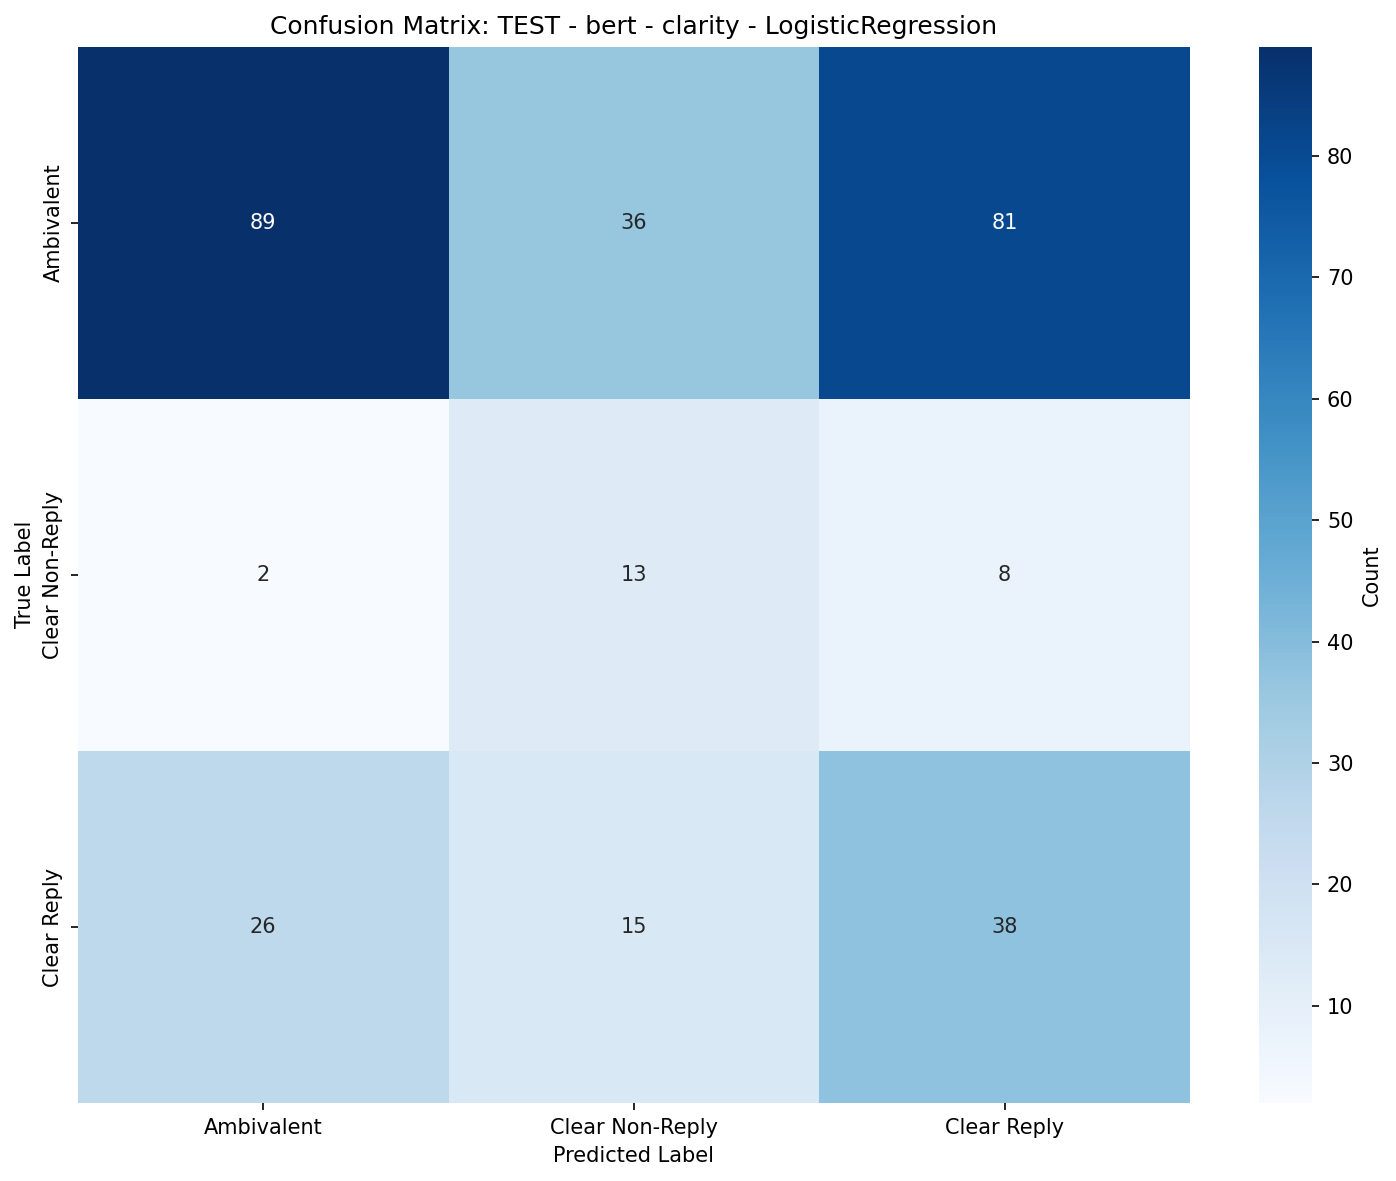


    Training LinearSVC...

Classification Report: TEST - bert - clarity - LinearSVC
                 precision    recall  f1-score   support

     Ambivalent     0.7246    0.8301    0.7738       206
Clear Non-Reply     0.2400    0.2609    0.2500        23
    Clear Reply     0.4255    0.2532    0.3175        79

       accuracy                         0.6396       308
      macro avg     0.4634    0.4480    0.4471       308
   weighted avg     0.6117    0.6396    0.6176       308




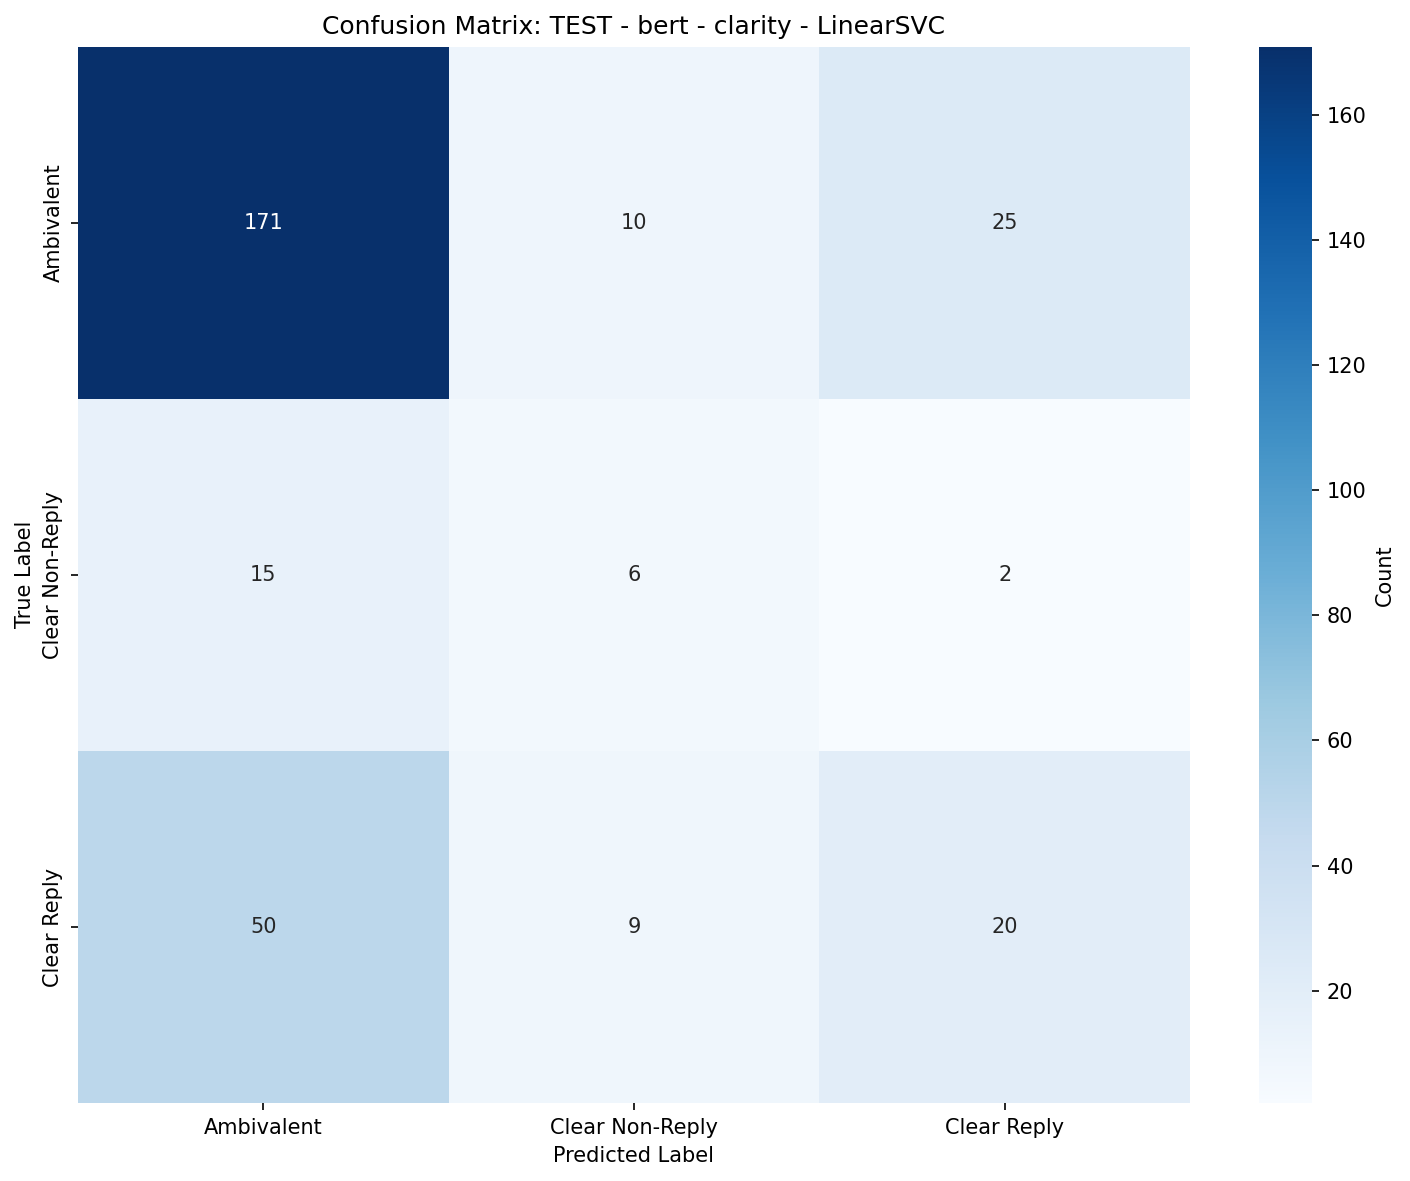


    Training RandomForest...

Classification Report: TEST - bert - clarity - RandomForest
                 precision    recall  f1-score   support

     Ambivalent     0.7085    0.9320    0.8050       206
Clear Non-Reply     0.6667    0.2609    0.3750        23
    Clear Reply     0.5000    0.1772    0.2617        79

       accuracy                         0.6883       308
      macro avg     0.6251    0.4567    0.4806       308
   weighted avg     0.6519    0.6883    0.6336       308




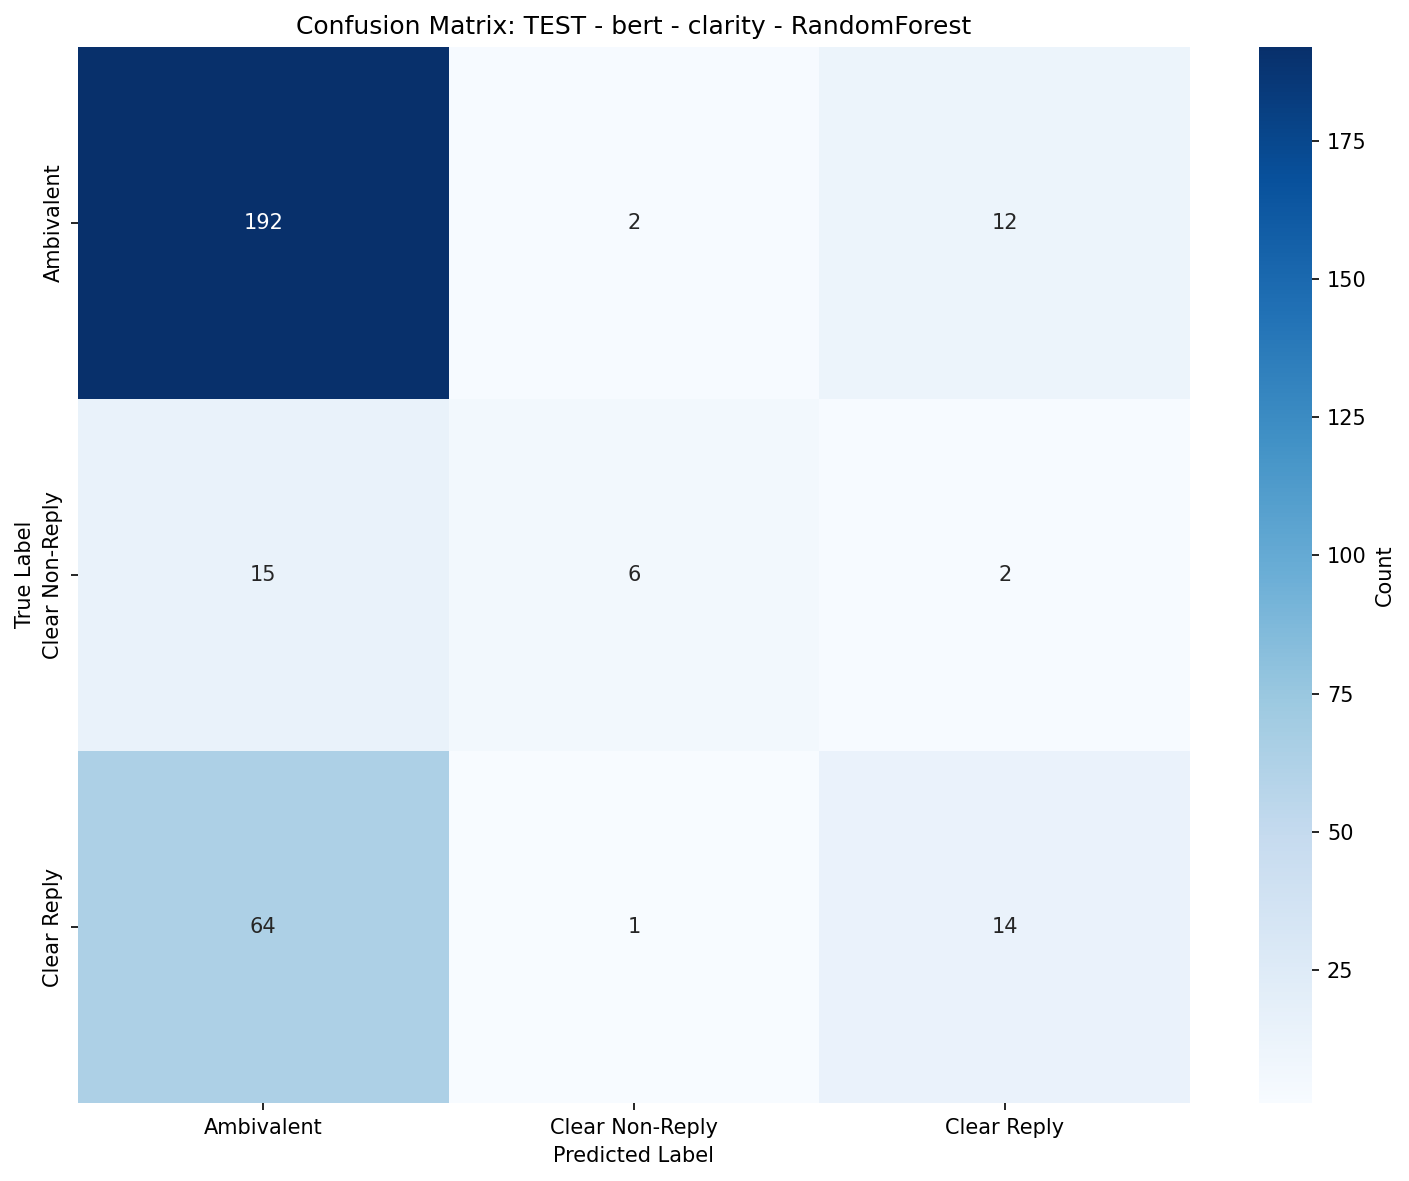


    Training MLP...

Classification Report: TEST - bert - clarity - MLP
                 precision    recall  f1-score   support

     Ambivalent     0.6858    0.9854    0.8088       206
Clear Non-Reply     0.7500    0.1304    0.2222        23
    Clear Reply     0.6250    0.0633    0.1149        79

       accuracy                         0.6851       308
      macro avg     0.6869    0.3931    0.3820       308
   weighted avg     0.6750    0.6851    0.5870       308




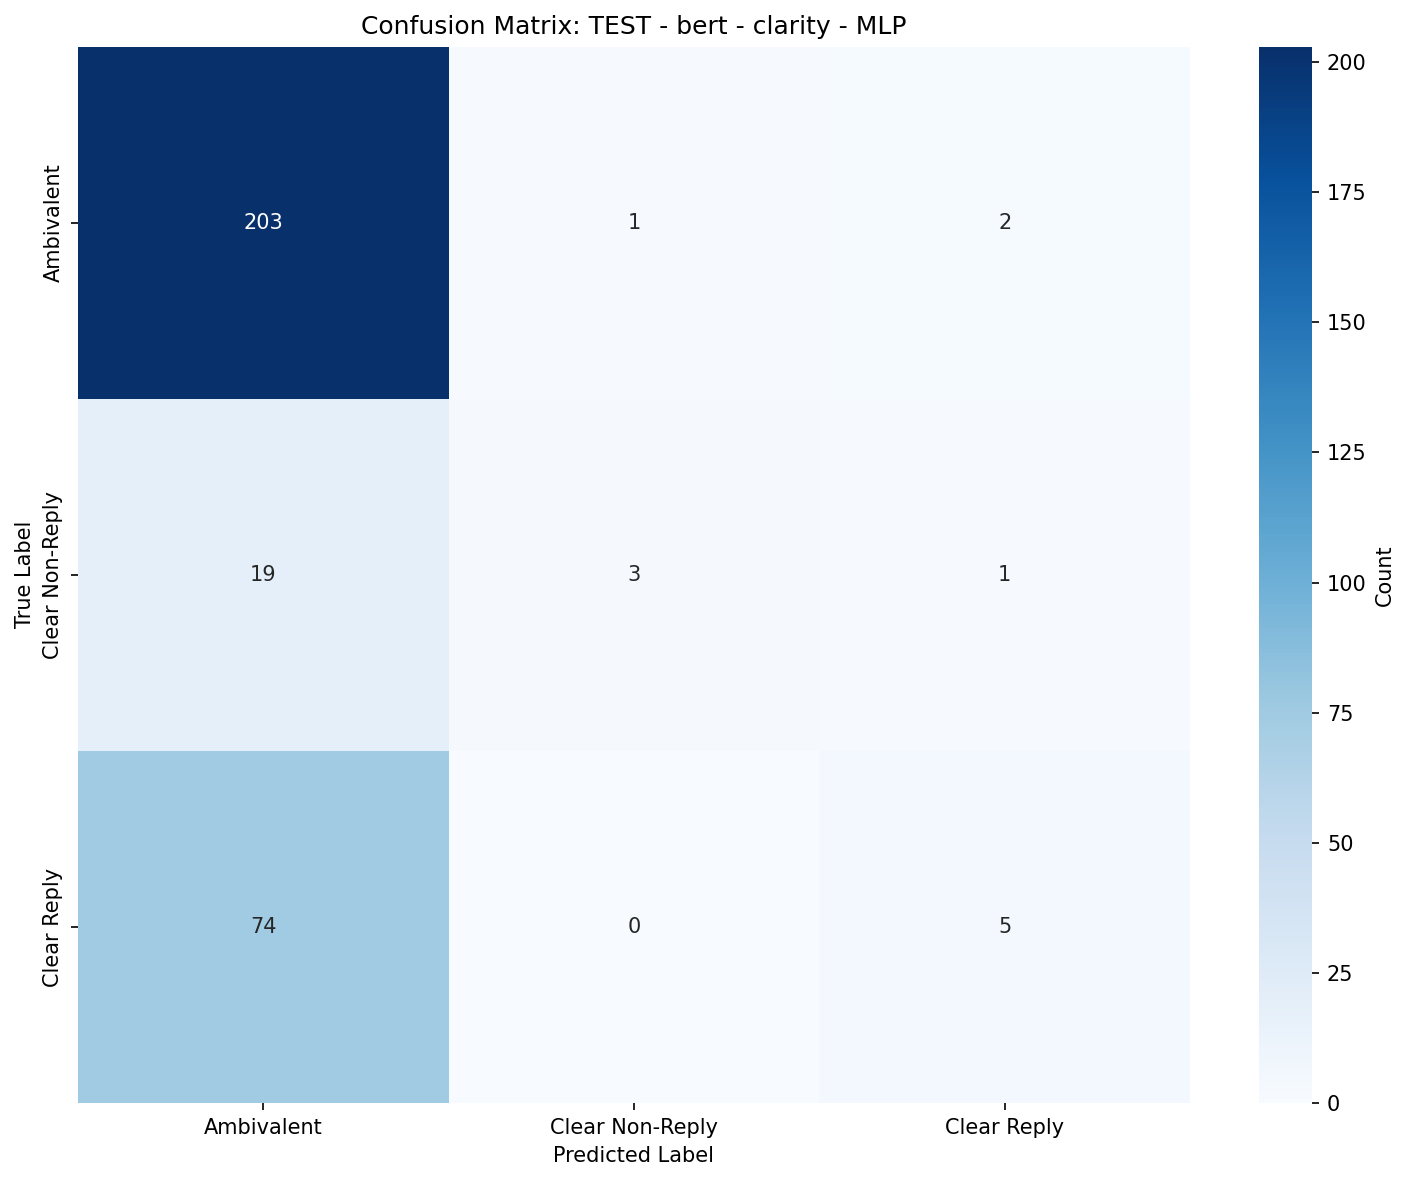


    Training XGBoost...

Classification Report: TEST - bert - clarity - XGBoost
                 precision    recall  f1-score   support

     Ambivalent     0.7108    0.8592    0.7780       206
Clear Non-Reply     0.6667    0.2609    0.3750        23
    Clear Reply     0.4200    0.2658    0.3256        79

       accuracy                         0.6623       308
      macro avg     0.5992    0.4620    0.4929       308
   weighted avg     0.6329    0.6623    0.6319       308




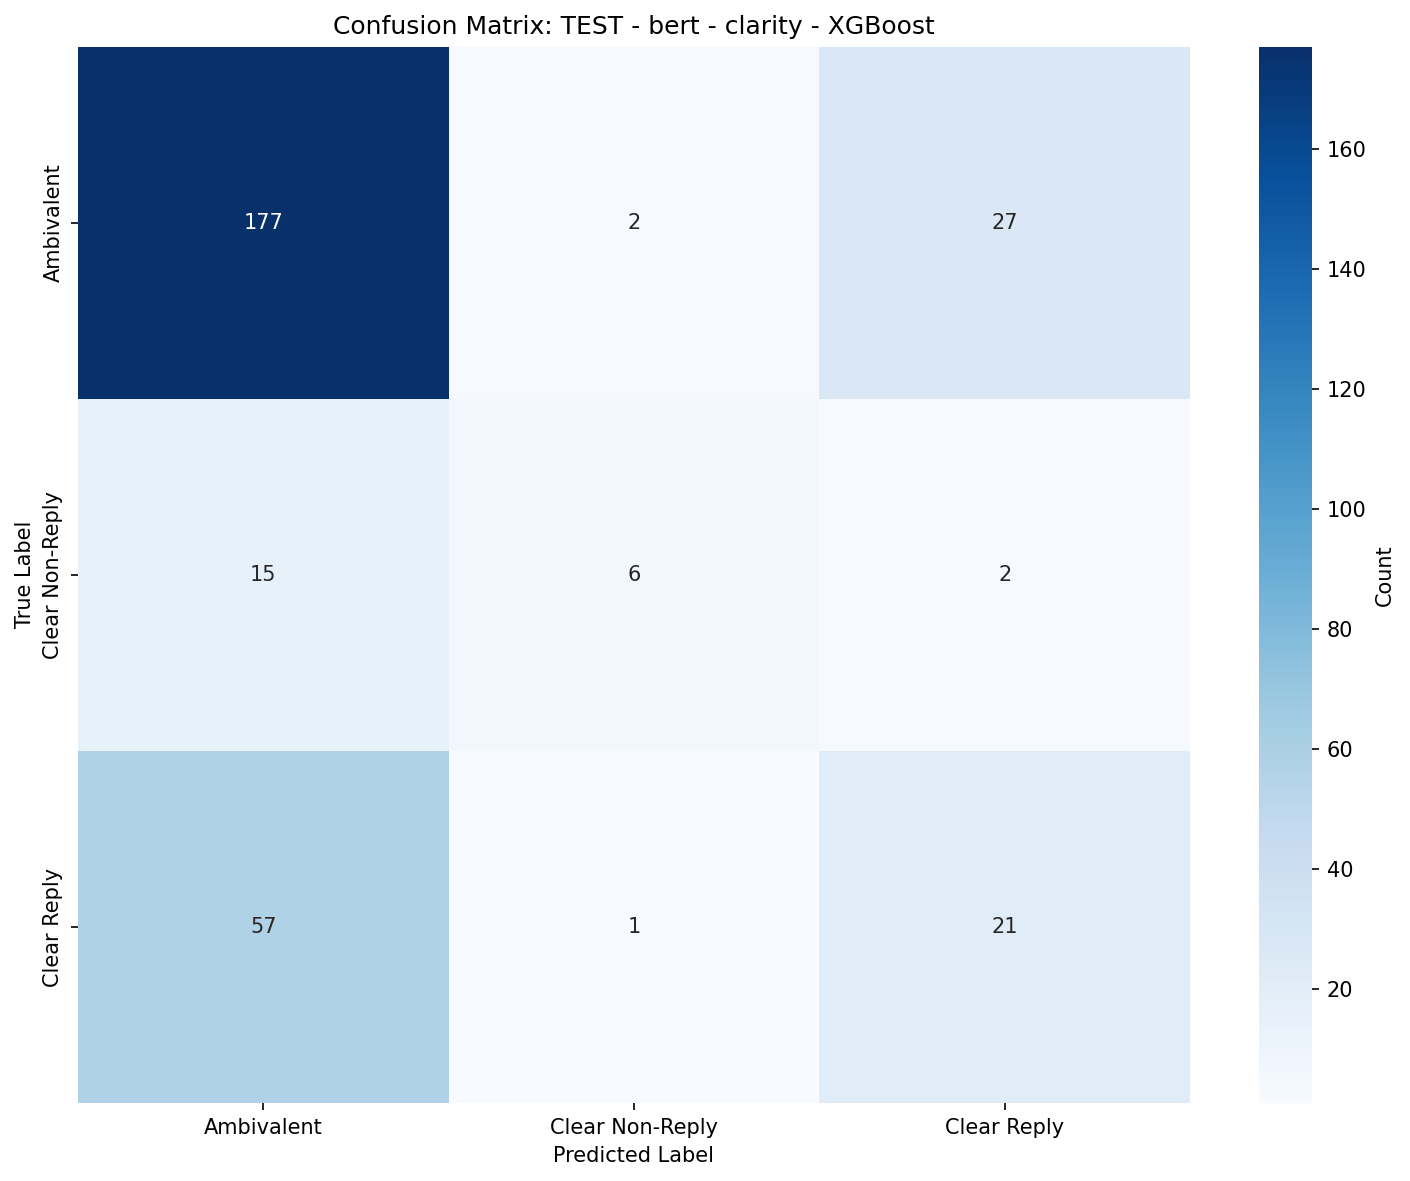


    Training LightGBM...

Classification Report: TEST - bert - clarity - LightGBM
                 precision    recall  f1-score   support

     Ambivalent     0.7104    0.8932    0.7914       206
Clear Non-Reply     0.6250    0.2174    0.3226        23
    Clear Reply     0.4390    0.2278    0.3000        79

       accuracy                         0.6721       308
      macro avg     0.5915    0.4461    0.4713       308
   weighted avg     0.6344    0.6721    0.6303       308




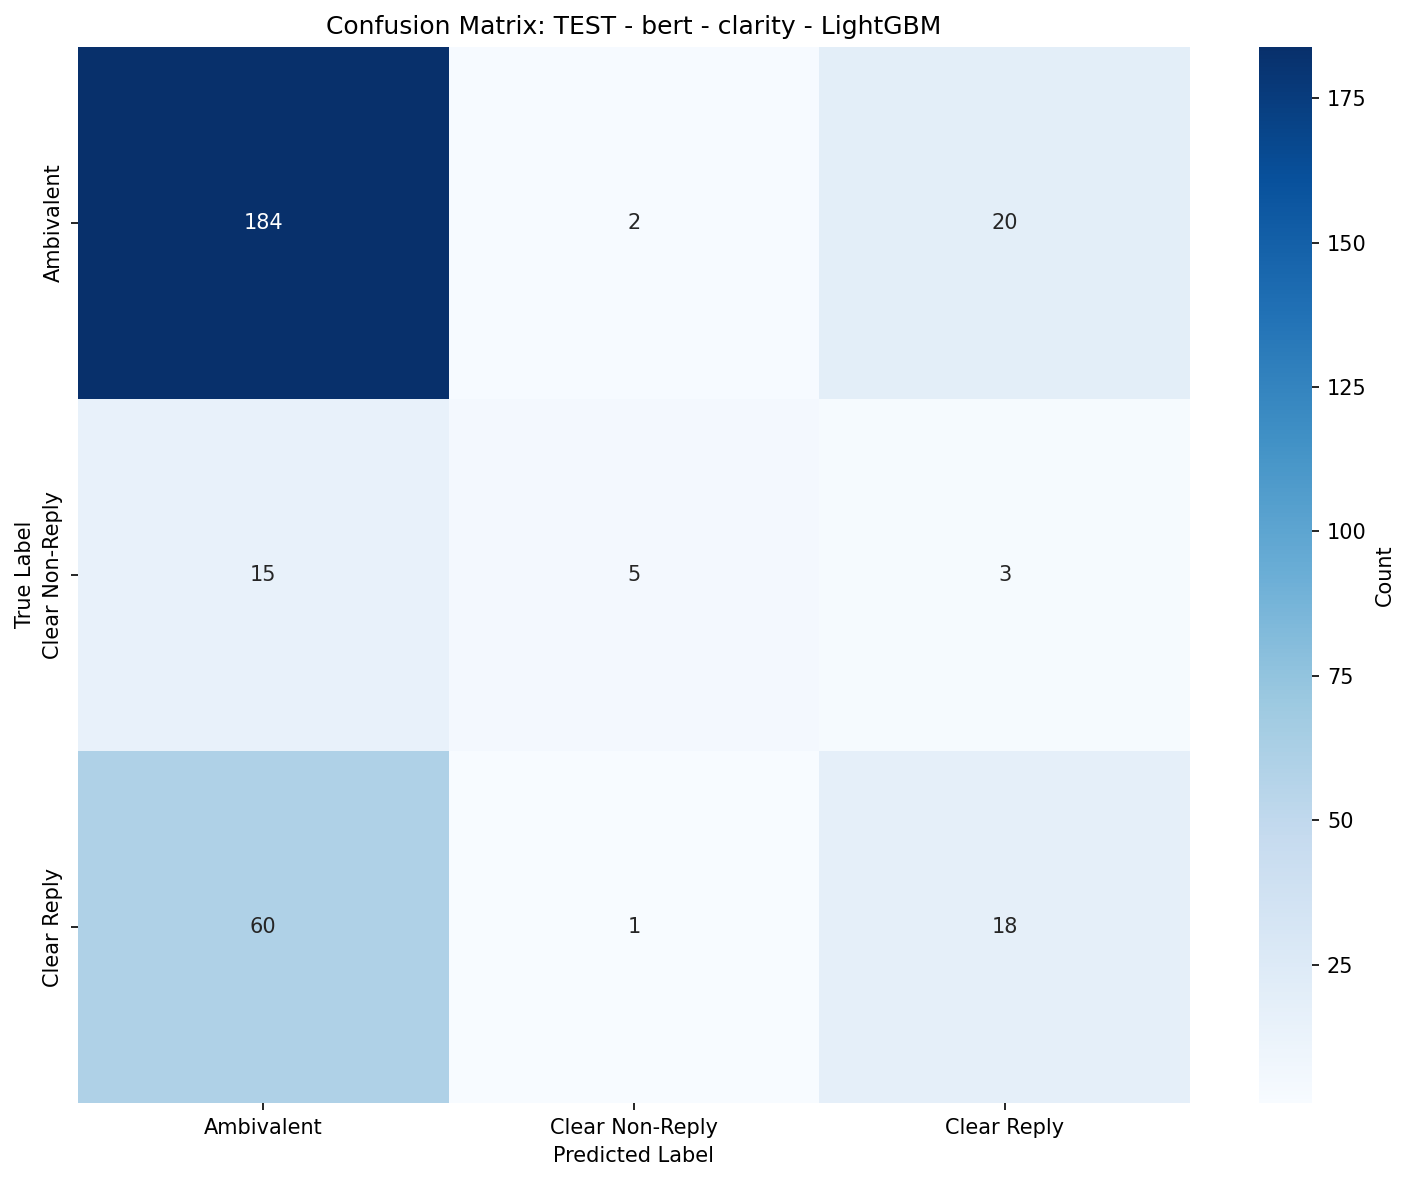


Results Table: TEST - bert - clarity
        Classifier                  Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
           XGBoost TEST - bert - clarity  0.662338  0.492868     0.631878         0.599170      0.461972
      RandomForest TEST - bert - clarity  0.688312  0.480571     0.633553         0.625051      0.456708
          LightGBM TEST - bert - clarity  0.672078  0.471326     0.630348         0.591483      0.446148
         LinearSVC TEST - bert - clarity  0.639610  0.447072     0.617607         0.463369      0.448044
LogisticRegression TEST - bert - clarity  0.454545  0.406289     0.485527         0.421007      0.492756
               MLP TEST - bert - clarity  0.685065  0.381977     0.587004         0.686937      0.393054

Per-Class Metrics: TEST - bert - clarity - XGBoost (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent   0.710843 0.859223  0.778022      206
Clear Non-Reply   0.666667 0.260870  0.375000 

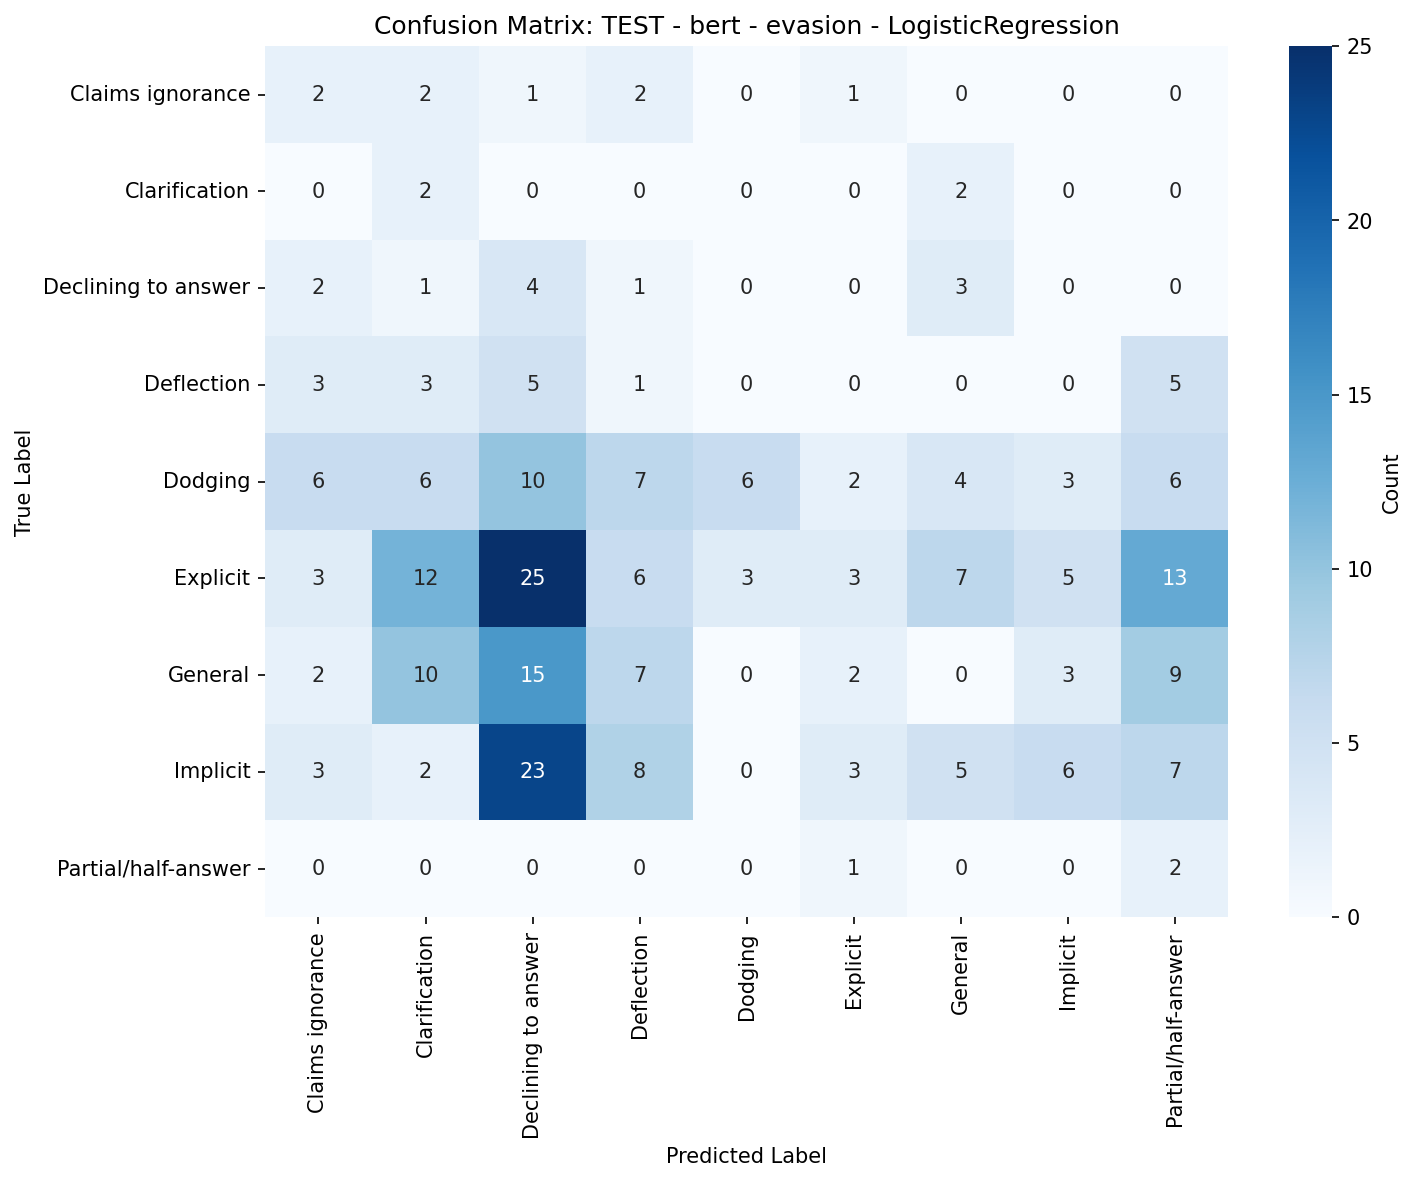


    Training LinearSVC...

Classification Report: TEST - bert - evasion - LinearSVC
                     precision    recall  f1-score   support

   Claims ignorance     0.1250    0.1250    0.1250         8
      Clarification     0.1538    0.5000    0.2353         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0769    0.0588    0.0667        17
            Dodging     0.1429    0.1000    0.1176        50
           Explicit     0.2733    0.5325    0.3612        77
            General     0.0909    0.0208    0.0339        48
           Implicit     0.0000    0.0000    0.0000        57
Partial/half-answer     0.0357    0.3333    0.0645         3

           accuracy                         0.1891       275
          macro avg     0.0998    0.1856    0.1116       275
       weighted avg     0.1294    0.1891    0.1403       275




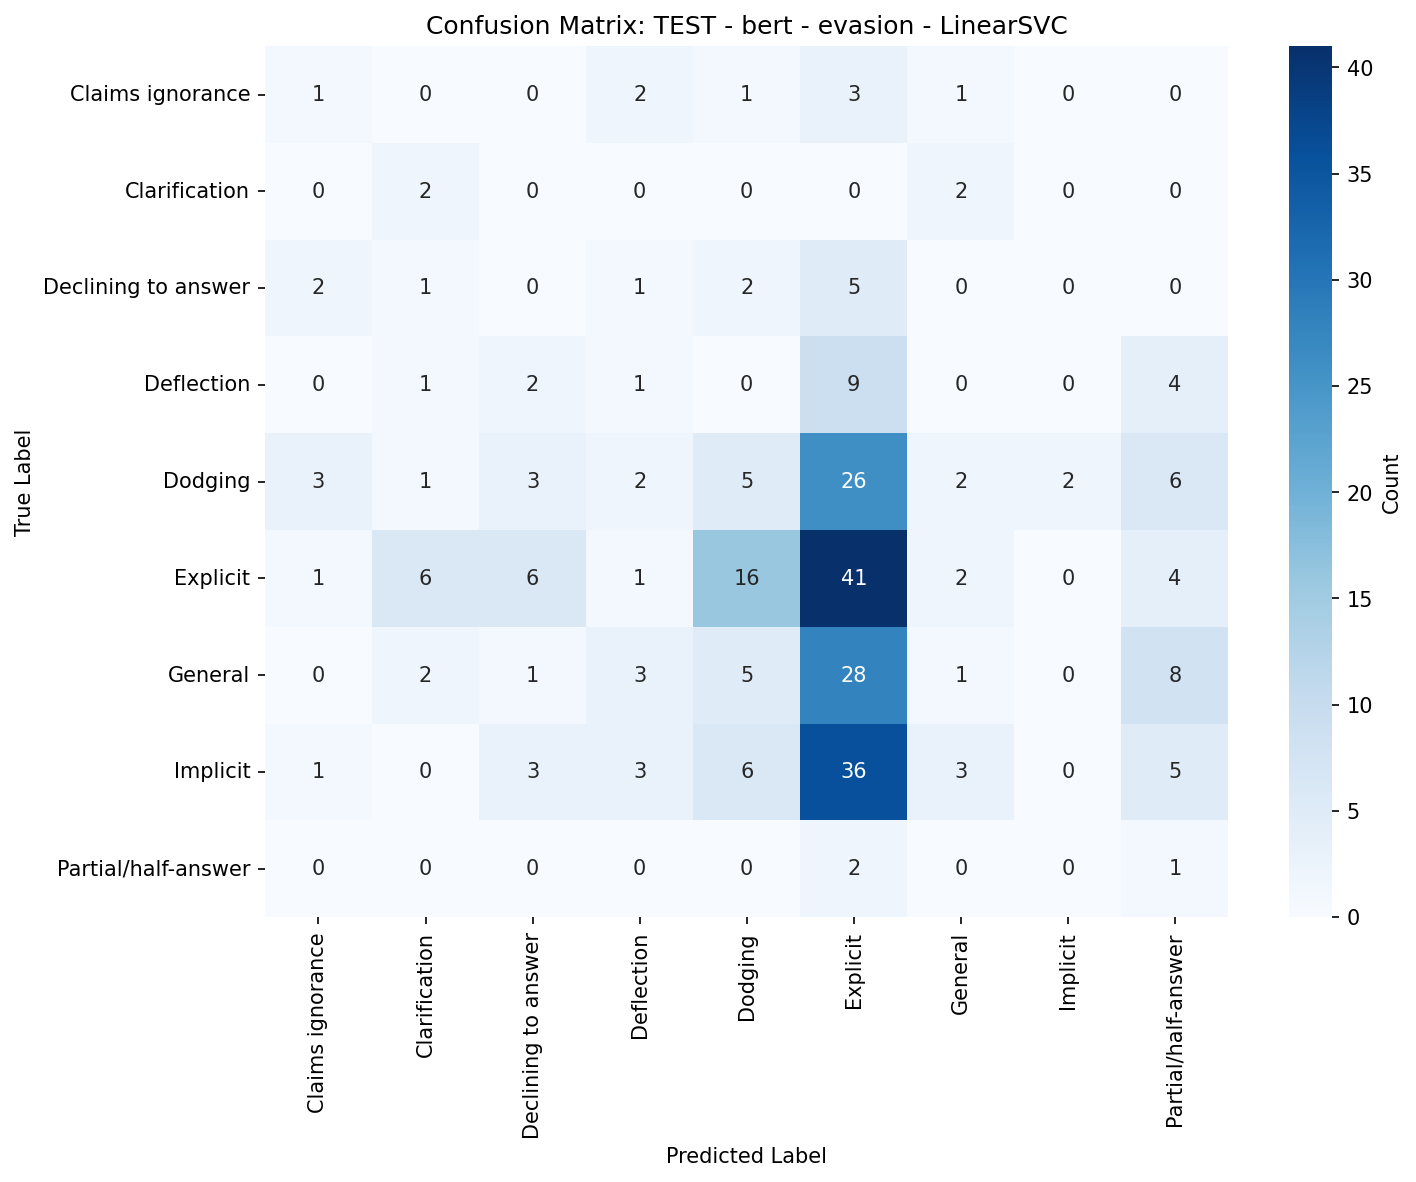


    Training RandomForest...

Classification Report: TEST - bert - evasion - RandomForest
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.5000    0.2500    0.3333         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.2308    0.1765    0.2000        17
            Dodging     0.2093    0.1800    0.1935        50
           Explicit     0.2950    0.7662    0.4260        77
            General     0.2500    0.0208    0.0385        48
           Implicit     0.2308    0.0526    0.0857        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2764       275
          macro avg     0.1906    0.1607    0.1419       275
       weighted avg     0.2337    0.2764    0.1962       275




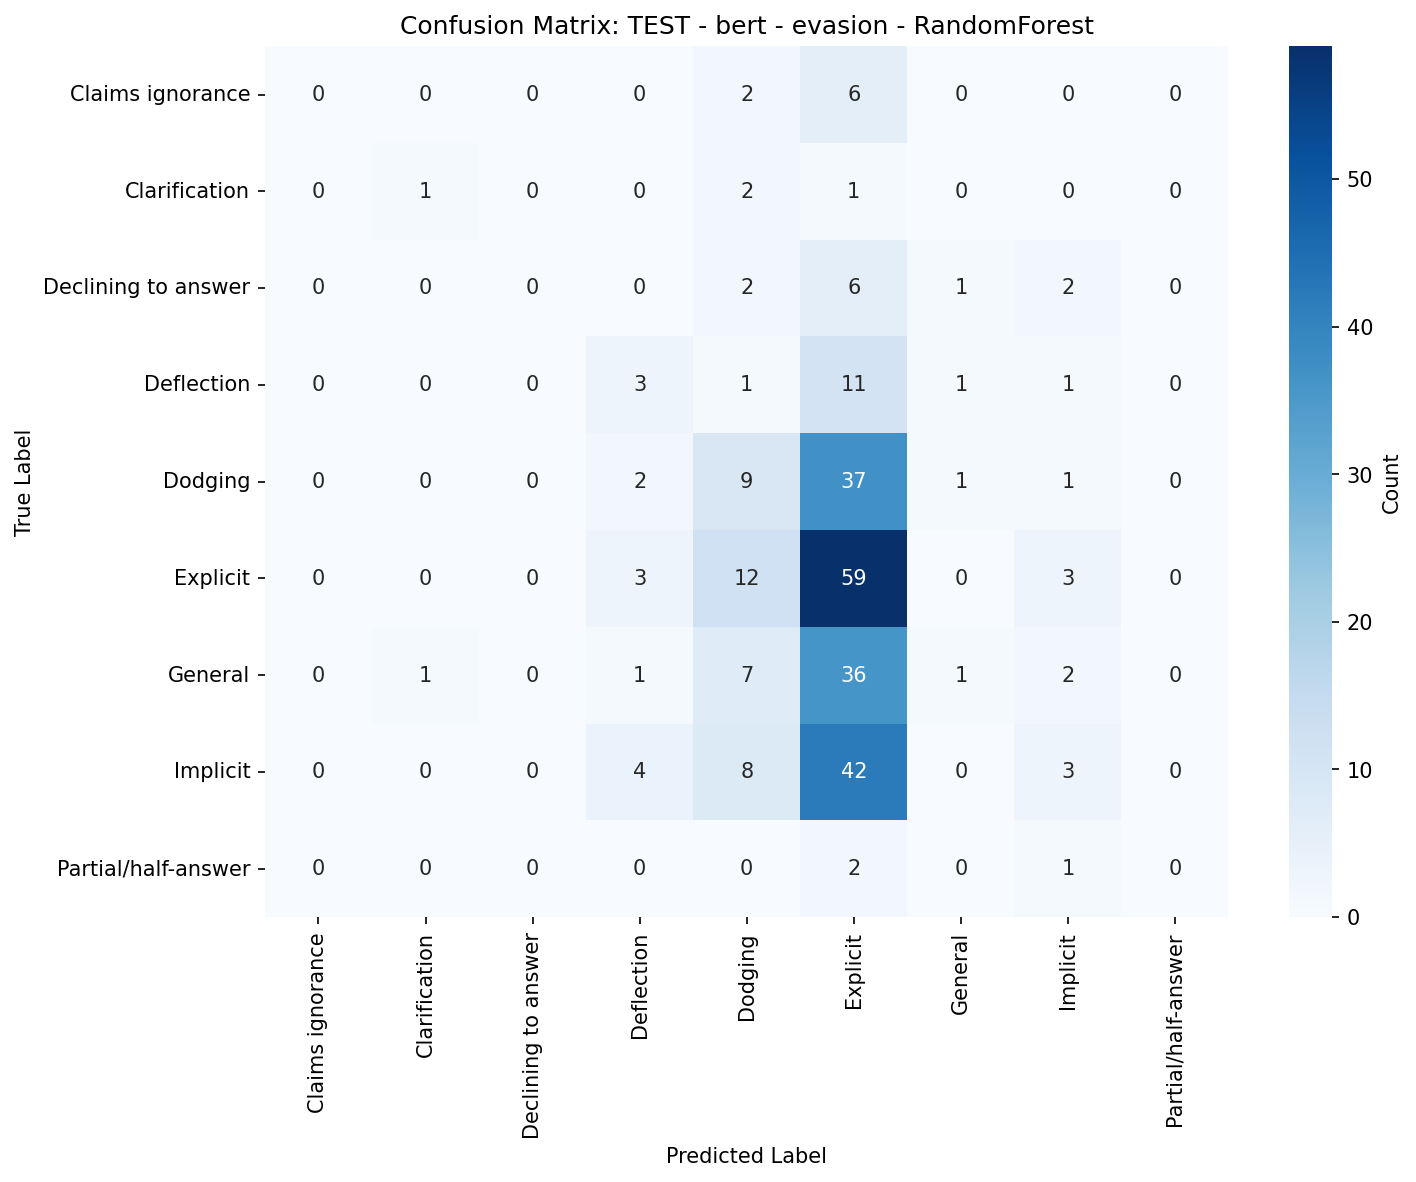


    Training MLP...

Classification Report: TEST - bert - evasion - MLP
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0000    0.0000    0.0000        17
            Dodging     0.7500    0.0600    0.1111        50
           Explicit     0.2804    0.9870    0.4368        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.0000    0.0000    0.0000        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2873       275
          macro avg     0.1145    0.1163    0.0609       275
       weighted avg     0.2149    0.2873    0.1425       275




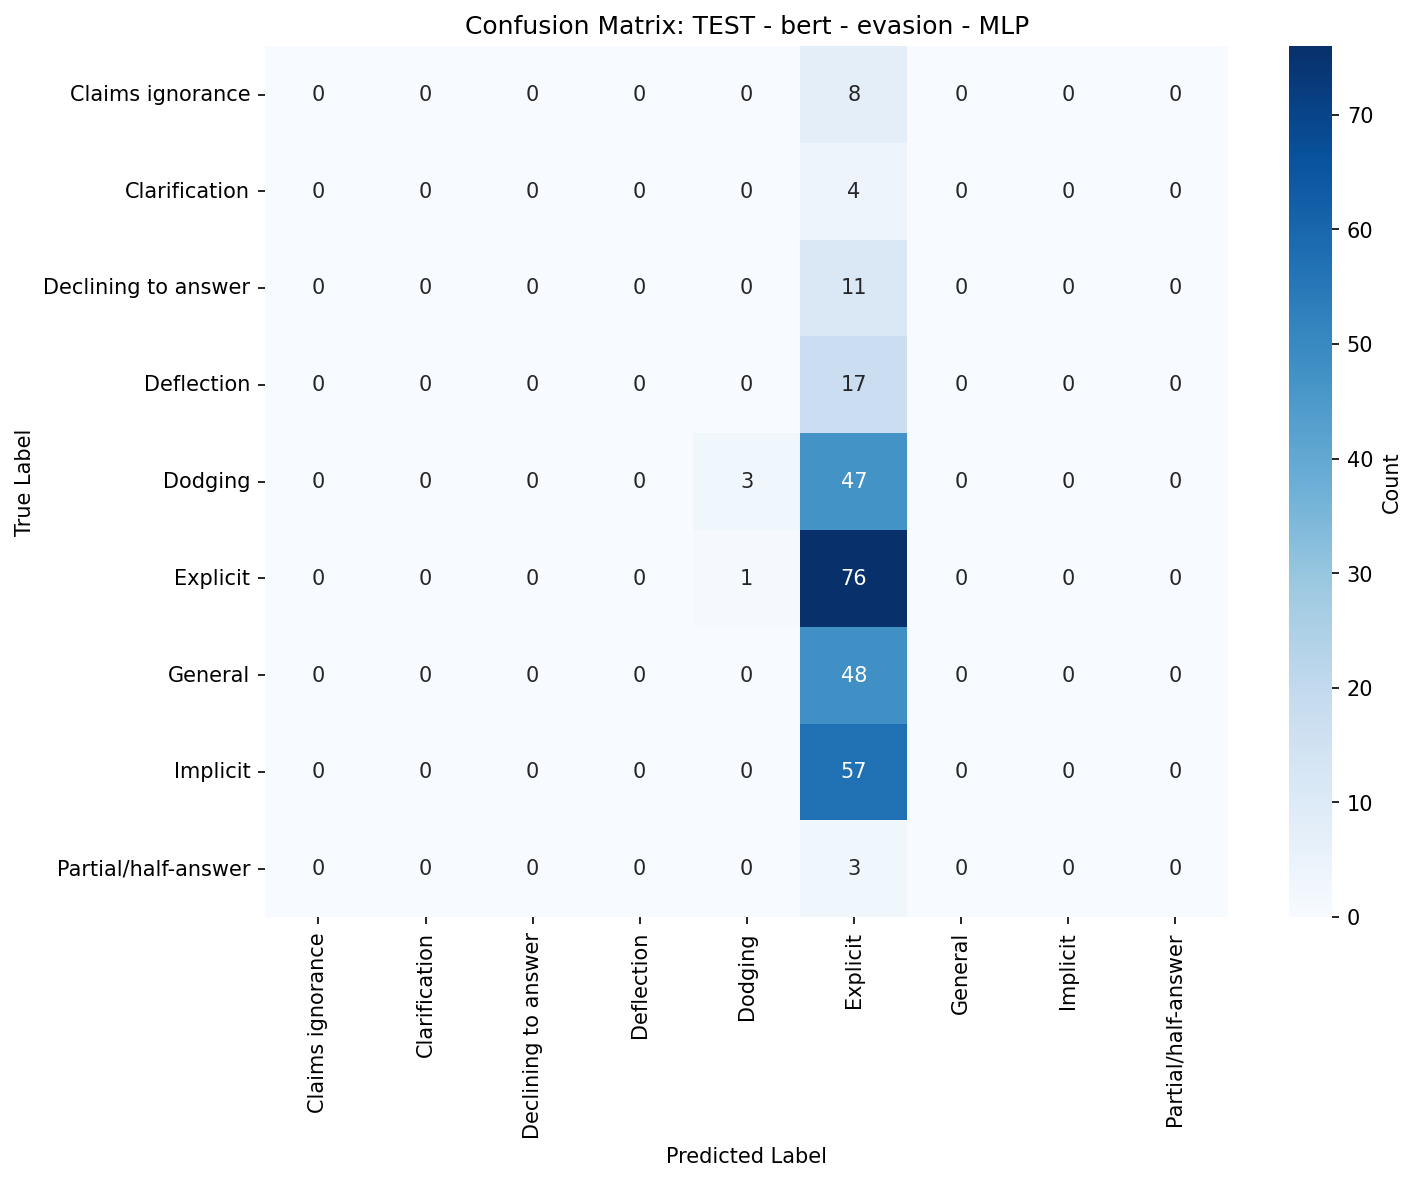


    Training XGBoost...

Classification Report: TEST - bert - evasion - XGBoost
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0000    0.0000    0.0000        17
            Dodging     0.2292    0.2200    0.2245        50
           Explicit     0.2947    0.7273    0.4195        77
            General     0.2500    0.0625    0.1000        48
           Implicit     0.1818    0.0351    0.0588        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2618       275
          macro avg     0.1062    0.1161    0.0892       275
       weighted avg     0.2055    0.2618    0.1879       275




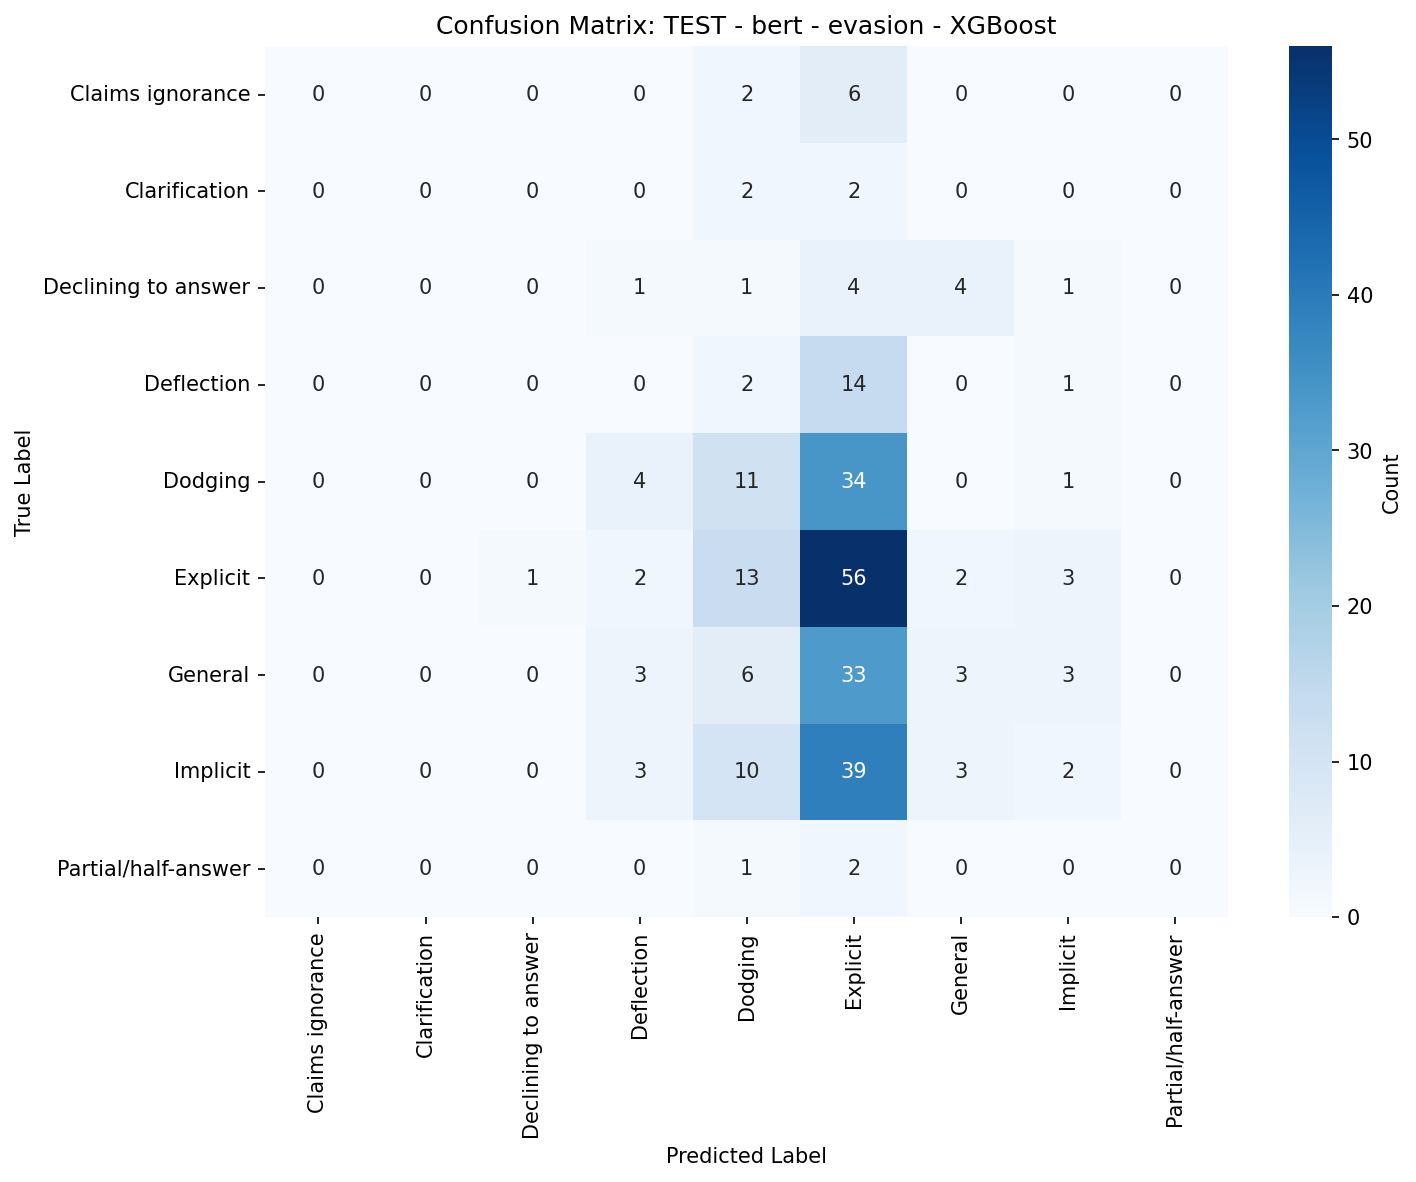


    Training LightGBM...

Classification Report: TEST - bert - evasion - LightGBM
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0909    0.0588    0.0714        17
            Dodging     0.2951    0.3600    0.3243        50
           Explicit     0.2944    0.6883    0.4125        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.2500    0.0702    0.1096        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2764       275
          macro avg     0.1034    0.1308    0.1020       275
       weighted avg     0.1935    0.2764    0.2016       275




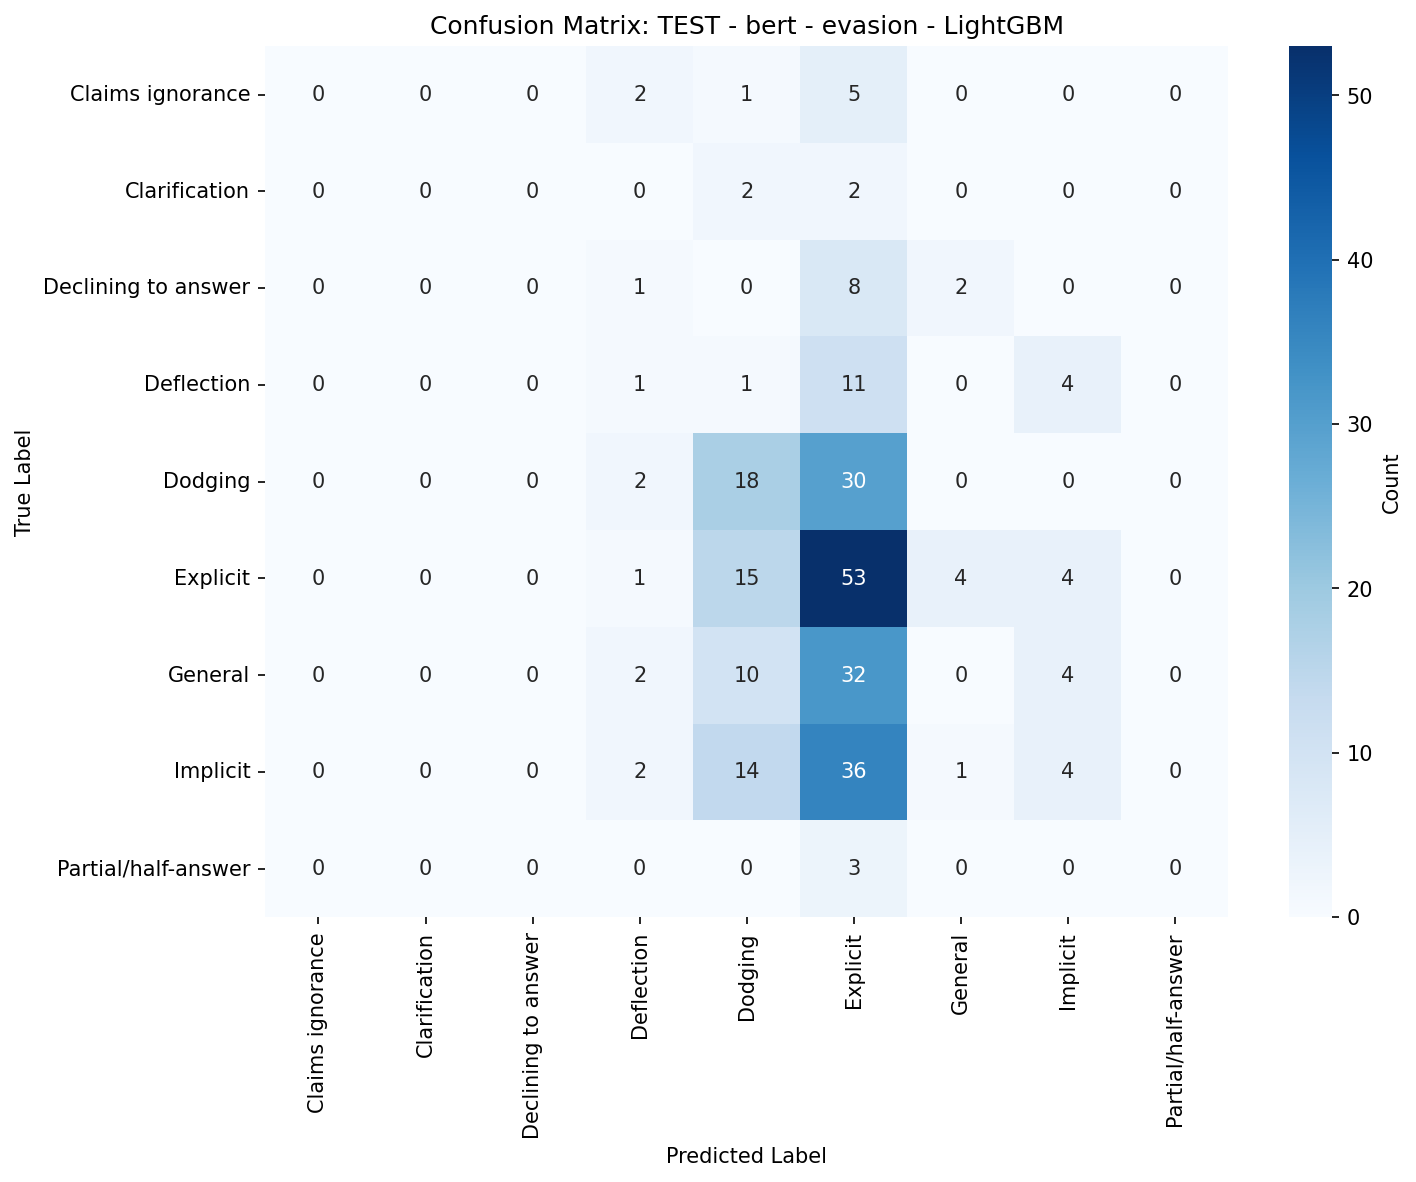


Results Table: TEST - bert - evasion
        Classifier                  Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest TEST - bert - evasion  0.276364  0.141894     0.196160         0.190649      0.160685
         LinearSVC TEST - bert - evasion  0.189091  0.111584     0.140336         0.099843      0.185606
          LightGBM TEST - bert - evasion  0.276364  0.101977     0.201585         0.103382      0.130812
LogisticRegression TEST - bert - evasion  0.094545  0.097883     0.101763         0.171615      0.233706
           XGBoost TEST - bert - evasion  0.261818  0.089199     0.187917         0.106191      0.116096
               MLP TEST - bert - evasion  0.287273  0.060877     0.142501         0.114494      0.116335

Per-Class Metrics: TEST - bert - evasion - RandomForest (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.000000 0.000000  0.000000        8
      Clarification   0.500000 0.

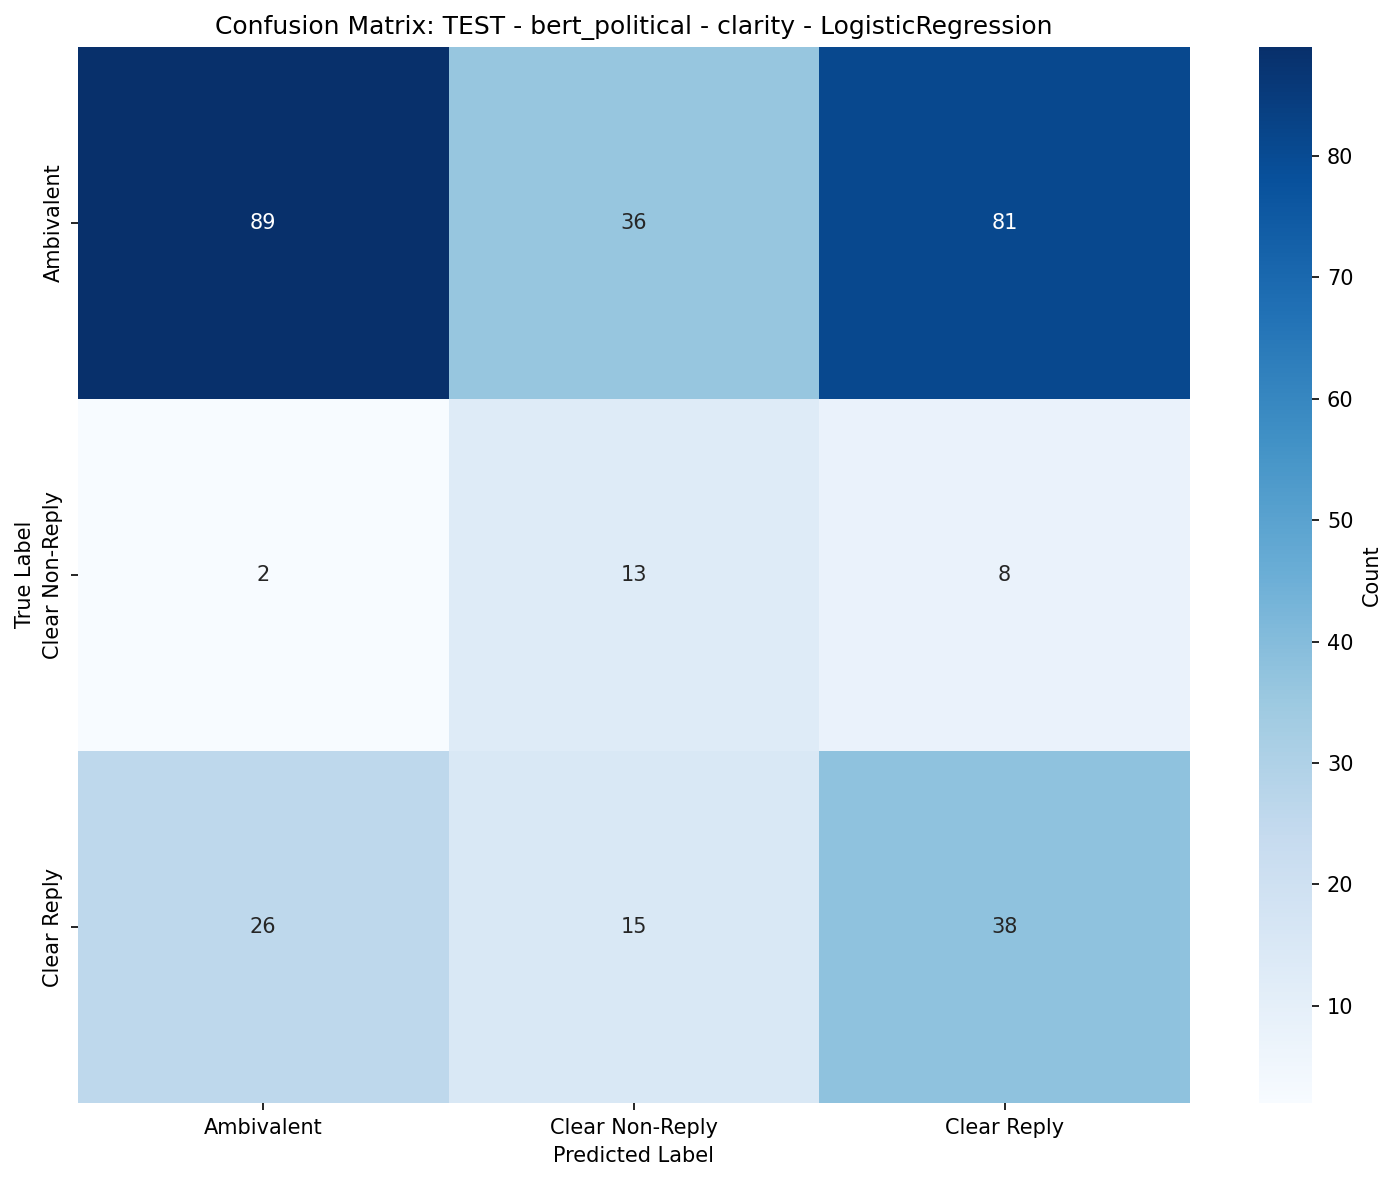


    Training LinearSVC...

Classification Report: TEST - bert_political - clarity - LinearSVC
                 precision    recall  f1-score   support

     Ambivalent     0.7246    0.8301    0.7738       206
Clear Non-Reply     0.2400    0.2609    0.2500        23
    Clear Reply     0.4255    0.2532    0.3175        79

       accuracy                         0.6396       308
      macro avg     0.4634    0.4480    0.4471       308
   weighted avg     0.6117    0.6396    0.6176       308




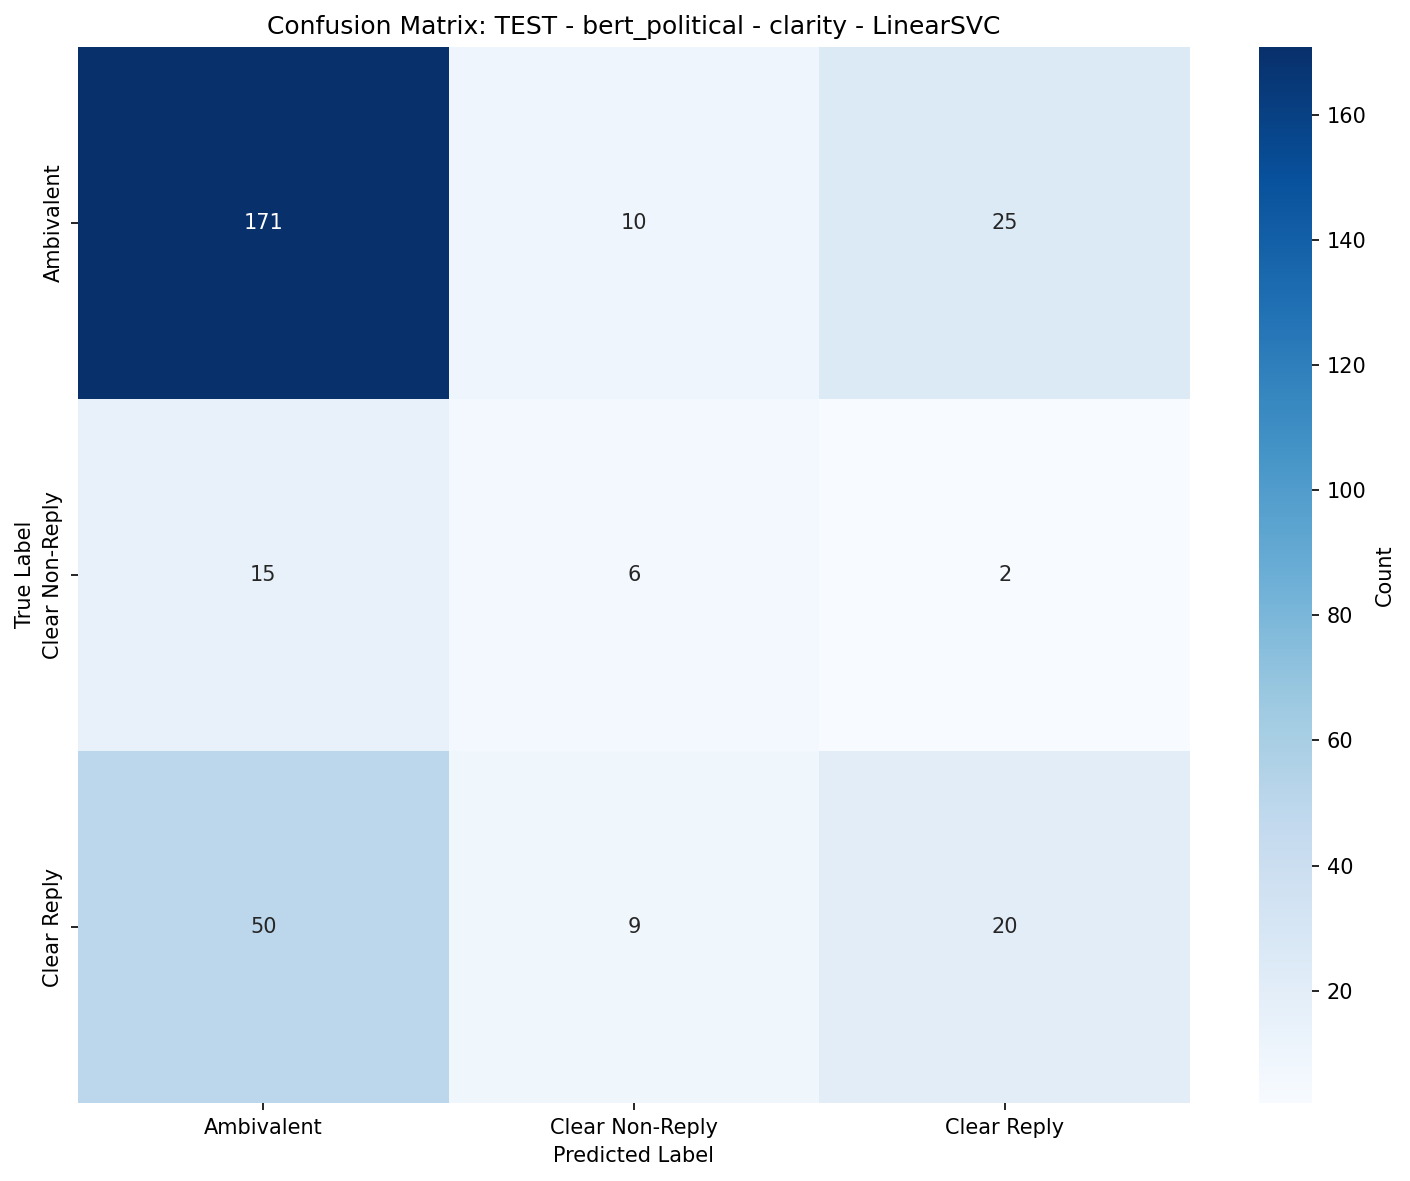


    Training RandomForest...

Classification Report: TEST - bert_political - clarity - RandomForest
                 precision    recall  f1-score   support

     Ambivalent     0.7085    0.9320    0.8050       206
Clear Non-Reply     0.6667    0.2609    0.3750        23
    Clear Reply     0.5000    0.1772    0.2617        79

       accuracy                         0.6883       308
      macro avg     0.6251    0.4567    0.4806       308
   weighted avg     0.6519    0.6883    0.6336       308




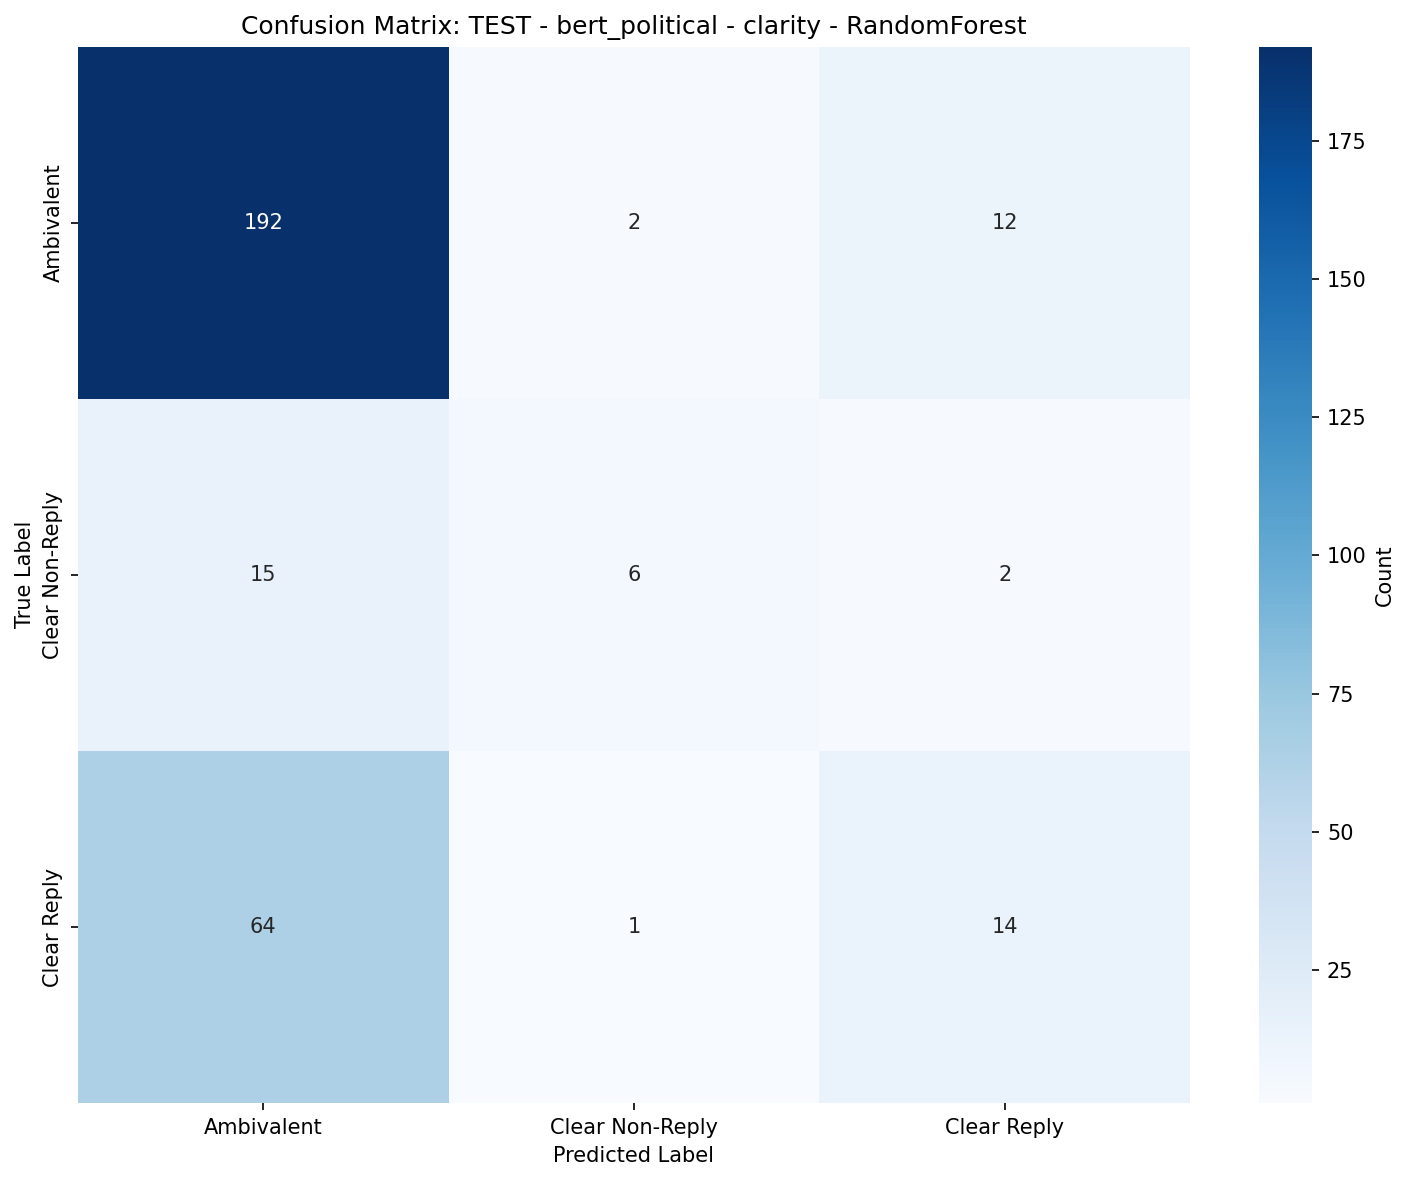


    Training MLP...

Classification Report: TEST - bert_political - clarity - MLP
                 precision    recall  f1-score   support

     Ambivalent     0.6858    0.9854    0.8088       206
Clear Non-Reply     0.7500    0.1304    0.2222        23
    Clear Reply     0.6250    0.0633    0.1149        79

       accuracy                         0.6851       308
      macro avg     0.6869    0.3931    0.3820       308
   weighted avg     0.6750    0.6851    0.5870       308




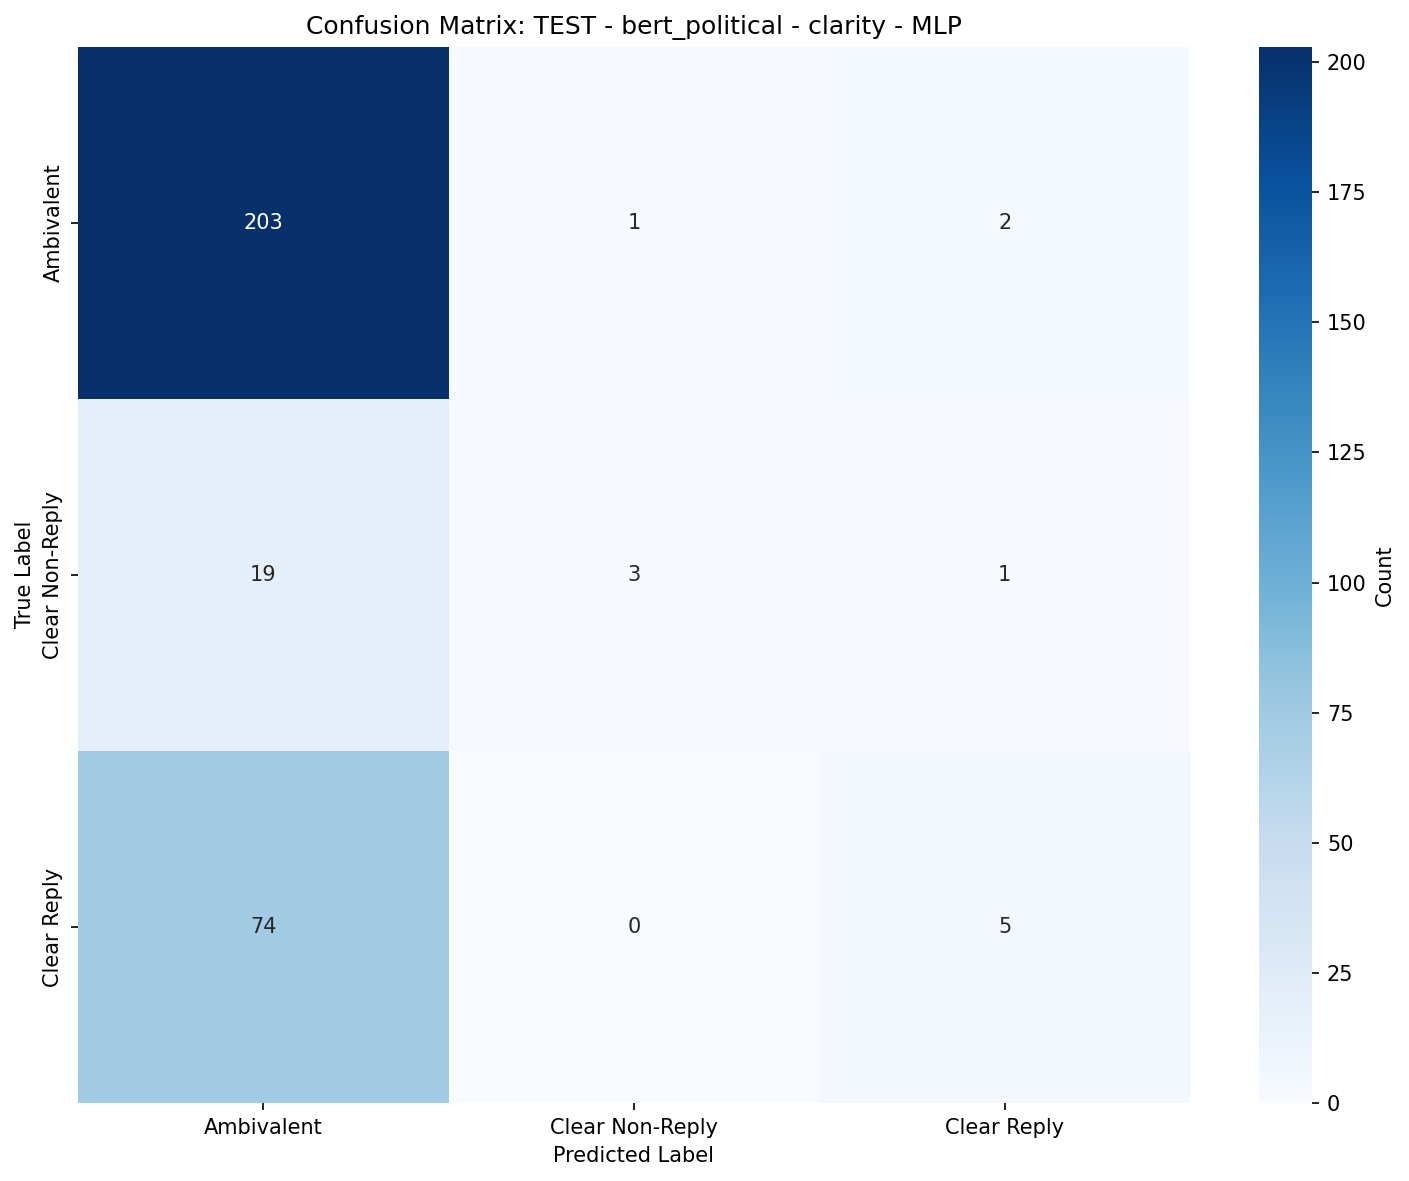


    Training XGBoost...

Classification Report: TEST - bert_political - clarity - XGBoost
                 precision    recall  f1-score   support

     Ambivalent     0.7108    0.8592    0.7780       206
Clear Non-Reply     0.6667    0.2609    0.3750        23
    Clear Reply     0.4200    0.2658    0.3256        79

       accuracy                         0.6623       308
      macro avg     0.5992    0.4620    0.4929       308
   weighted avg     0.6329    0.6623    0.6319       308




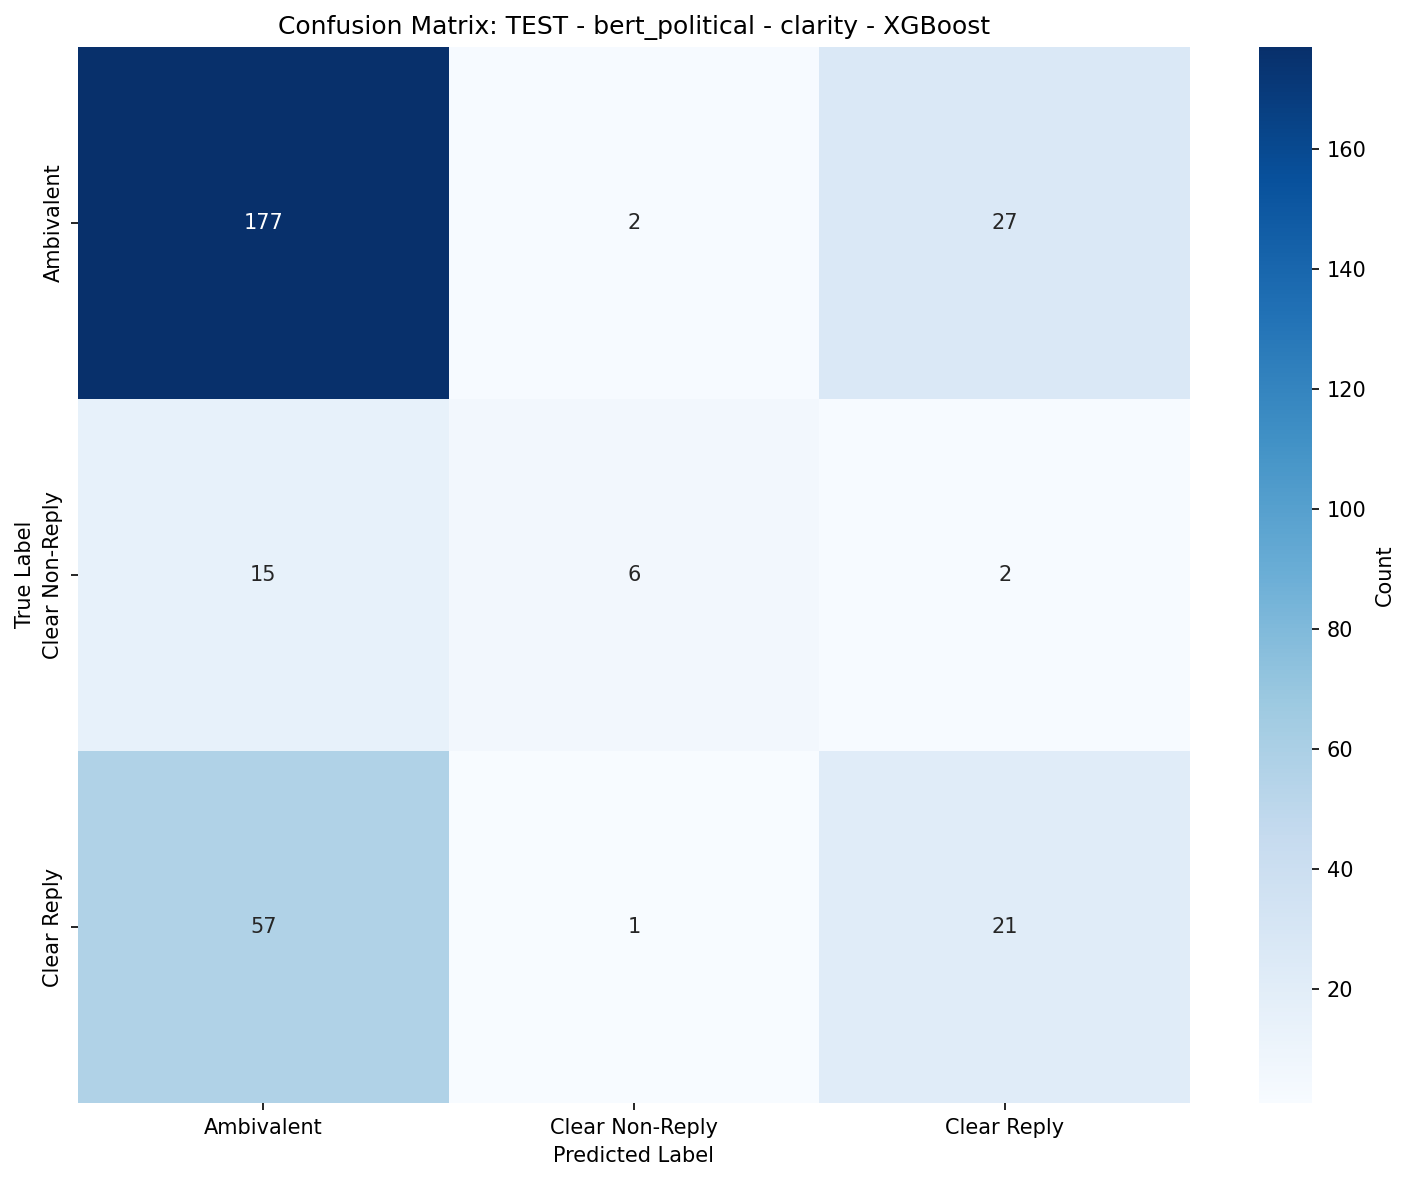


    Training LightGBM...

Classification Report: TEST - bert_political - clarity - LightGBM
                 precision    recall  f1-score   support

     Ambivalent     0.7104    0.8932    0.7914       206
Clear Non-Reply     0.6250    0.2174    0.3226        23
    Clear Reply     0.4390    0.2278    0.3000        79

       accuracy                         0.6721       308
      macro avg     0.5915    0.4461    0.4713       308
   weighted avg     0.6344    0.6721    0.6303       308




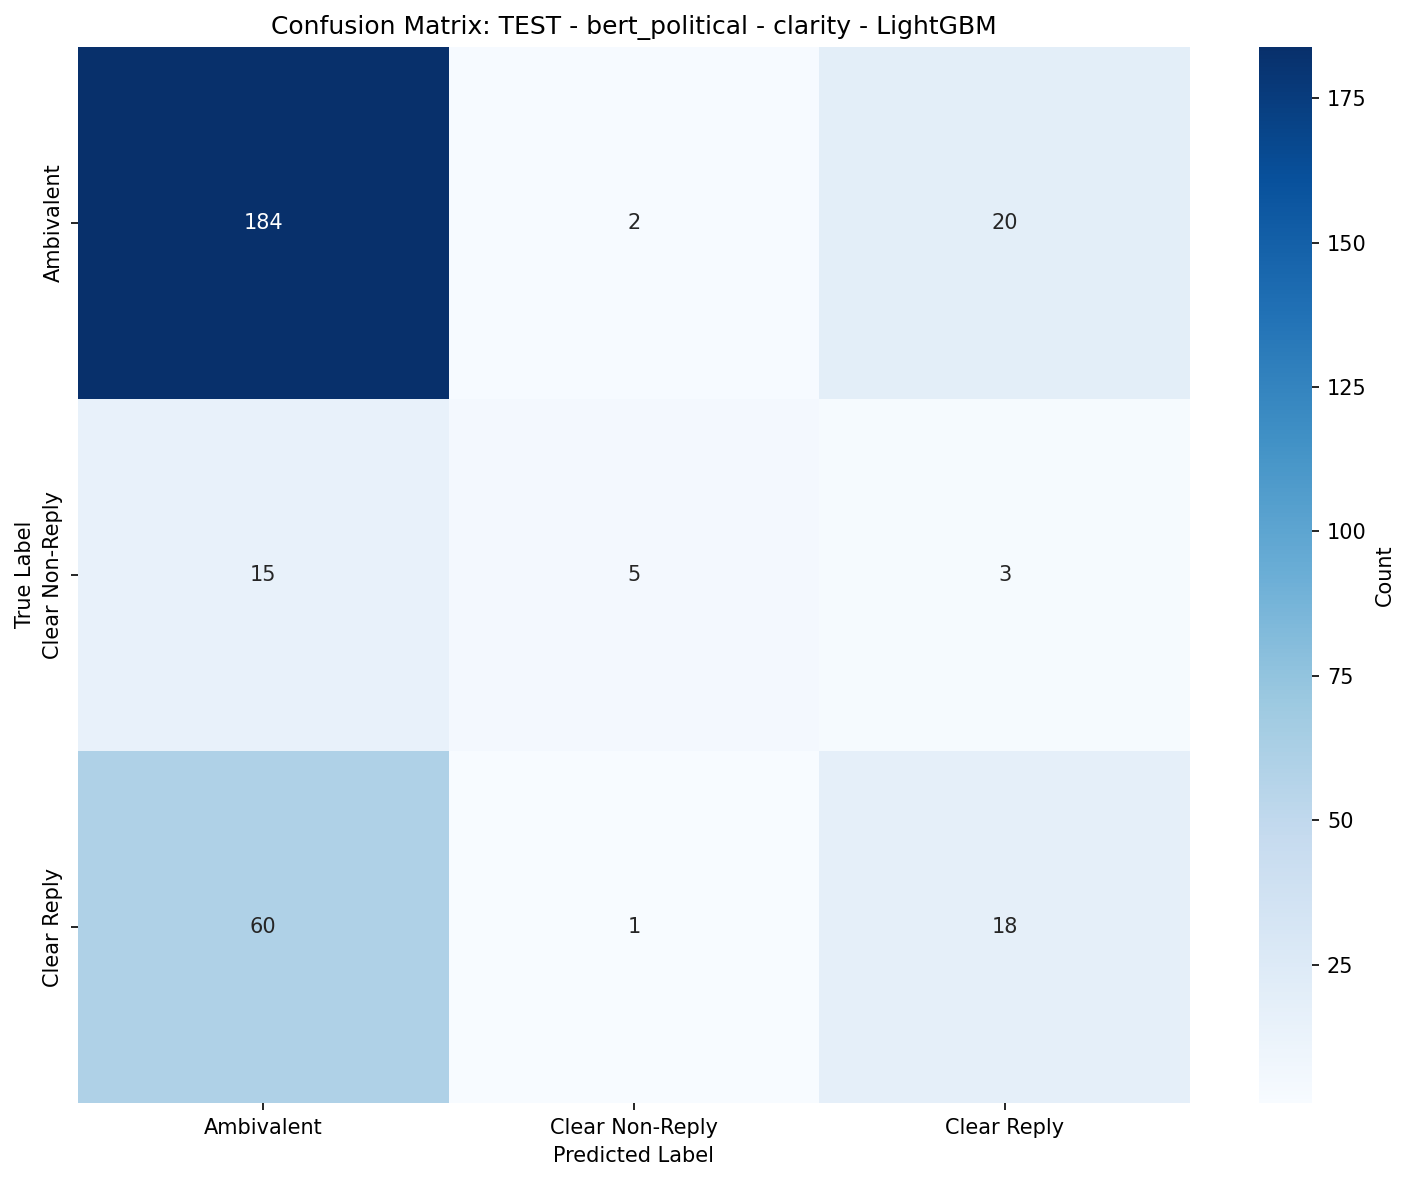


Results Table: TEST - bert_political - clarity
        Classifier                            Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
           XGBoost TEST - bert_political - clarity  0.662338  0.492868     0.631878         0.599170      0.461972
      RandomForest TEST - bert_political - clarity  0.688312  0.480571     0.633553         0.625051      0.456708
          LightGBM TEST - bert_political - clarity  0.672078  0.471326     0.630348         0.591483      0.446148
         LinearSVC TEST - bert_political - clarity  0.639610  0.447072     0.617607         0.463369      0.448044
LogisticRegression TEST - bert_political - clarity  0.454545  0.406289     0.485527         0.421007      0.492756
               MLP TEST - bert_political - clarity  0.685065  0.381977     0.587004         0.686937      0.393054

Per-Class Metrics: TEST - bert_political - clarity - XGBoost (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambiva

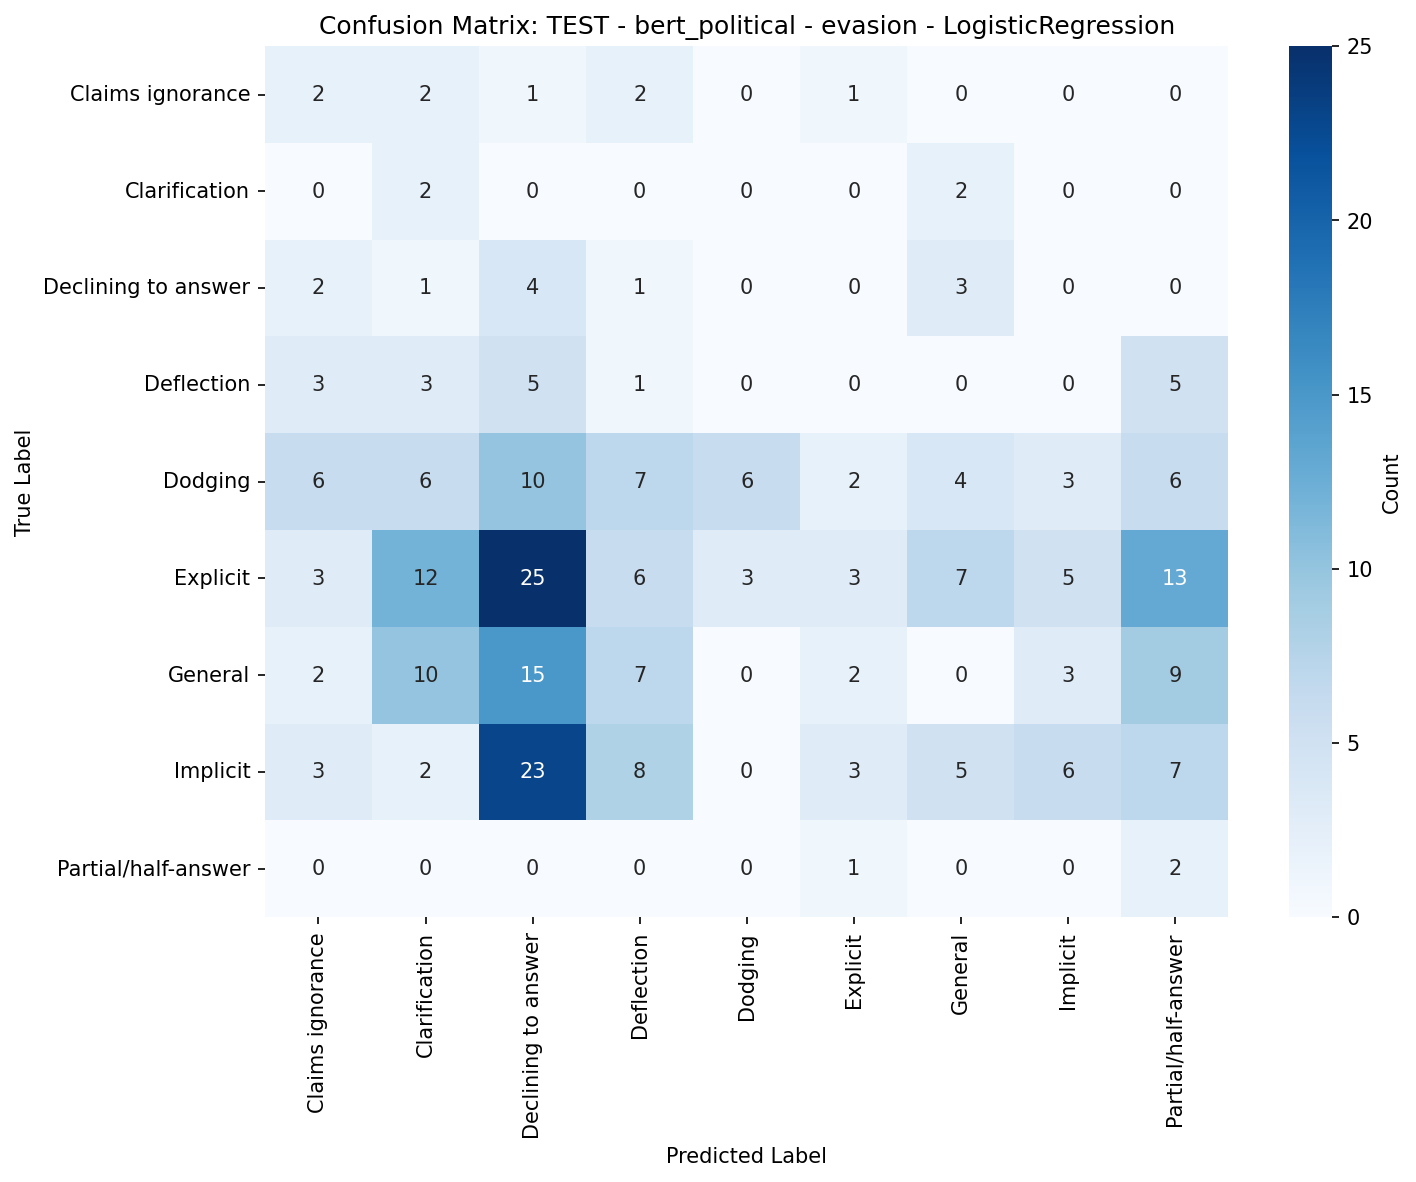


    Training LinearSVC...

Classification Report: TEST - bert_political - evasion - LinearSVC
                     precision    recall  f1-score   support

   Claims ignorance     0.1250    0.1250    0.1250         8
      Clarification     0.1538    0.5000    0.2353         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0769    0.0588    0.0667        17
            Dodging     0.1429    0.1000    0.1176        50
           Explicit     0.2733    0.5325    0.3612        77
            General     0.0909    0.0208    0.0339        48
           Implicit     0.0000    0.0000    0.0000        57
Partial/half-answer     0.0357    0.3333    0.0645         3

           accuracy                         0.1891       275
          macro avg     0.0998    0.1856    0.1116       275
       weighted avg     0.1294    0.1891    0.1403       275




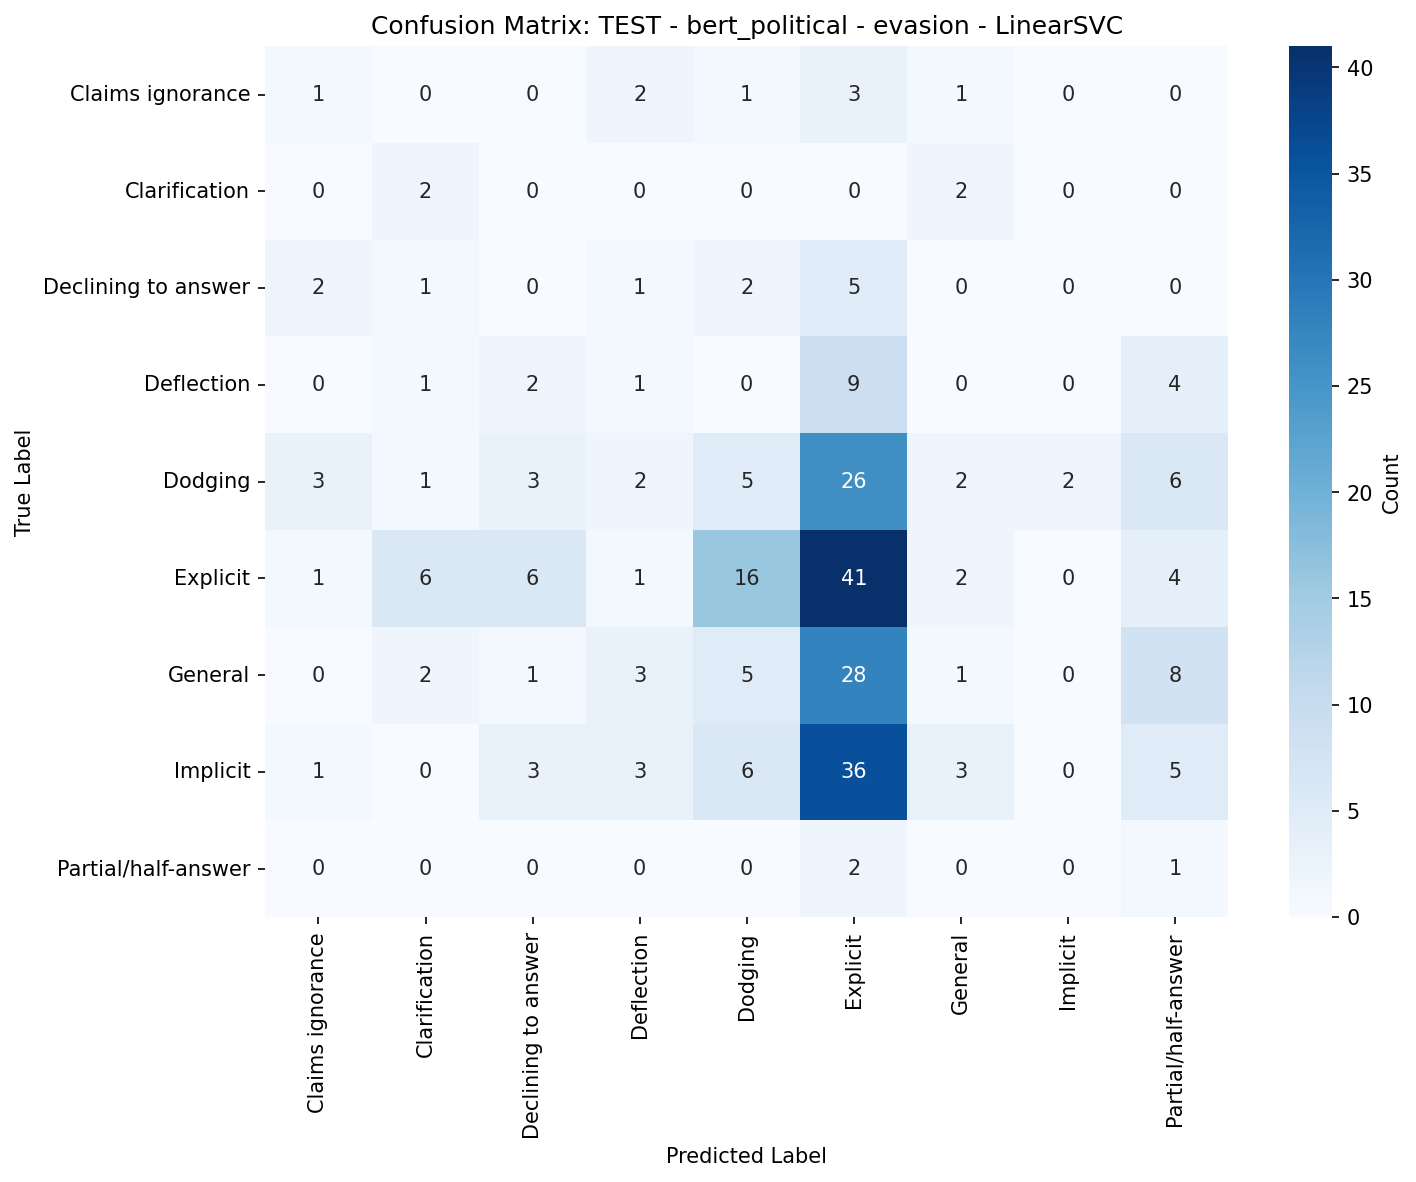


    Training RandomForest...

Classification Report: TEST - bert_political - evasion - RandomForest
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.5000    0.2500    0.3333         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.2308    0.1765    0.2000        17
            Dodging     0.2093    0.1800    0.1935        50
           Explicit     0.2950    0.7662    0.4260        77
            General     0.2500    0.0208    0.0385        48
           Implicit     0.2308    0.0526    0.0857        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2764       275
          macro avg     0.1906    0.1607    0.1419       275
       weighted avg     0.2337    0.2764    0.1962       275




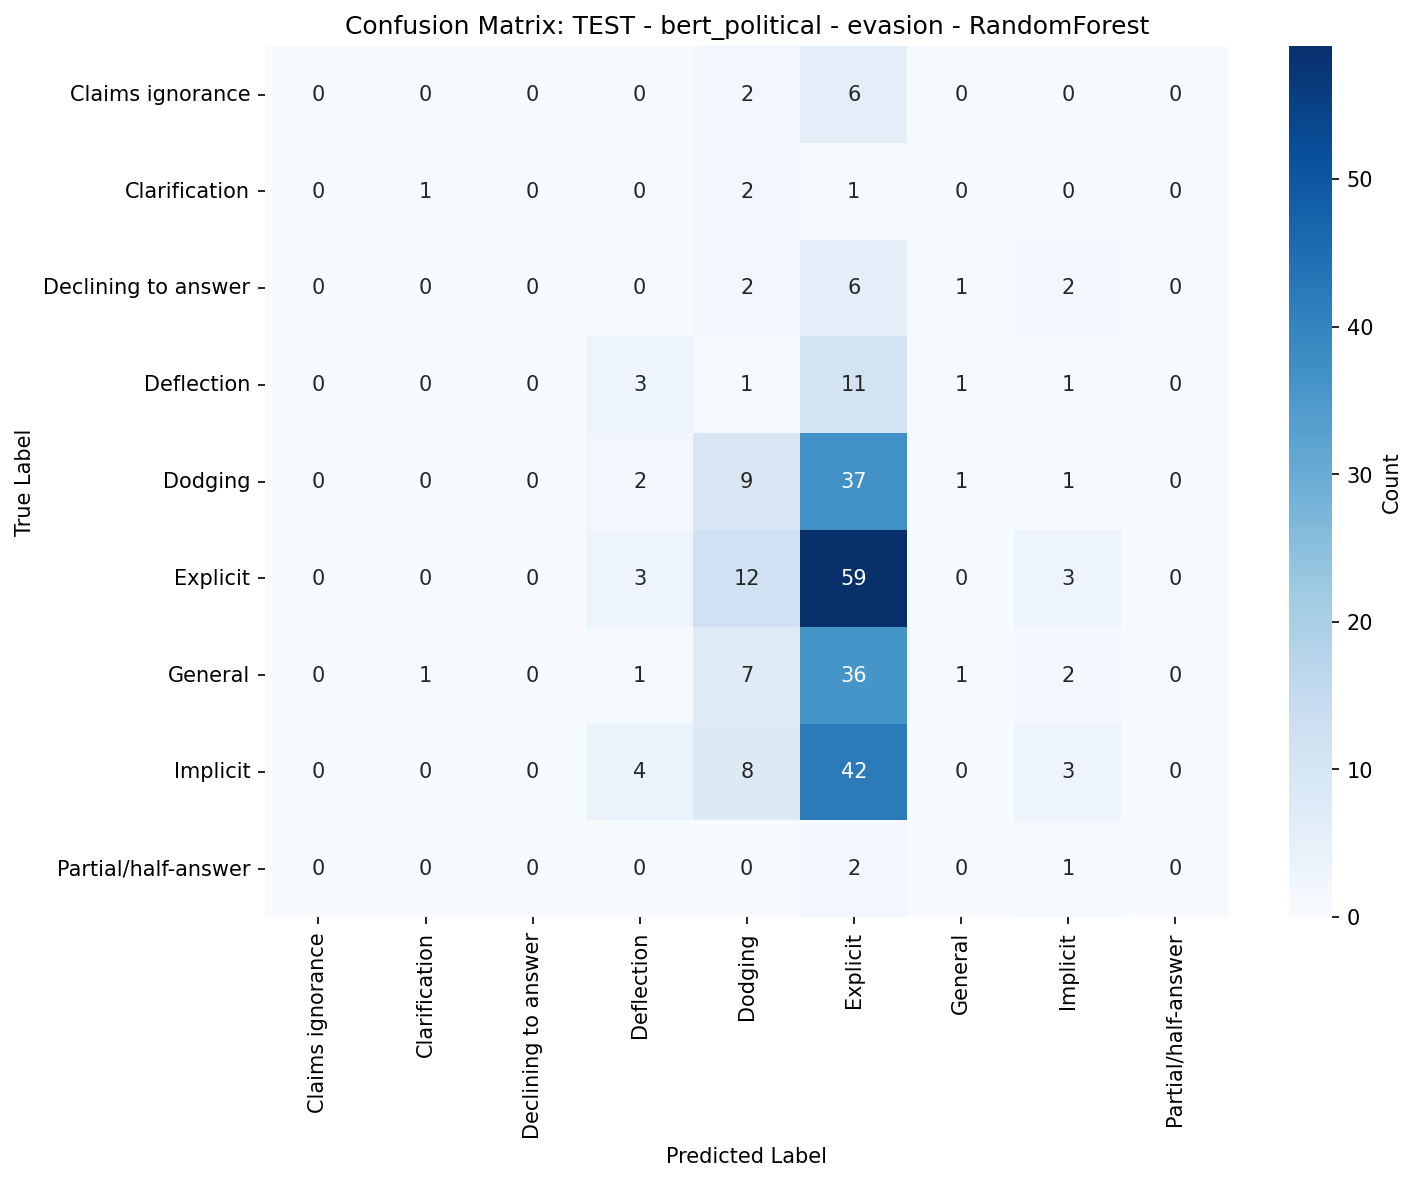


    Training MLP...

Classification Report: TEST - bert_political - evasion - MLP
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0000    0.0000    0.0000        17
            Dodging     0.7500    0.0600    0.1111        50
           Explicit     0.2804    0.9870    0.4368        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.0000    0.0000    0.0000        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2873       275
          macro avg     0.1145    0.1163    0.0609       275
       weighted avg     0.2149    0.2873    0.1425       275




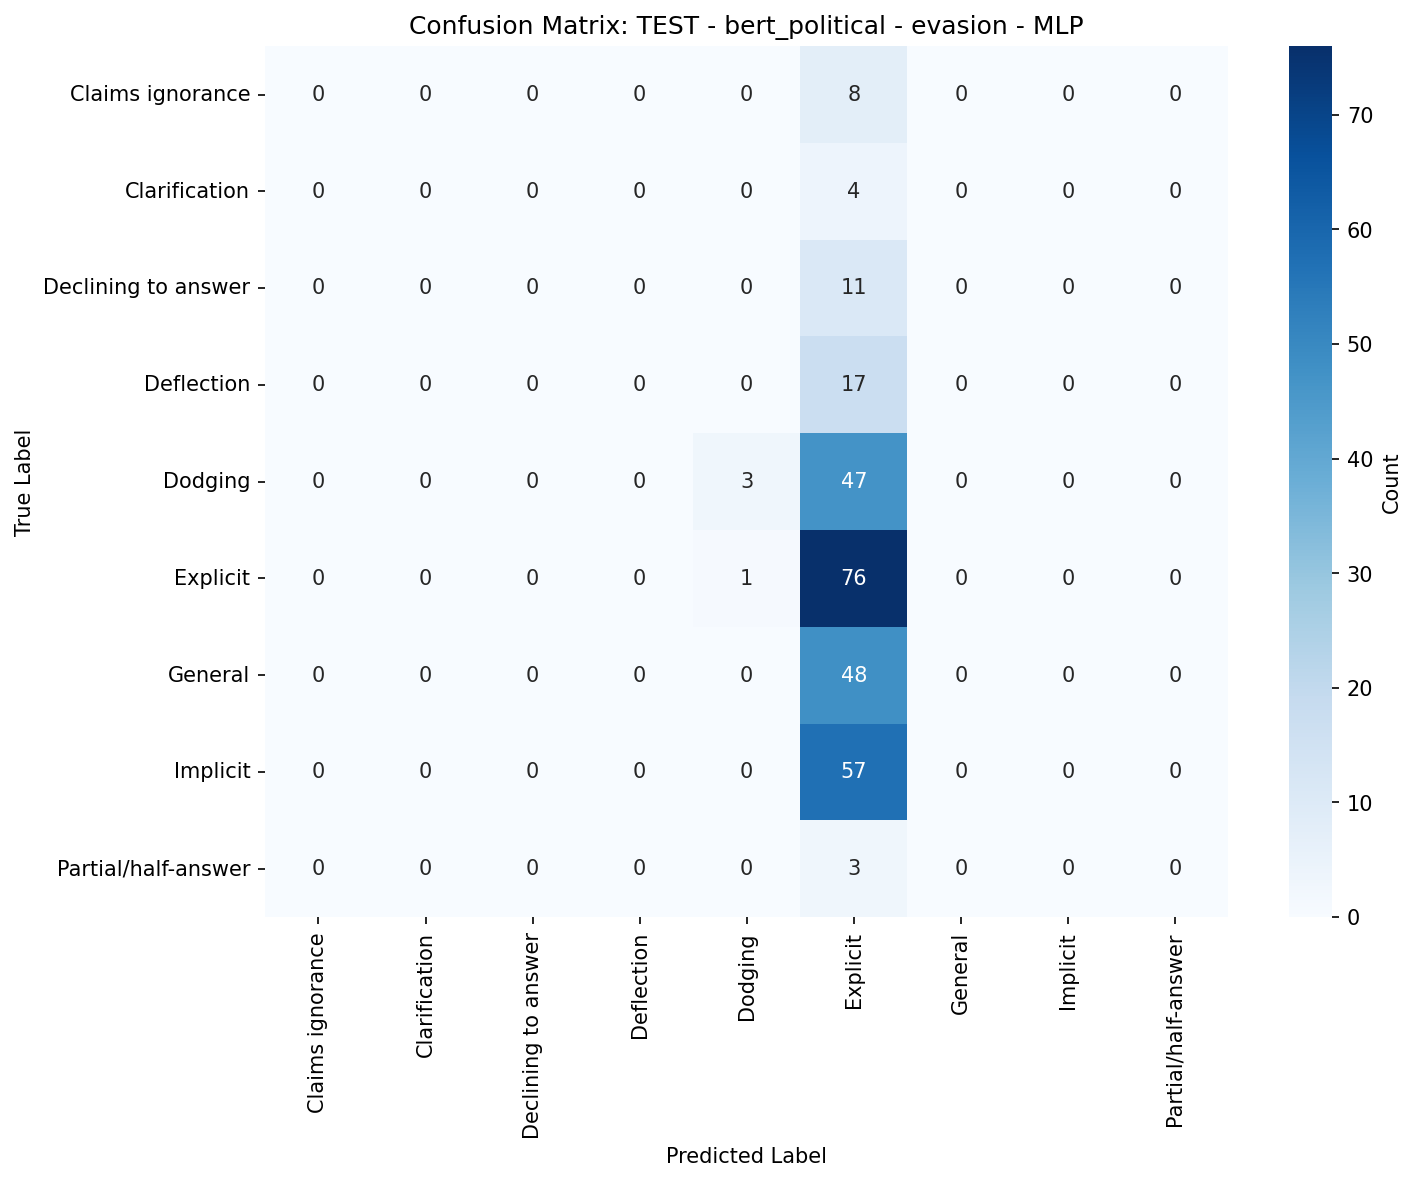


    Training XGBoost...

Classification Report: TEST - bert_political - evasion - XGBoost
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0000    0.0000    0.0000        17
            Dodging     0.2292    0.2200    0.2245        50
           Explicit     0.2947    0.7273    0.4195        77
            General     0.2500    0.0625    0.1000        48
           Implicit     0.1818    0.0351    0.0588        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2618       275
          macro avg     0.1062    0.1161    0.0892       275
       weighted avg     0.2055    0.2618    0.1879       275




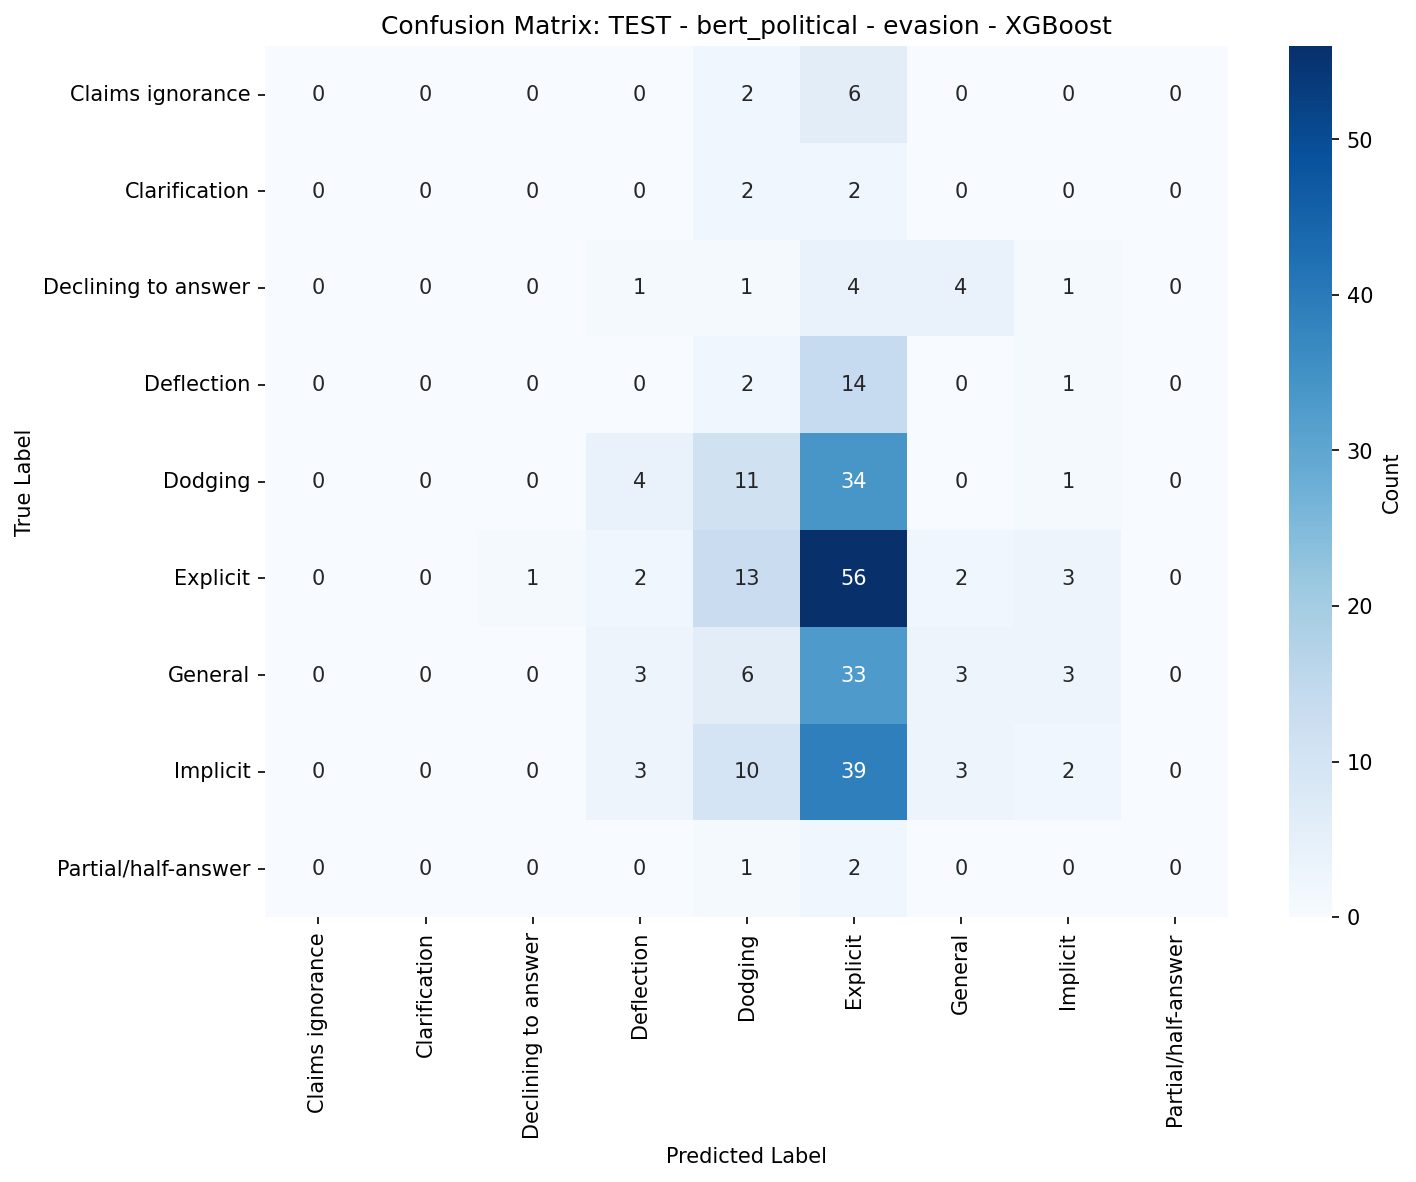


    Training LightGBM...

Classification Report: TEST - bert_political - evasion - LightGBM
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0909    0.0588    0.0714        17
            Dodging     0.2951    0.3600    0.3243        50
           Explicit     0.2944    0.6883    0.4125        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.2500    0.0702    0.1096        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2764       275
          macro avg     0.1034    0.1308    0.1020       275
       weighted avg     0.1935    0.2764    0.2016       275




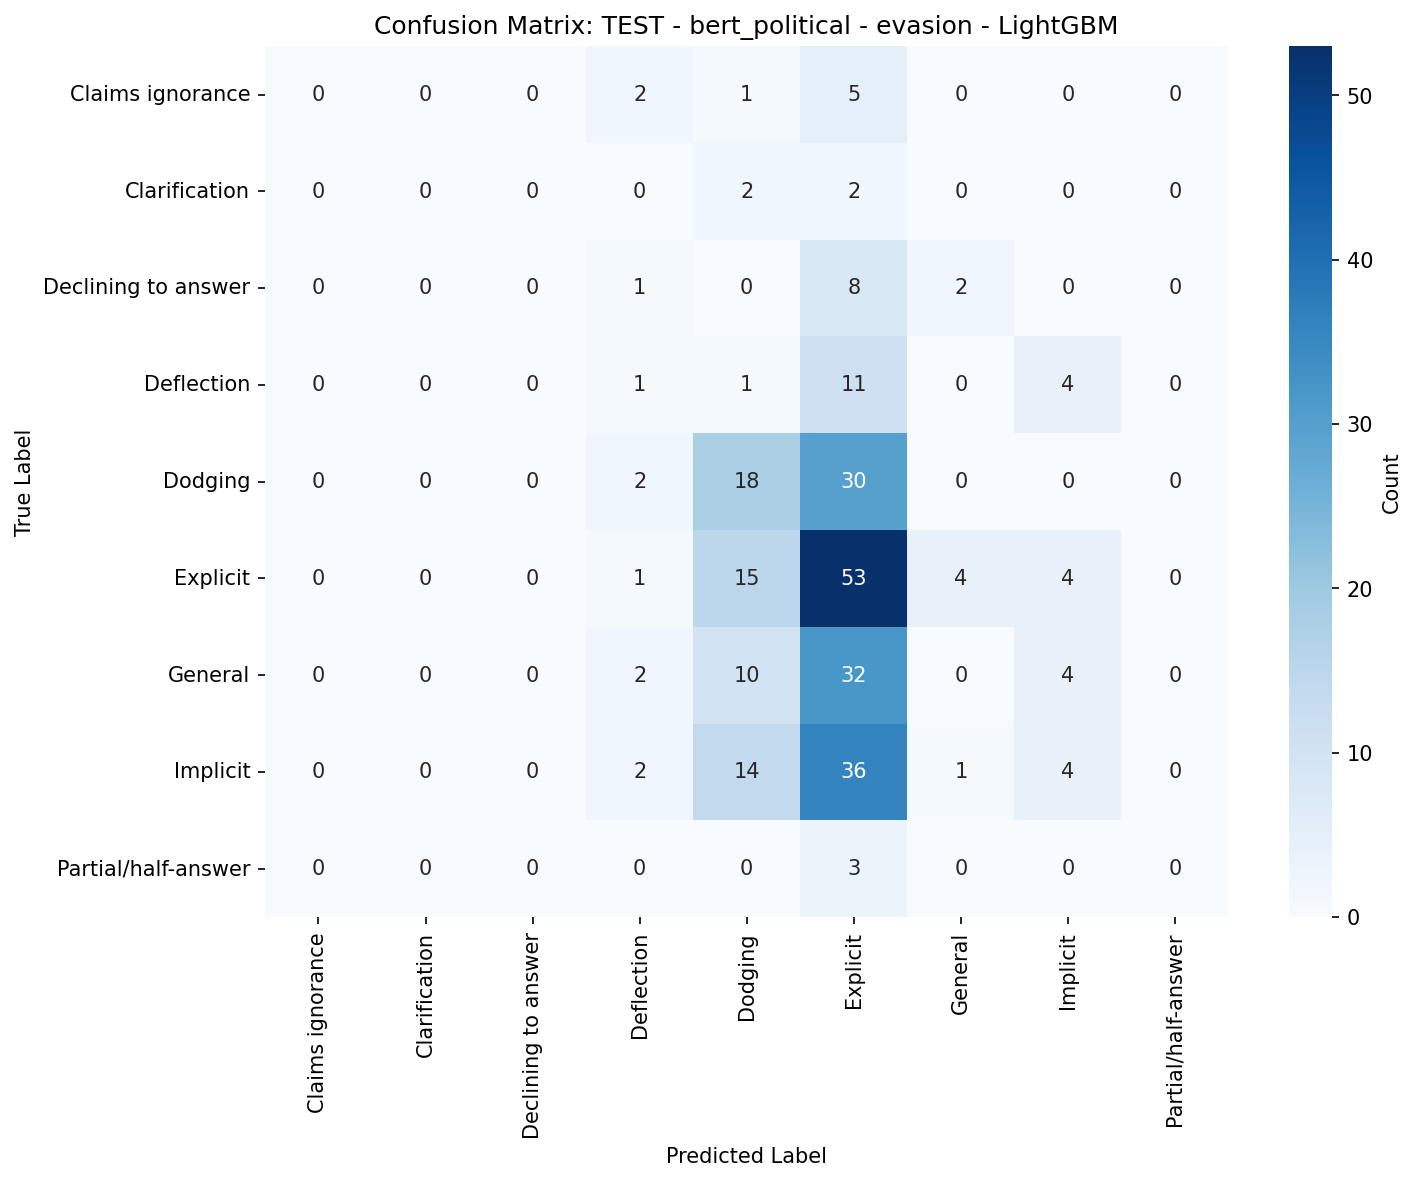


Results Table: TEST - bert_political - evasion
        Classifier                            Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest TEST - bert_political - evasion  0.276364  0.141894     0.196160         0.190649      0.160685
         LinearSVC TEST - bert_political - evasion  0.189091  0.111584     0.140336         0.099843      0.185606
          LightGBM TEST - bert_political - evasion  0.276364  0.101977     0.201585         0.103382      0.130812
LogisticRegression TEST - bert_political - evasion  0.094545  0.097883     0.101763         0.171615      0.233706
           XGBoost TEST - bert_political - evasion  0.261818  0.089199     0.187917         0.106191      0.116096
               MLP TEST - bert_political - evasion  0.287273  0.060877     0.142501         0.114494      0.116335

Per-Class Metrics: TEST - bert_political - evasion - RandomForest (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
  

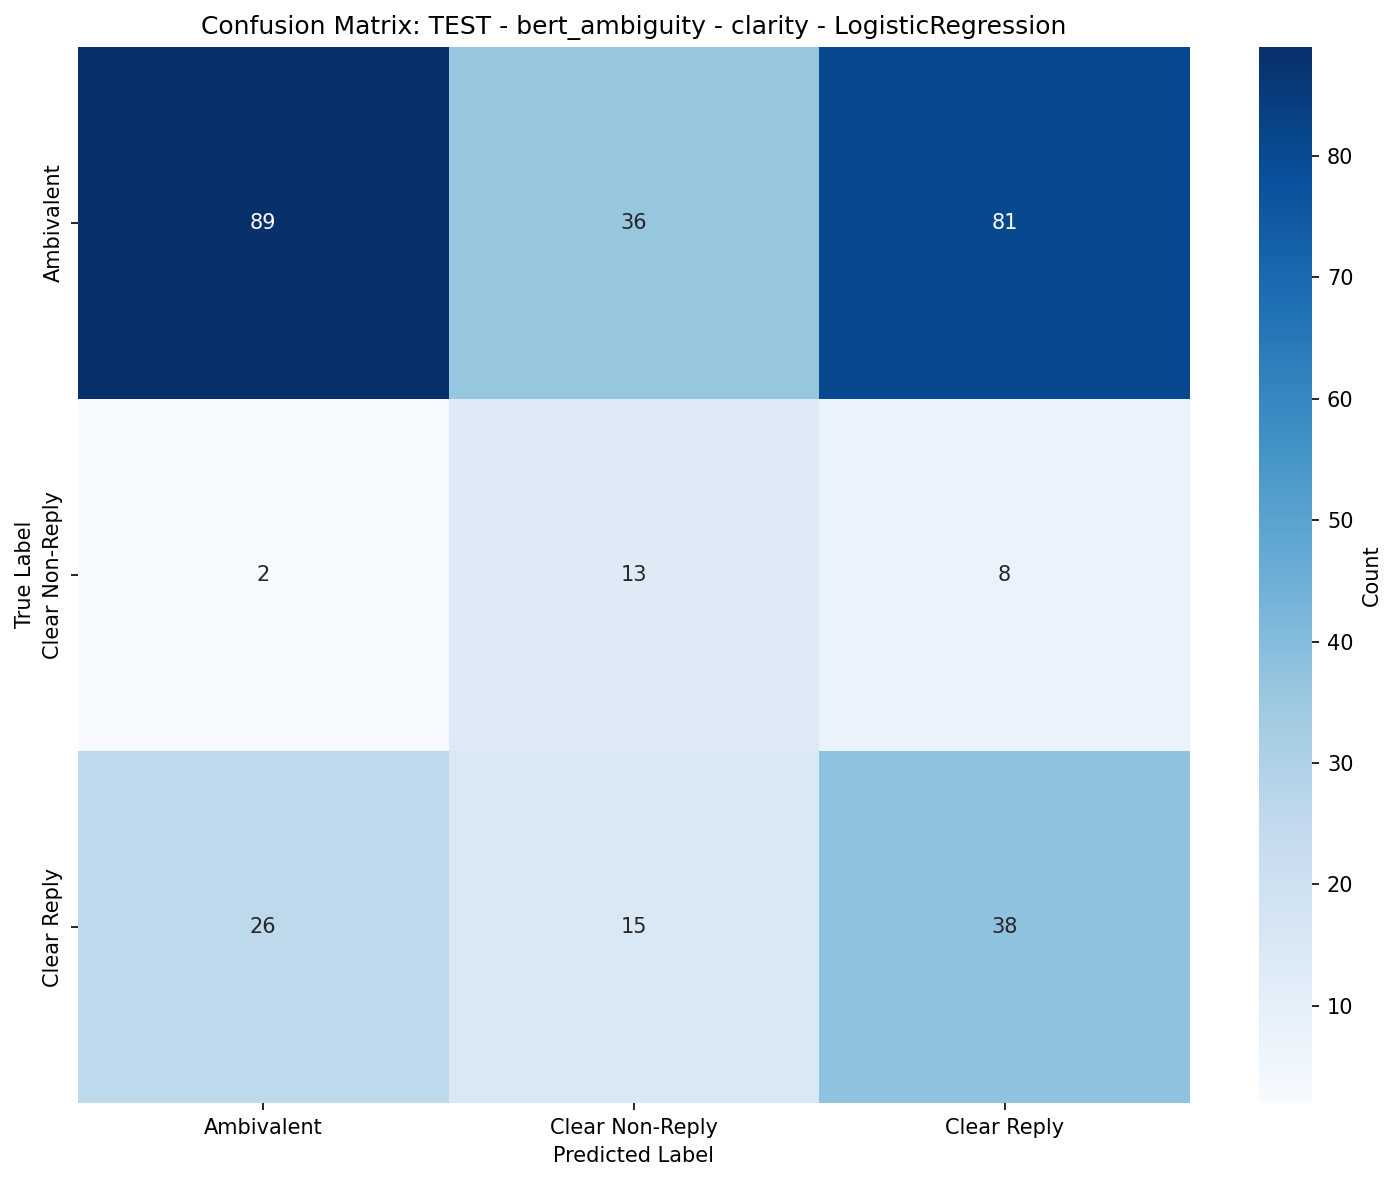


    Training LinearSVC...

Classification Report: TEST - bert_ambiguity - clarity - LinearSVC
                 precision    recall  f1-score   support

     Ambivalent     0.7246    0.8301    0.7738       206
Clear Non-Reply     0.2400    0.2609    0.2500        23
    Clear Reply     0.4255    0.2532    0.3175        79

       accuracy                         0.6396       308
      macro avg     0.4634    0.4480    0.4471       308
   weighted avg     0.6117    0.6396    0.6176       308




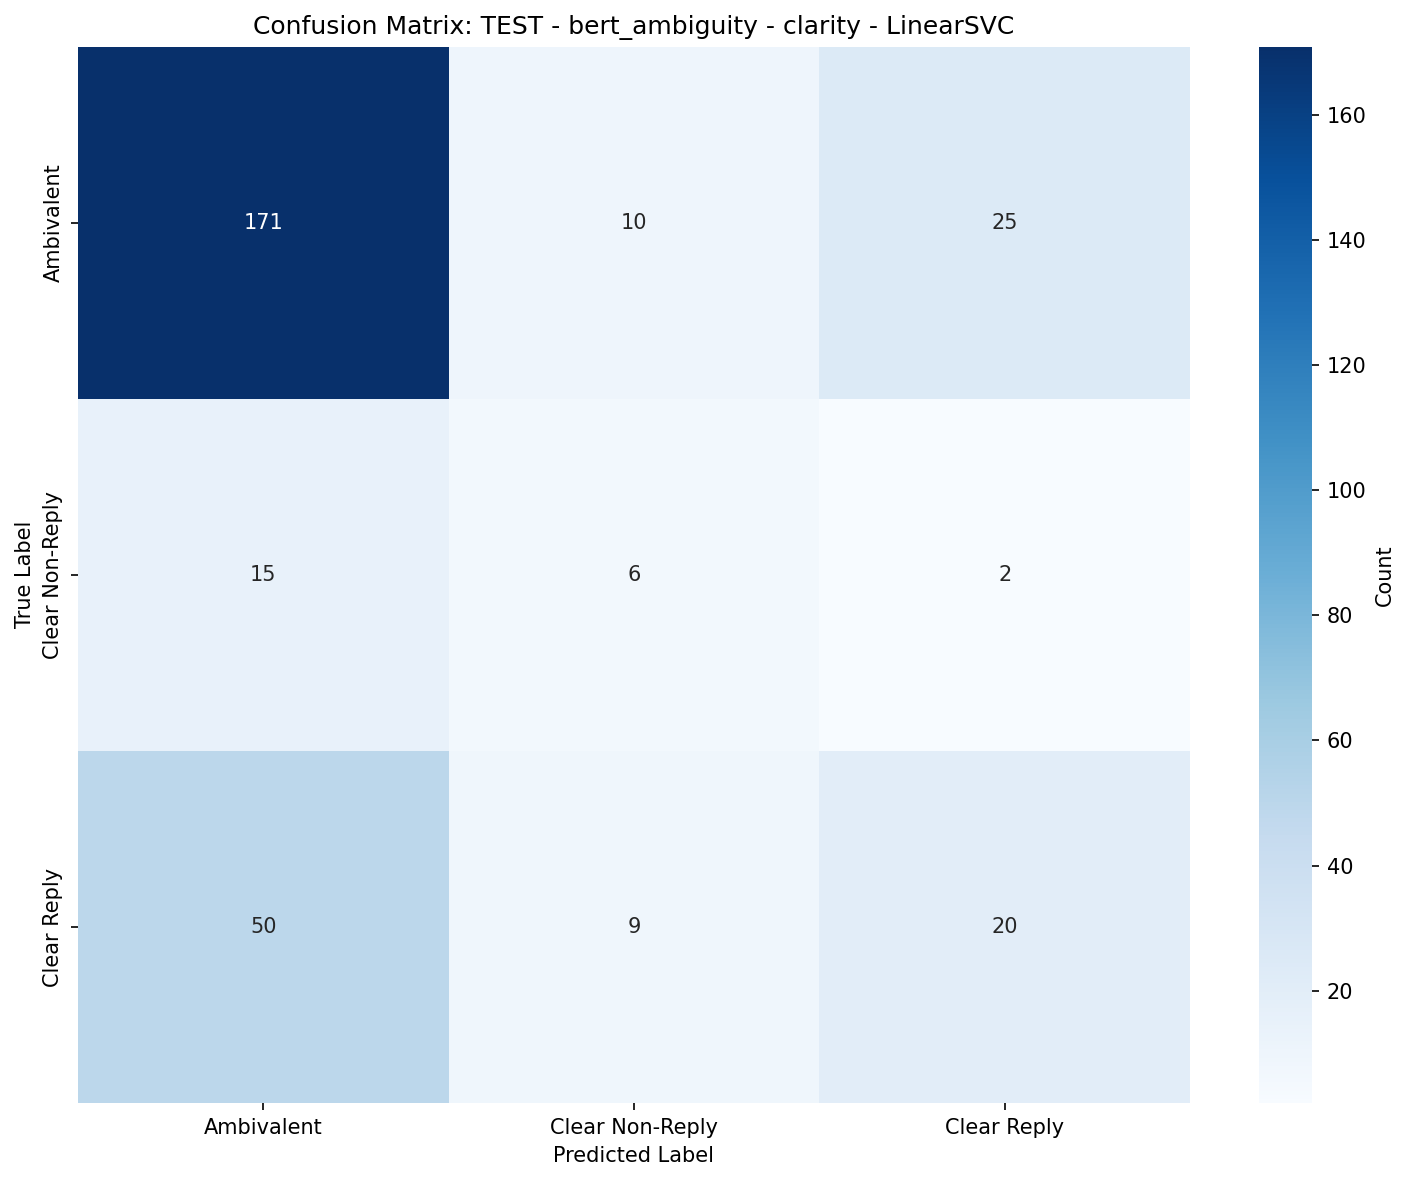


    Training RandomForest...

Classification Report: TEST - bert_ambiguity - clarity - RandomForest
                 precision    recall  f1-score   support

     Ambivalent     0.7085    0.9320    0.8050       206
Clear Non-Reply     0.6667    0.2609    0.3750        23
    Clear Reply     0.5000    0.1772    0.2617        79

       accuracy                         0.6883       308
      macro avg     0.6251    0.4567    0.4806       308
   weighted avg     0.6519    0.6883    0.6336       308




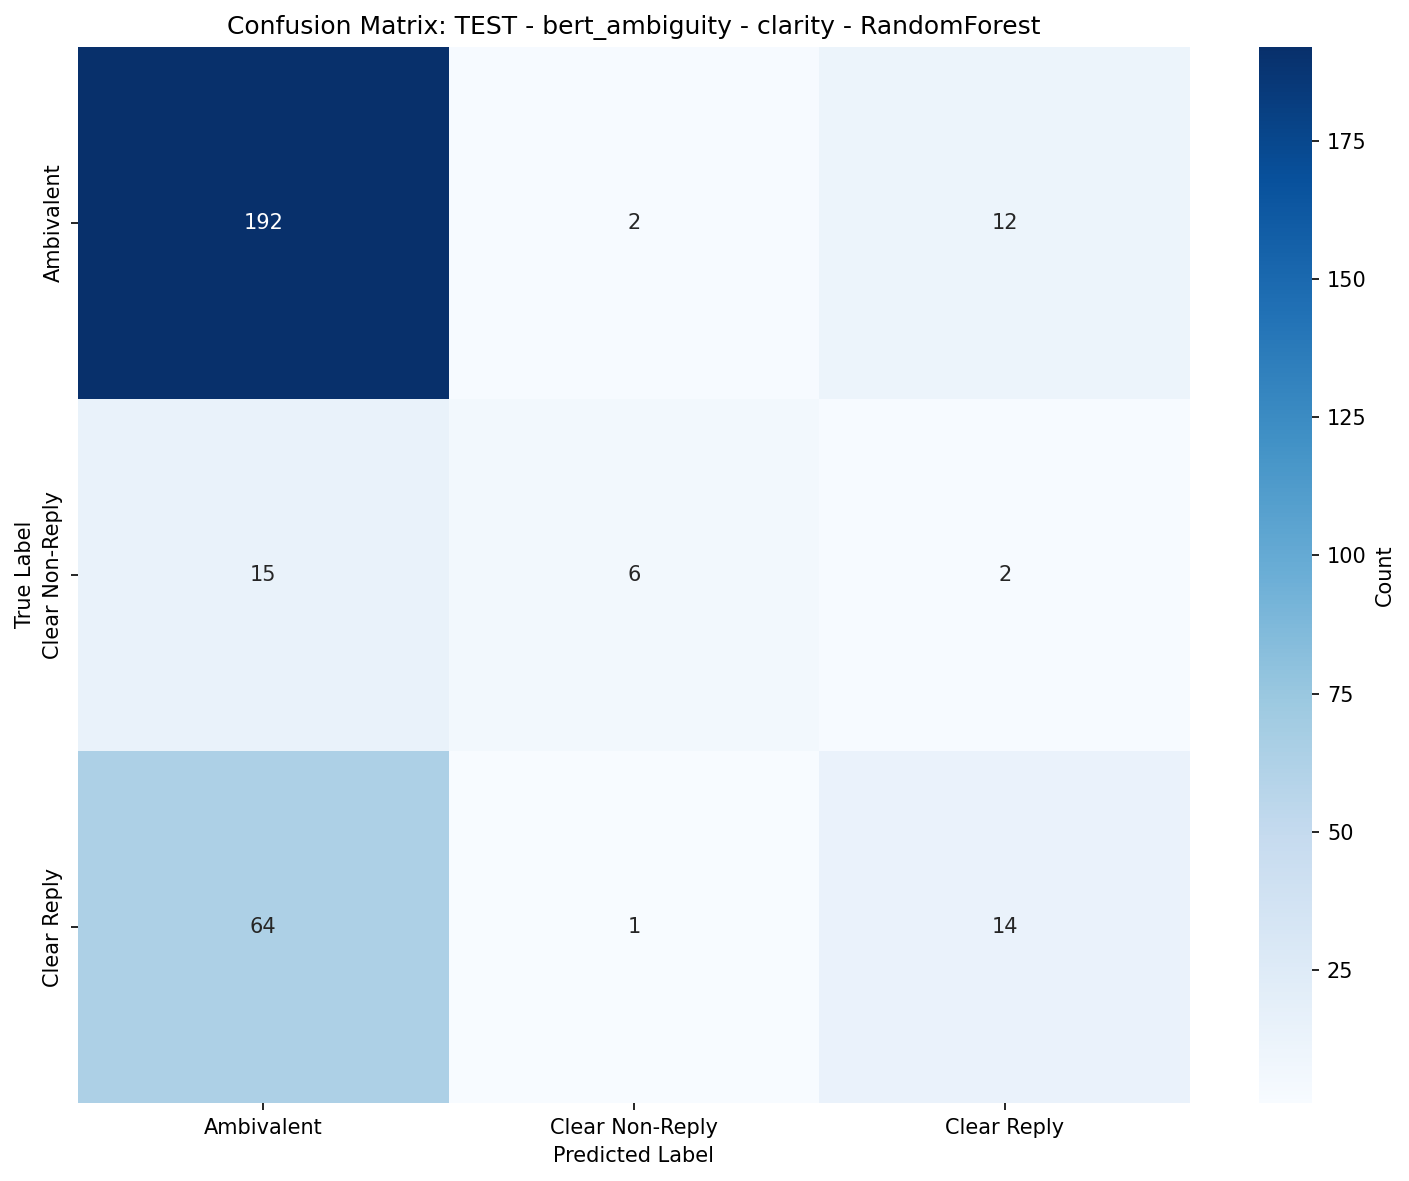


    Training MLP...

Classification Report: TEST - bert_ambiguity - clarity - MLP
                 precision    recall  f1-score   support

     Ambivalent     0.6858    0.9854    0.8088       206
Clear Non-Reply     0.7500    0.1304    0.2222        23
    Clear Reply     0.6250    0.0633    0.1149        79

       accuracy                         0.6851       308
      macro avg     0.6869    0.3931    0.3820       308
   weighted avg     0.6750    0.6851    0.5870       308




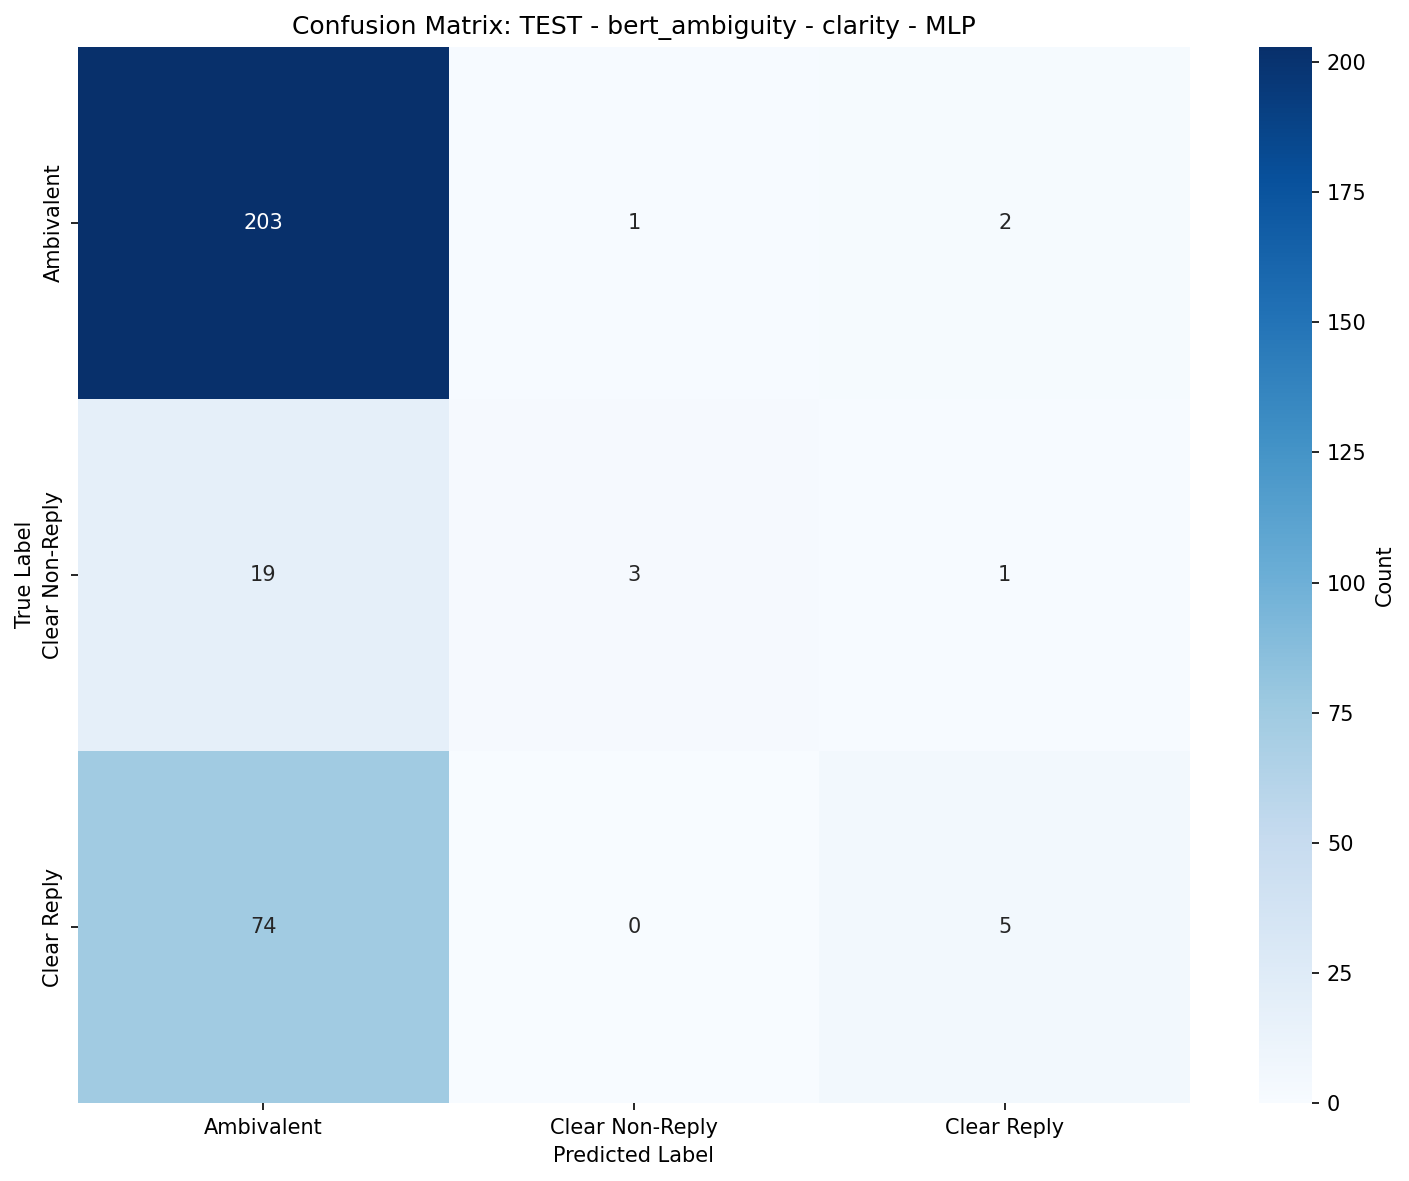


    Training XGBoost...

Classification Report: TEST - bert_ambiguity - clarity - XGBoost
                 precision    recall  f1-score   support

     Ambivalent     0.7108    0.8592    0.7780       206
Clear Non-Reply     0.6667    0.2609    0.3750        23
    Clear Reply     0.4200    0.2658    0.3256        79

       accuracy                         0.6623       308
      macro avg     0.5992    0.4620    0.4929       308
   weighted avg     0.6329    0.6623    0.6319       308




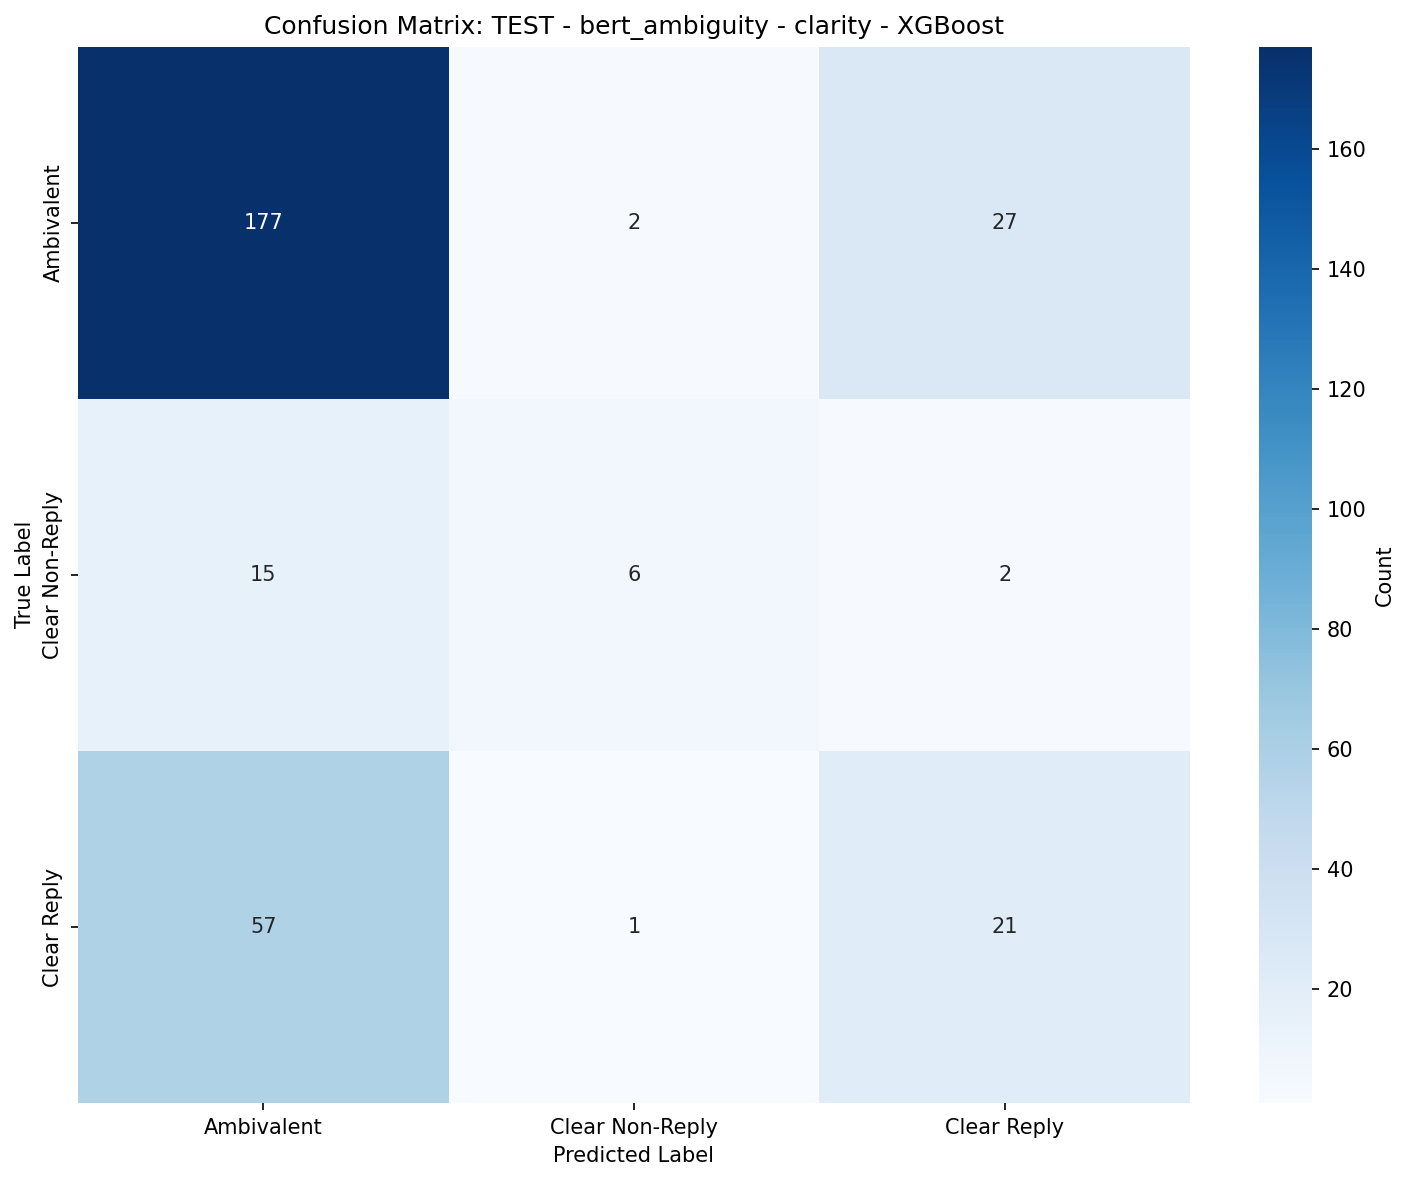


    Training LightGBM...

Classification Report: TEST - bert_ambiguity - clarity - LightGBM
                 precision    recall  f1-score   support

     Ambivalent     0.7104    0.8932    0.7914       206
Clear Non-Reply     0.6250    0.2174    0.3226        23
    Clear Reply     0.4390    0.2278    0.3000        79

       accuracy                         0.6721       308
      macro avg     0.5915    0.4461    0.4713       308
   weighted avg     0.6344    0.6721    0.6303       308




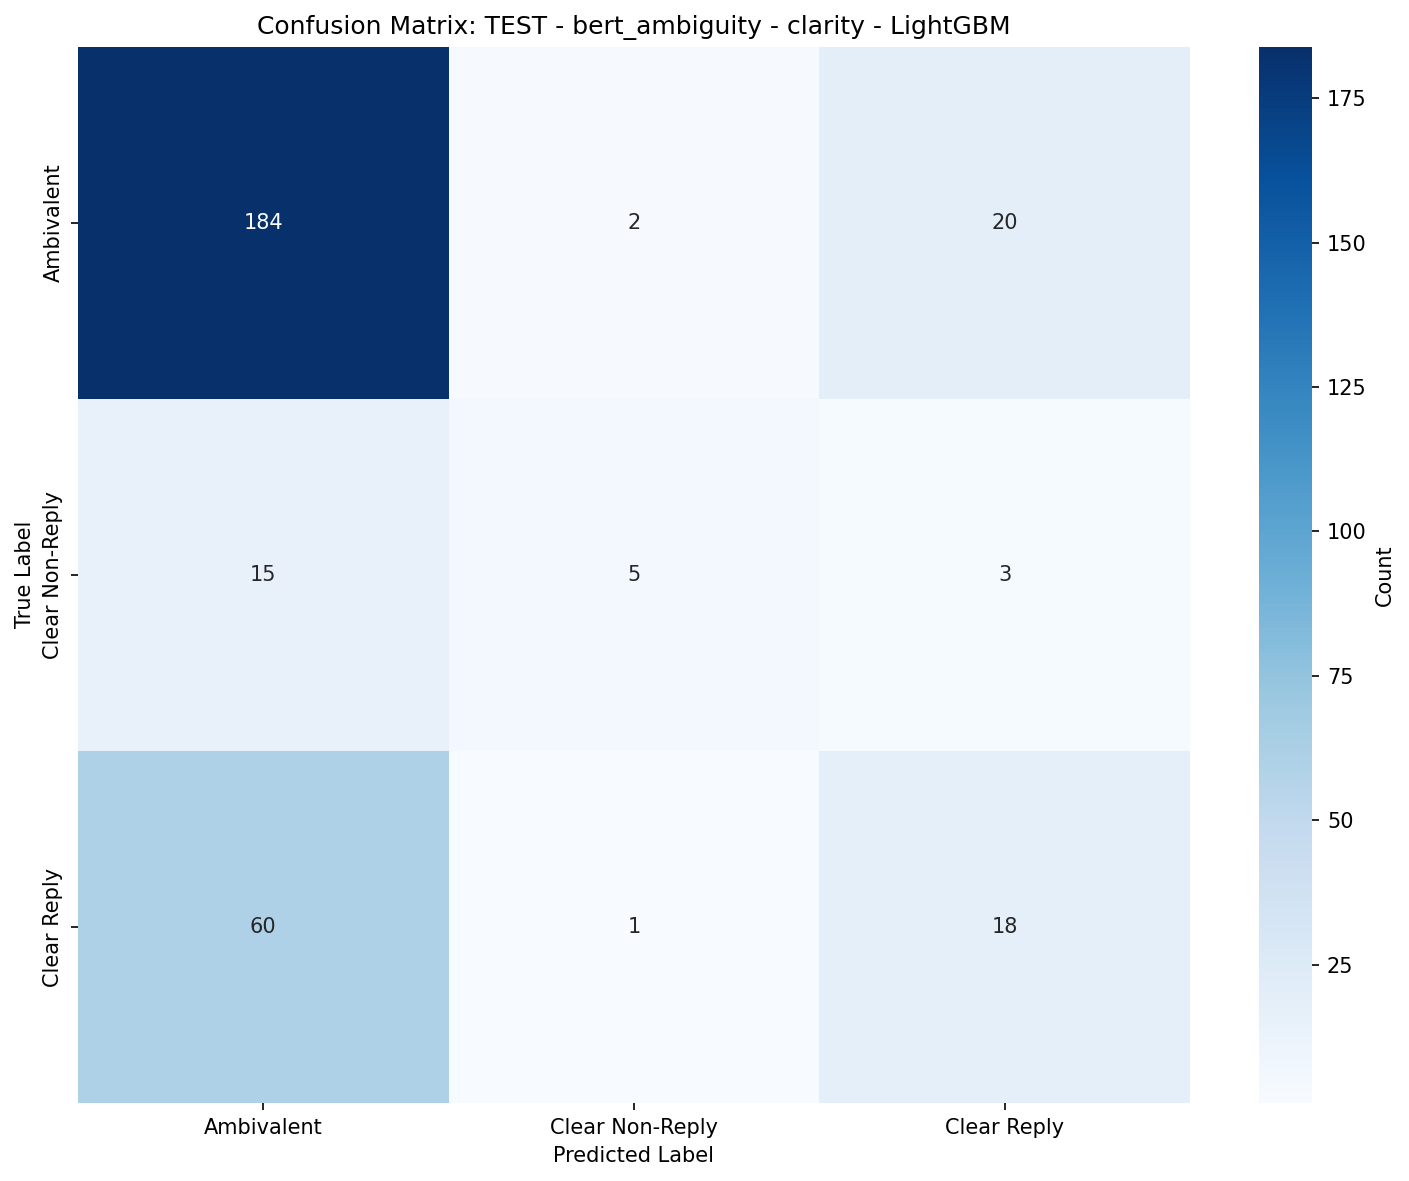


Results Table: TEST - bert_ambiguity - clarity
        Classifier                            Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
           XGBoost TEST - bert_ambiguity - clarity  0.662338  0.492868     0.631878         0.599170      0.461972
      RandomForest TEST - bert_ambiguity - clarity  0.688312  0.480571     0.633553         0.625051      0.456708
          LightGBM TEST - bert_ambiguity - clarity  0.672078  0.471326     0.630348         0.591483      0.446148
         LinearSVC TEST - bert_ambiguity - clarity  0.639610  0.447072     0.617607         0.463369      0.448044
LogisticRegression TEST - bert_ambiguity - clarity  0.454545  0.406289     0.485527         0.421007      0.492756
               MLP TEST - bert_ambiguity - clarity  0.685065  0.381977     0.587004         0.686937      0.393054

Per-Class Metrics: TEST - bert_ambiguity - clarity - XGBoost (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambiva

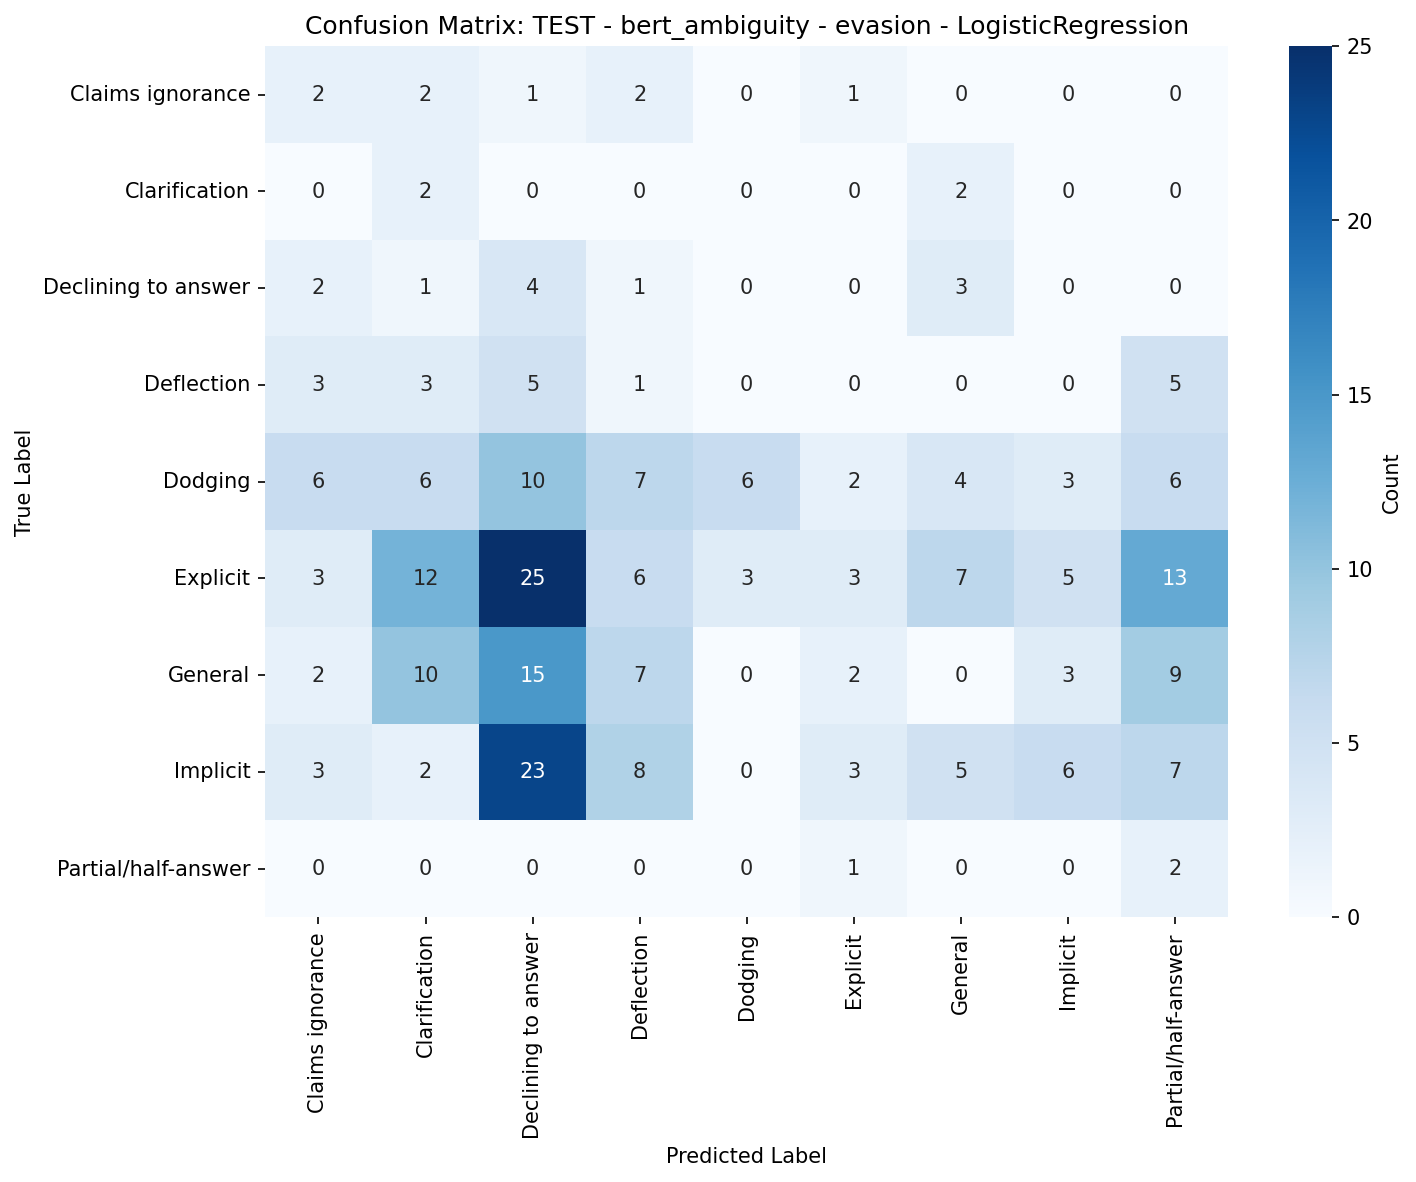


    Training LinearSVC...

Classification Report: TEST - bert_ambiguity - evasion - LinearSVC
                     precision    recall  f1-score   support

   Claims ignorance     0.1250    0.1250    0.1250         8
      Clarification     0.1538    0.5000    0.2353         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0769    0.0588    0.0667        17
            Dodging     0.1429    0.1000    0.1176        50
           Explicit     0.2733    0.5325    0.3612        77
            General     0.0909    0.0208    0.0339        48
           Implicit     0.0000    0.0000    0.0000        57
Partial/half-answer     0.0357    0.3333    0.0645         3

           accuracy                         0.1891       275
          macro avg     0.0998    0.1856    0.1116       275
       weighted avg     0.1294    0.1891    0.1403       275




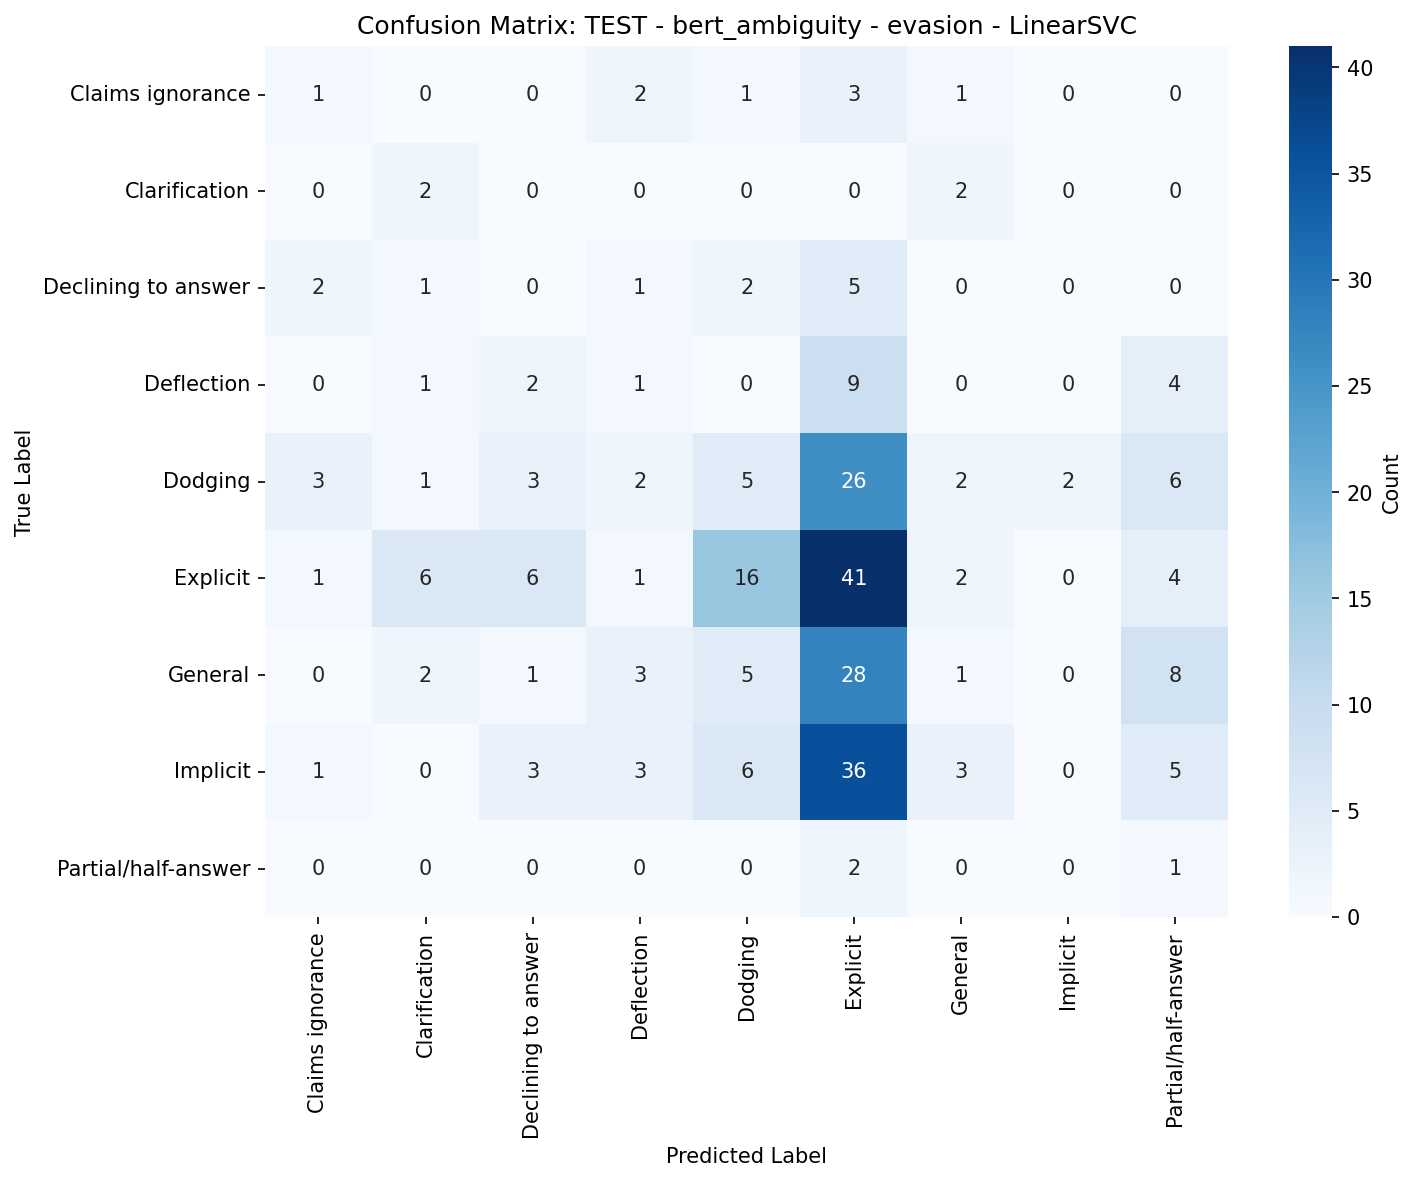


    Training RandomForest...

Classification Report: TEST - bert_ambiguity - evasion - RandomForest
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.5000    0.2500    0.3333         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.2308    0.1765    0.2000        17
            Dodging     0.2093    0.1800    0.1935        50
           Explicit     0.2950    0.7662    0.4260        77
            General     0.2500    0.0208    0.0385        48
           Implicit     0.2308    0.0526    0.0857        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2764       275
          macro avg     0.1906    0.1607    0.1419       275
       weighted avg     0.2337    0.2764    0.1962       275




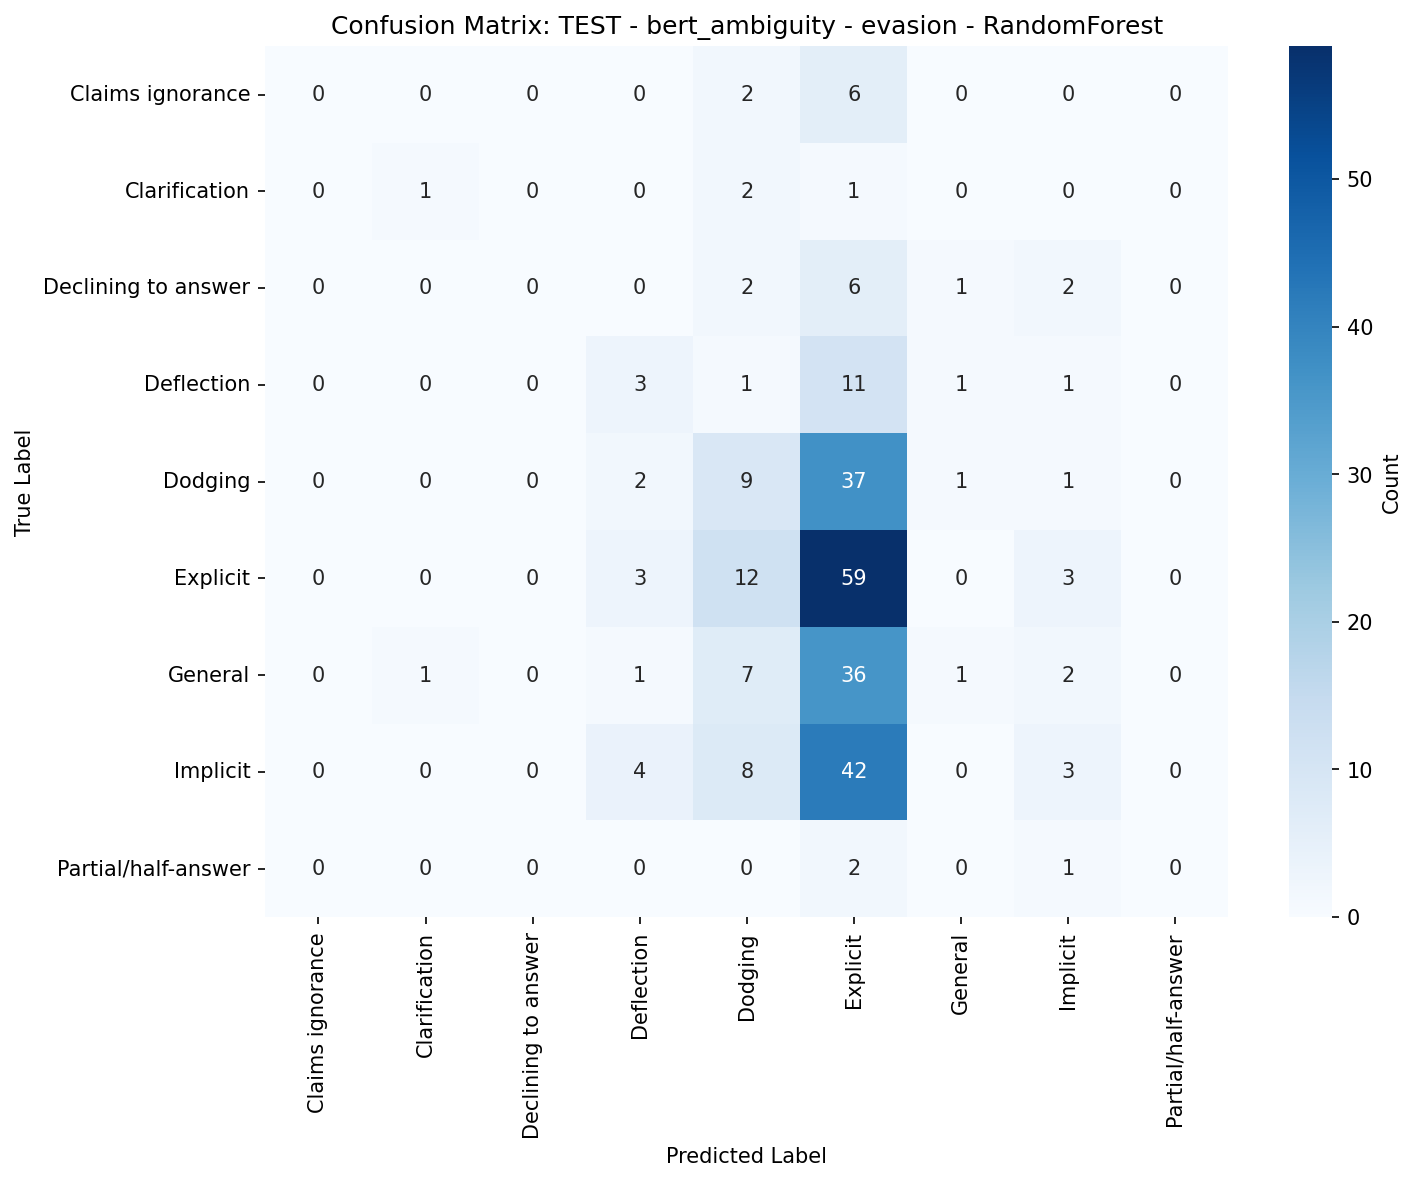


    Training MLP...

Classification Report: TEST - bert_ambiguity - evasion - MLP
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0000    0.0000    0.0000        17
            Dodging     0.7500    0.0600    0.1111        50
           Explicit     0.2804    0.9870    0.4368        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.0000    0.0000    0.0000        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2873       275
          macro avg     0.1145    0.1163    0.0609       275
       weighted avg     0.2149    0.2873    0.1425       275




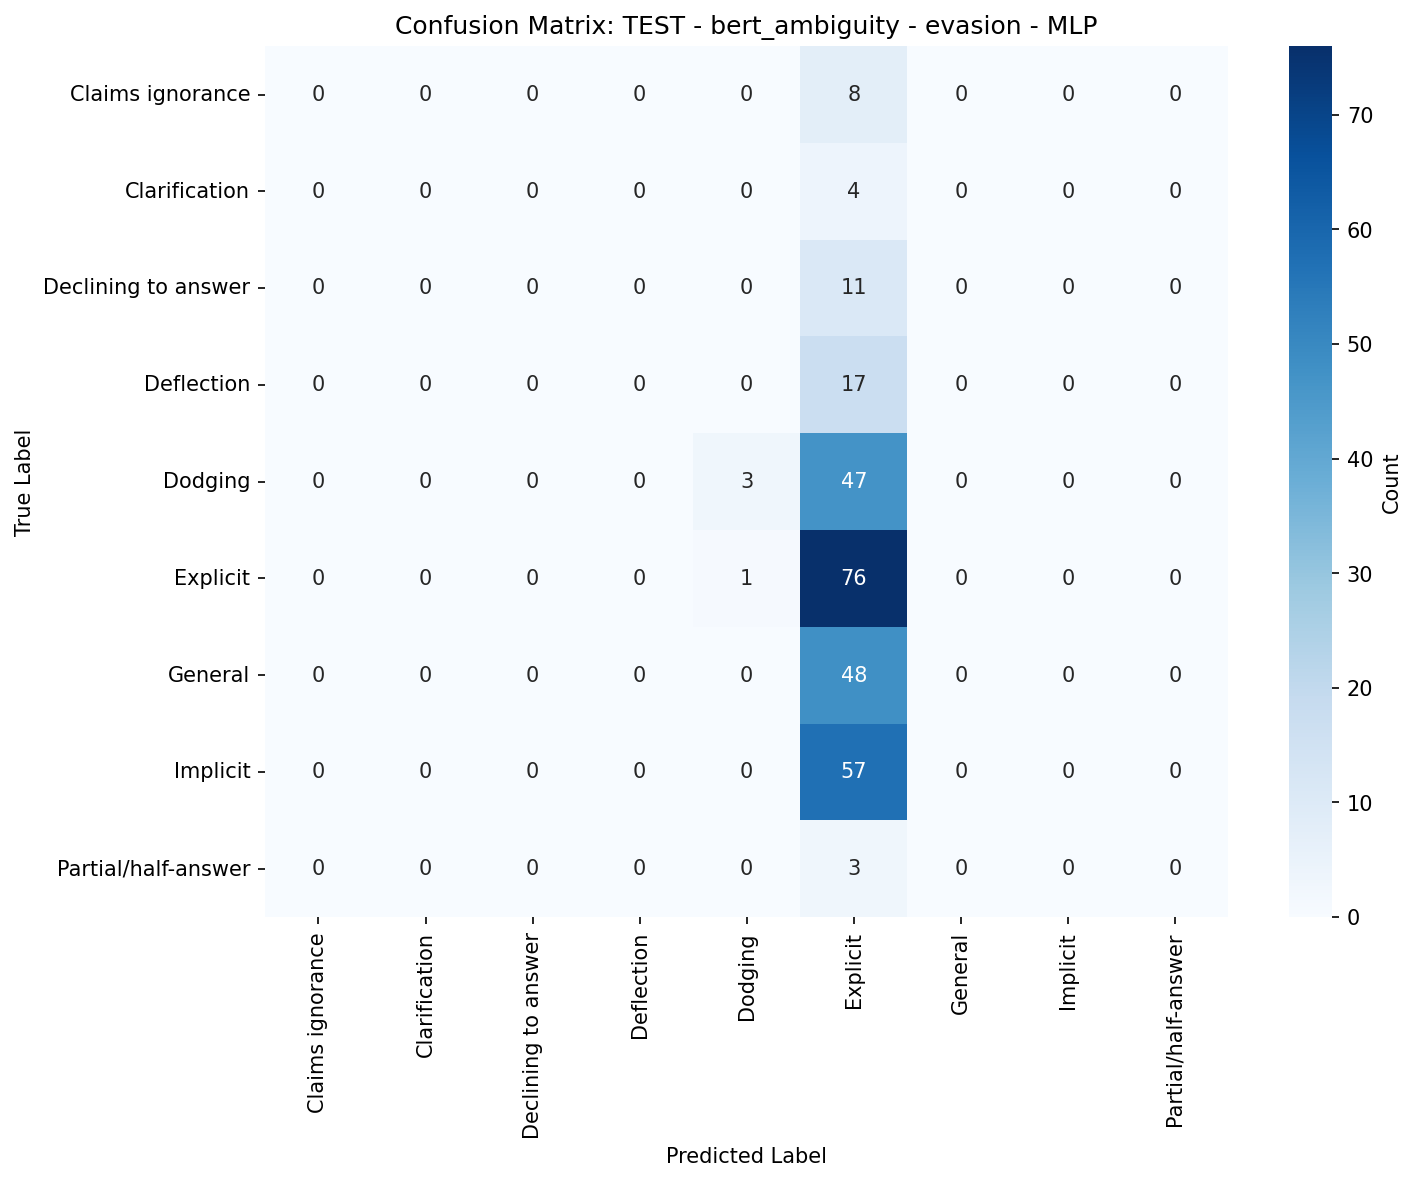


    Training XGBoost...

Classification Report: TEST - bert_ambiguity - evasion - XGBoost
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0000    0.0000    0.0000        17
            Dodging     0.2292    0.2200    0.2245        50
           Explicit     0.2947    0.7273    0.4195        77
            General     0.2500    0.0625    0.1000        48
           Implicit     0.1818    0.0351    0.0588        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2618       275
          macro avg     0.1062    0.1161    0.0892       275
       weighted avg     0.2055    0.2618    0.1879       275




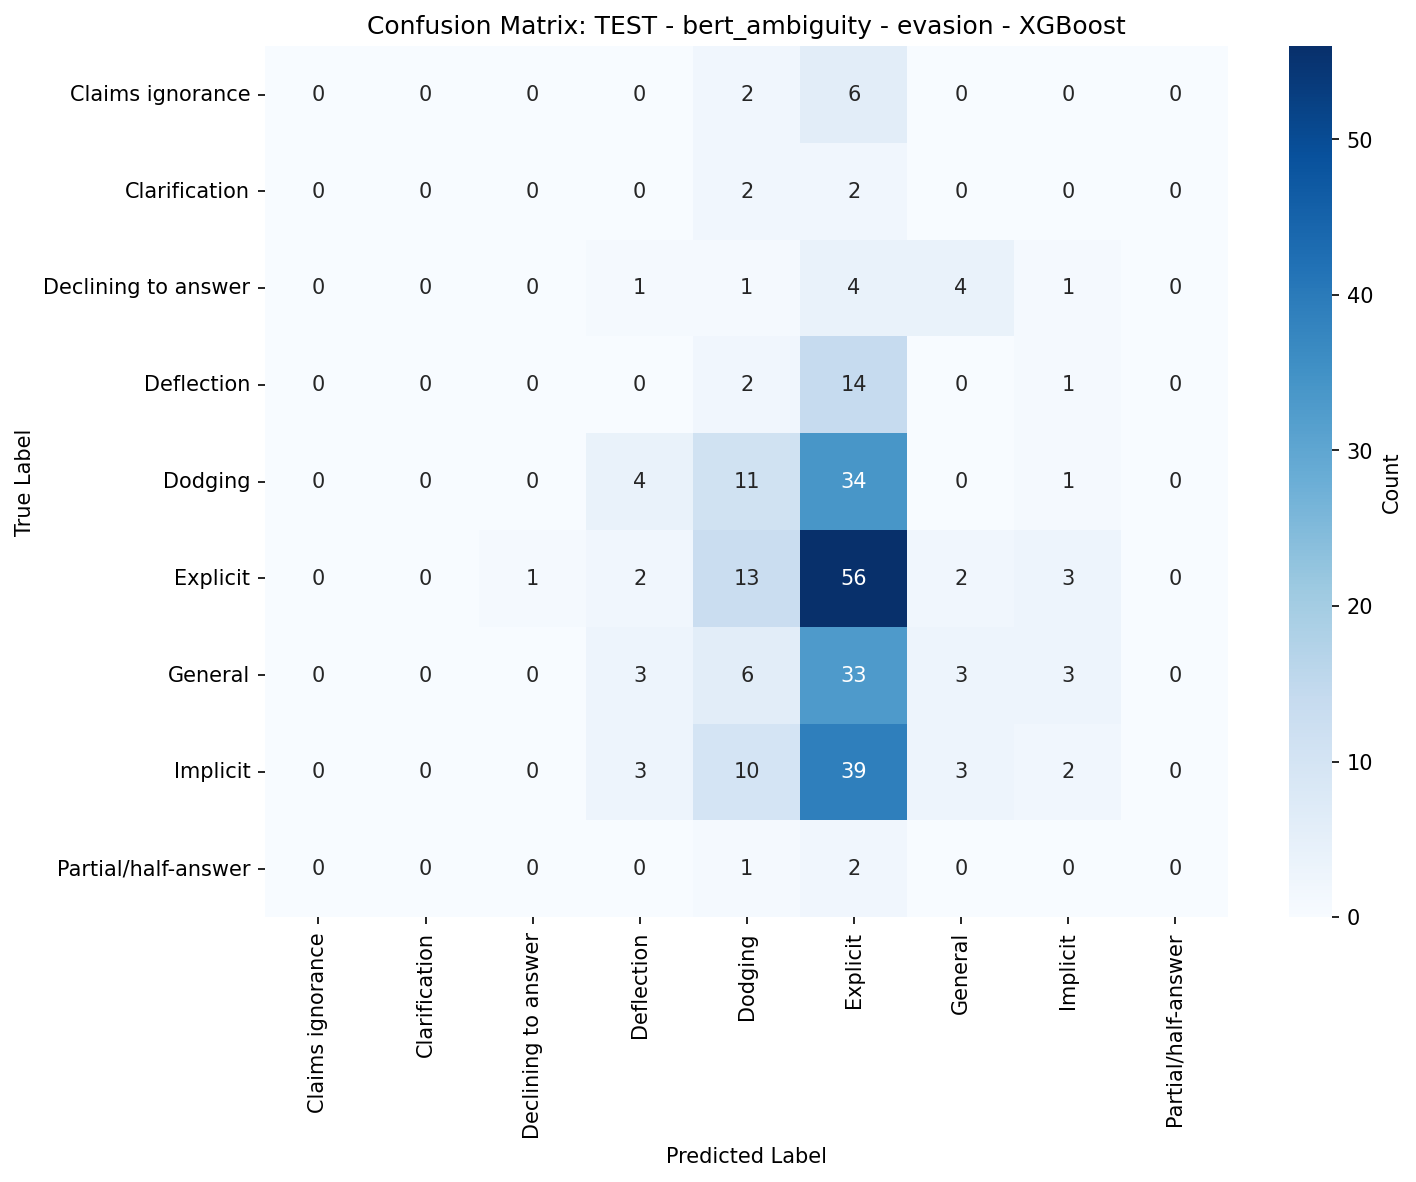


    Training LightGBM...

Classification Report: TEST - bert_ambiguity - evasion - LightGBM
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0909    0.0588    0.0714        17
            Dodging     0.2951    0.3600    0.3243        50
           Explicit     0.2944    0.6883    0.4125        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.2500    0.0702    0.1096        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2764       275
          macro avg     0.1034    0.1308    0.1020       275
       weighted avg     0.1935    0.2764    0.2016       275




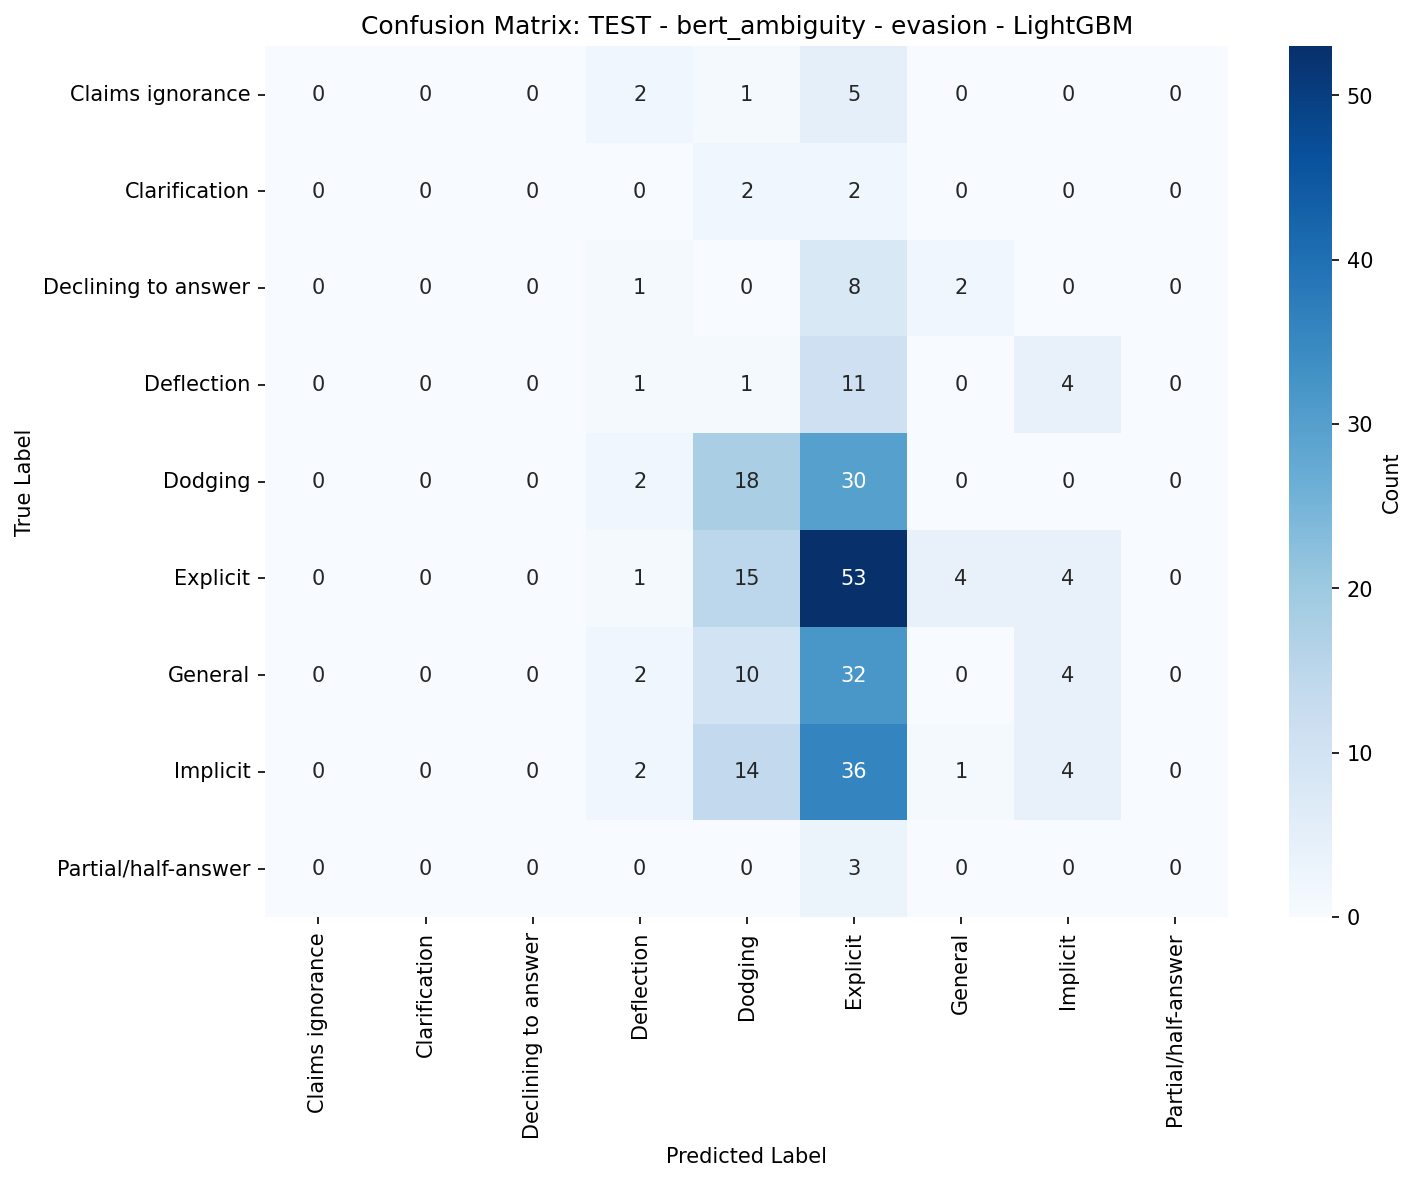


Results Table: TEST - bert_ambiguity - evasion
        Classifier                            Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest TEST - bert_ambiguity - evasion  0.276364  0.141894     0.196160         0.190649      0.160685
         LinearSVC TEST - bert_ambiguity - evasion  0.189091  0.111584     0.140336         0.099843      0.185606
          LightGBM TEST - bert_ambiguity - evasion  0.276364  0.101977     0.201585         0.103382      0.130812
LogisticRegression TEST - bert_ambiguity - evasion  0.094545  0.097883     0.101763         0.171615      0.233706
           XGBoost TEST - bert_ambiguity - evasion  0.261818  0.089199     0.187917         0.106191      0.116096
               MLP TEST - bert_ambiguity - evasion  0.287273  0.060877     0.142501         0.114494      0.116335

Per-Class Metrics: TEST - bert_ambiguity - evasion - RandomForest (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
  

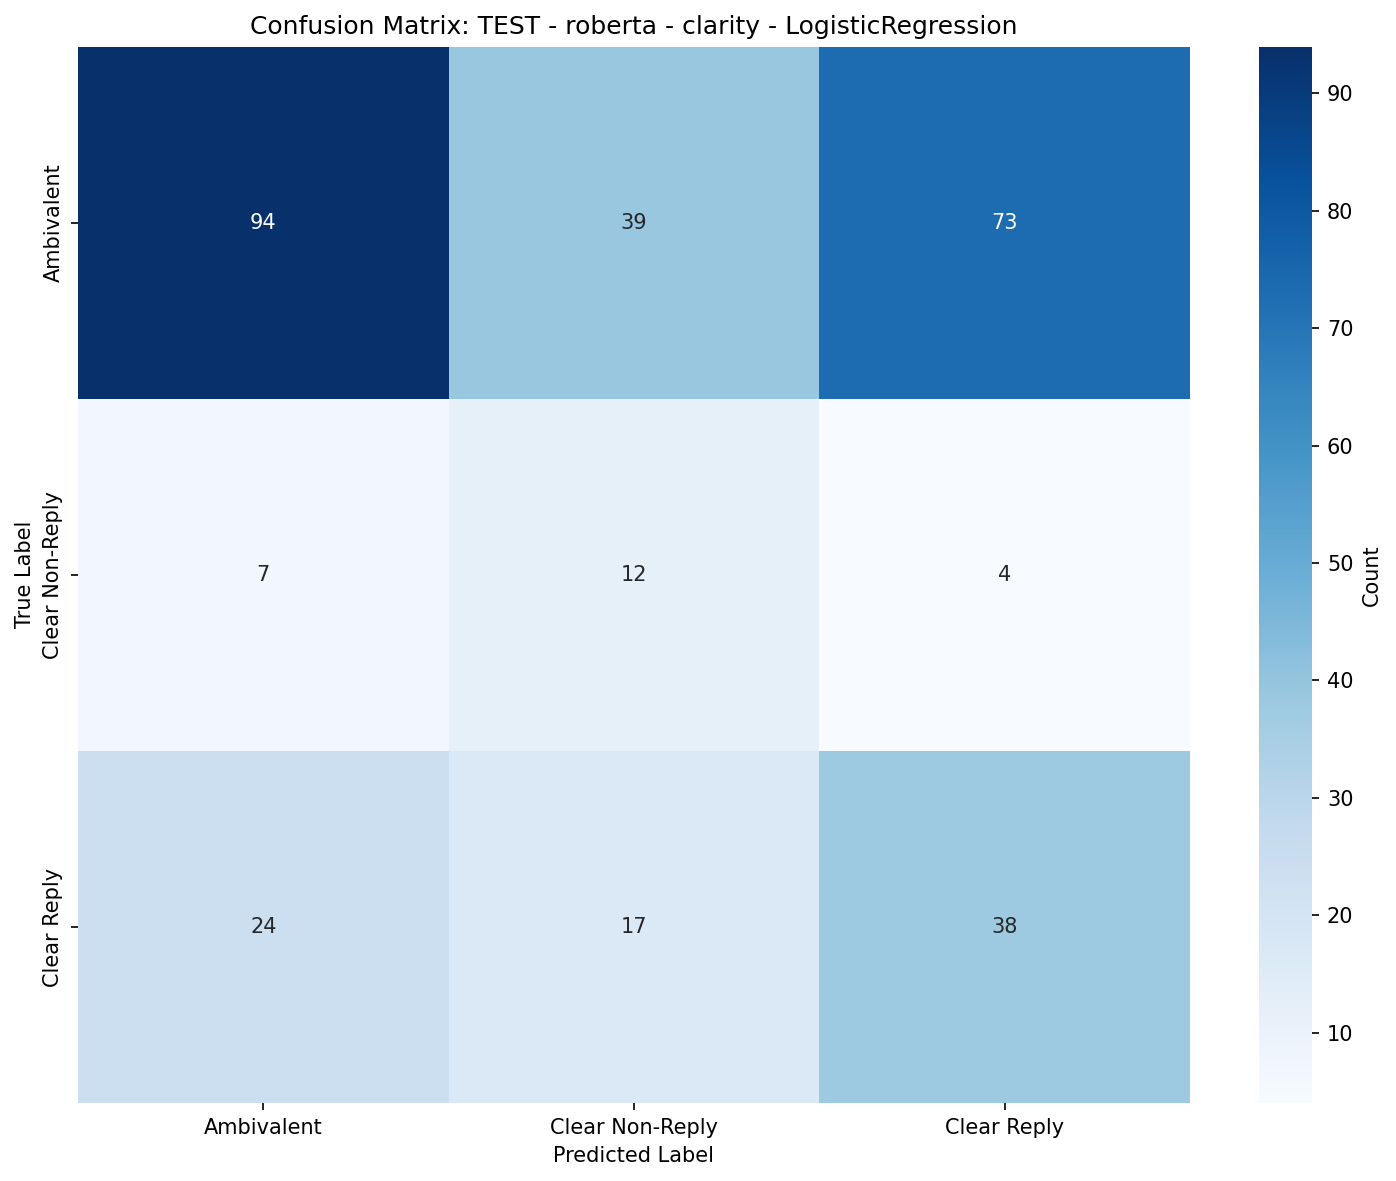


    Training LinearSVC...

Classification Report: TEST - roberta - clarity - LinearSVC
                 precision    recall  f1-score   support

     Ambivalent     0.7126    0.8544    0.7770       206
Clear Non-Reply     0.1667    0.1739    0.1702        23
    Clear Reply     0.4324    0.2025    0.2759        79

       accuracy                         0.6364       308
      macro avg     0.4372    0.4103    0.4077       308
   weighted avg     0.5999    0.6364    0.6032       308




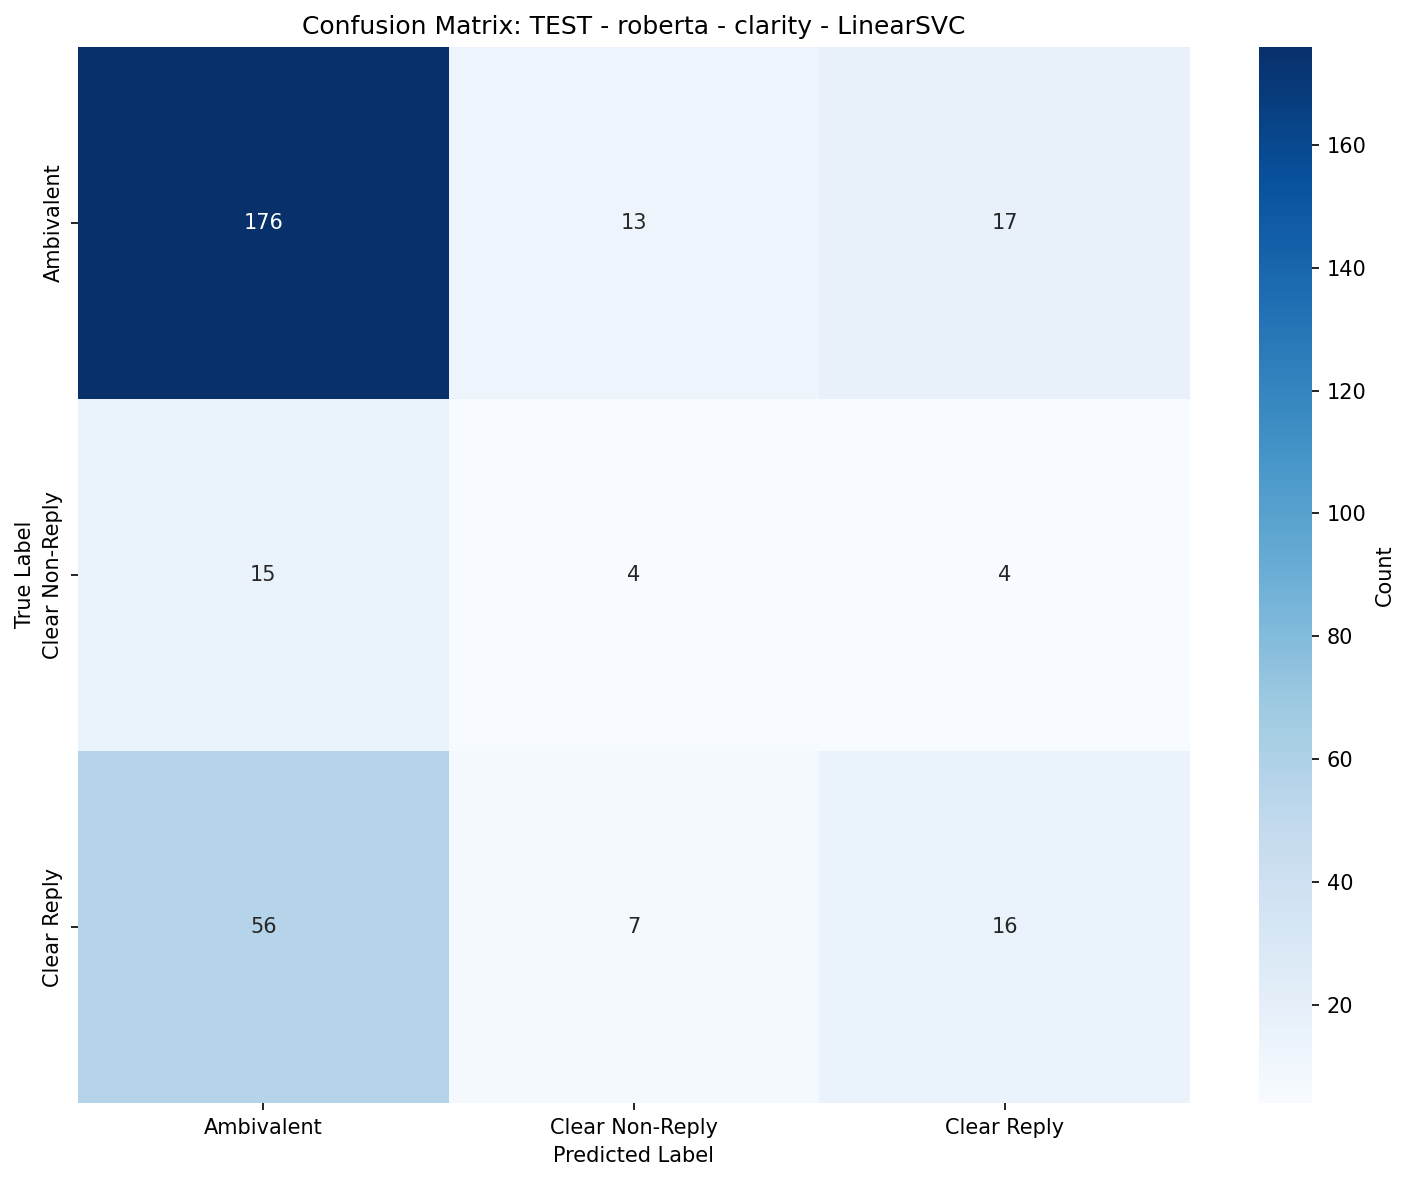


    Training RandomForest...

Classification Report: TEST - roberta - clarity - RandomForest
                 precision    recall  f1-score   support

     Ambivalent     0.6978    0.9417    0.8017       206
Clear Non-Reply     0.8333    0.2174    0.3448        23
    Clear Reply     0.5417    0.1646    0.2524        79

       accuracy                         0.6883       308
      macro avg     0.6909    0.4412    0.4663       308
   weighted avg     0.6679    0.6883    0.6267       308




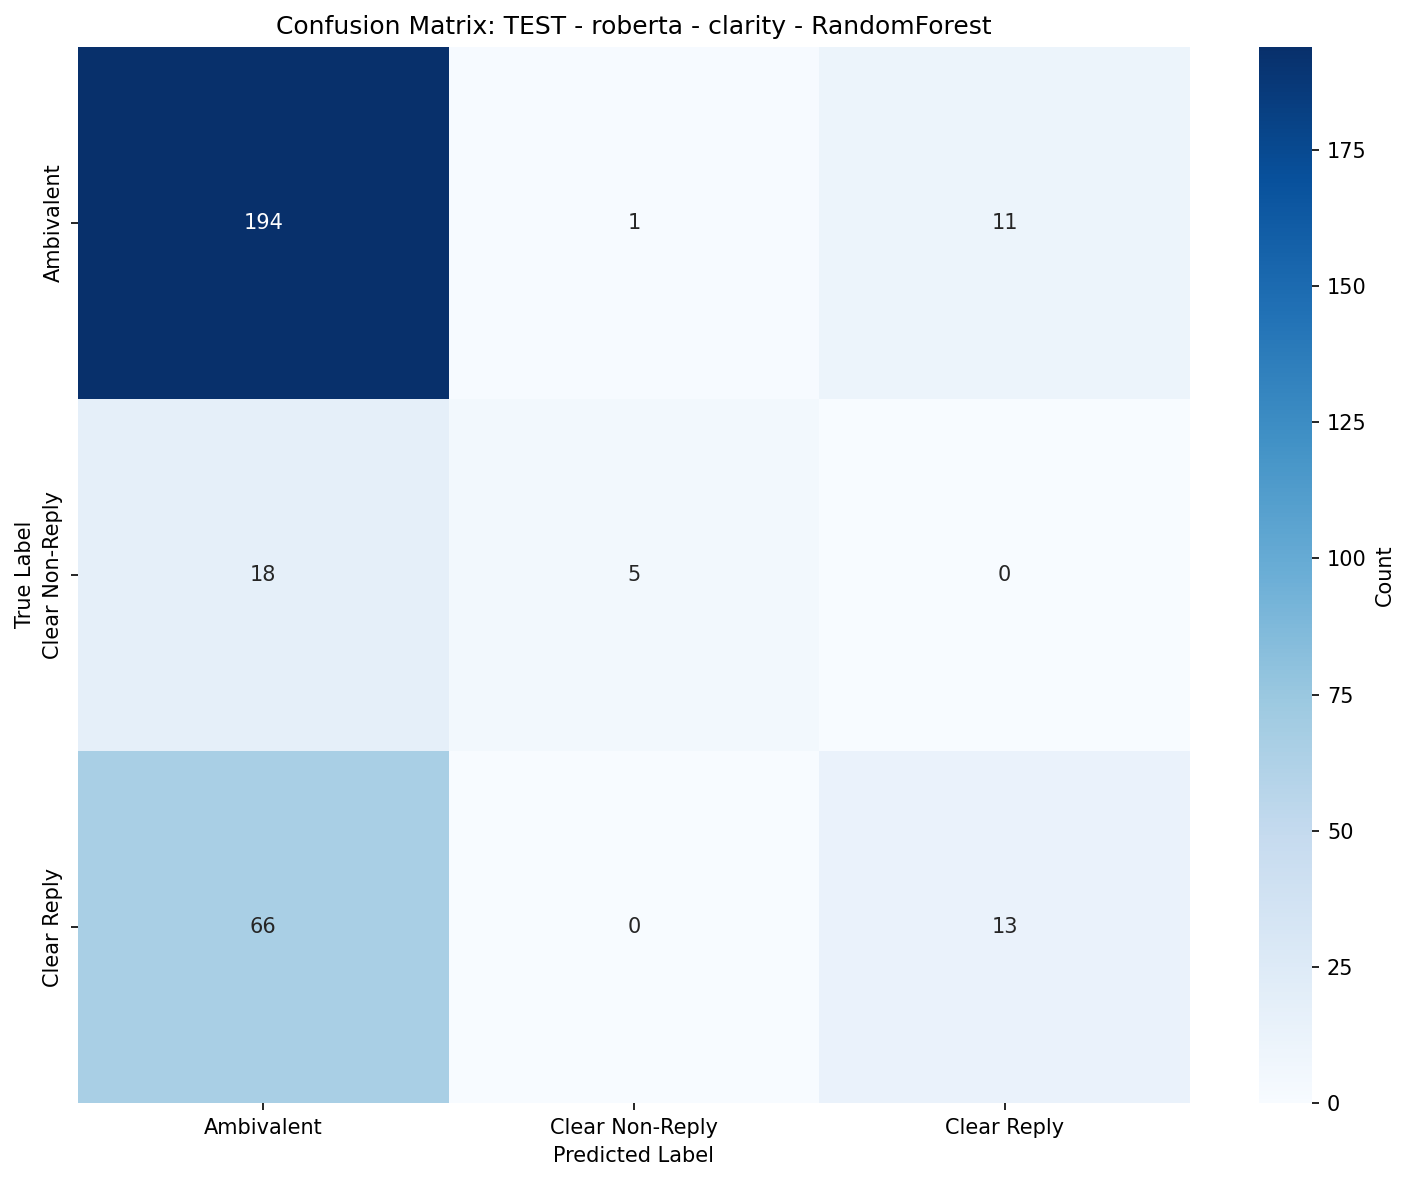


    Training MLP...

Classification Report: TEST - roberta - clarity - MLP
                 precision    recall  f1-score   support

     Ambivalent     0.6871    0.9806    0.8080       206
Clear Non-Reply     0.6000    0.1304    0.2143        23
    Clear Reply     0.5556    0.0633    0.1136        79

       accuracy                         0.6818       308
      macro avg     0.6142    0.3914    0.3786       308
   weighted avg     0.6468    0.6818    0.5856       308




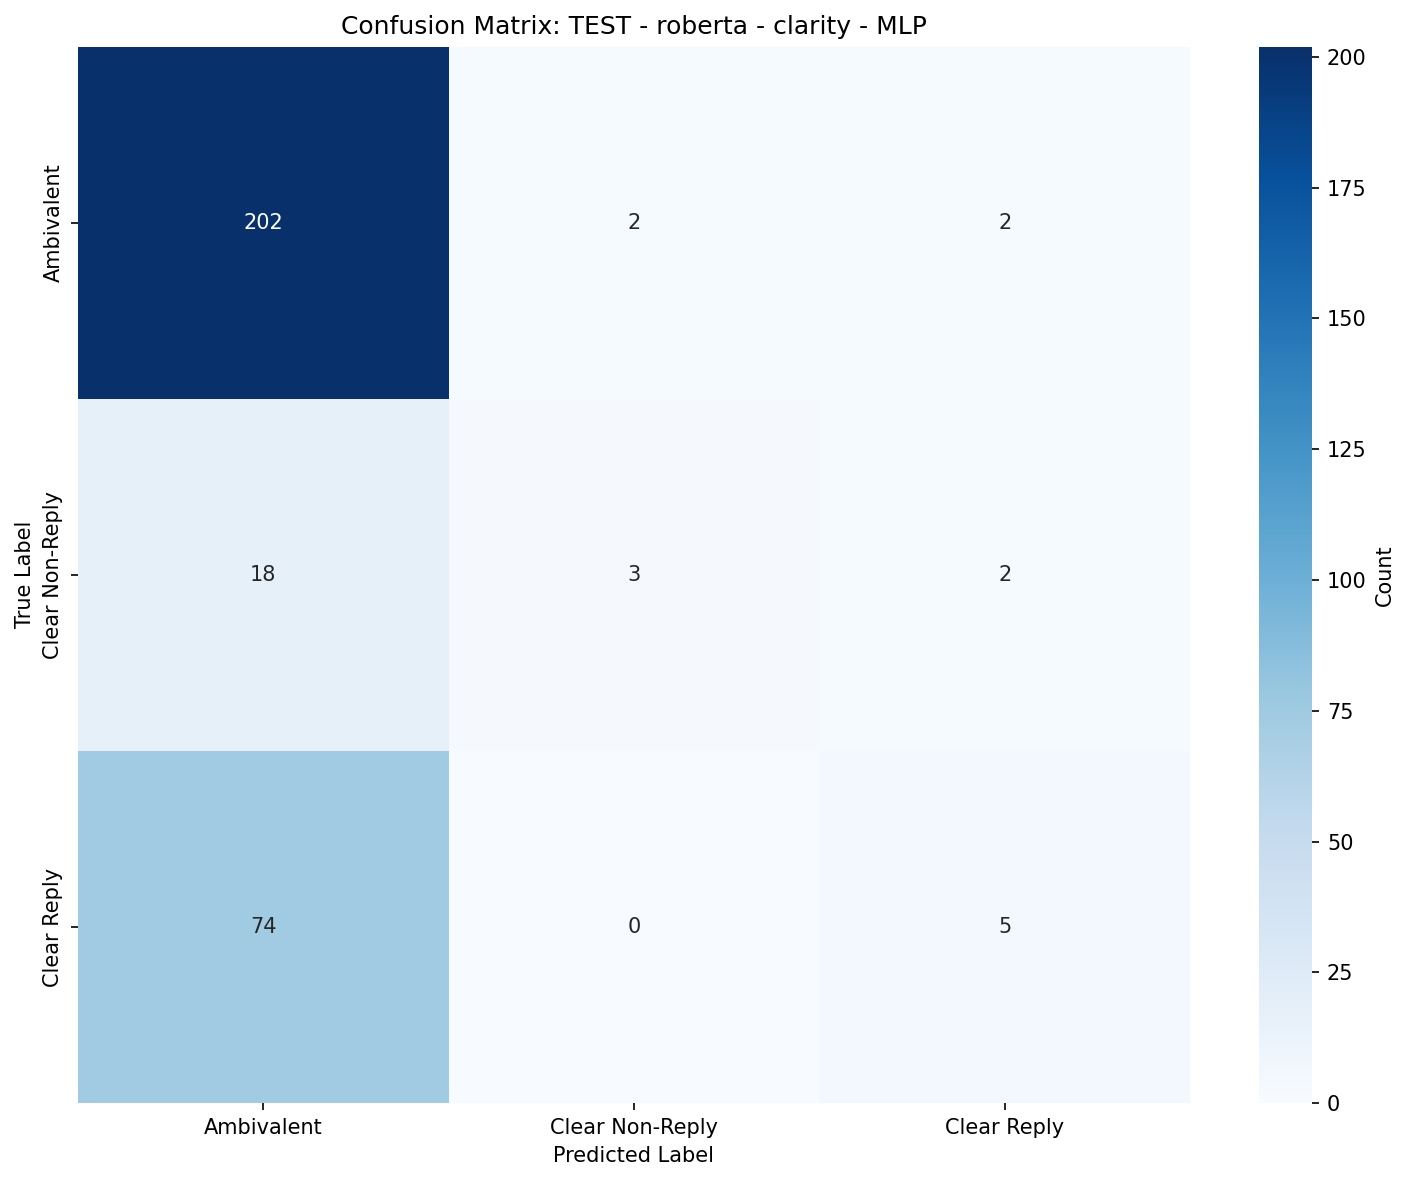


    Training XGBoost...

Classification Report: TEST - roberta - clarity - XGBoost
                 precision    recall  f1-score   support

     Ambivalent     0.7004    0.8738    0.7775       206
Clear Non-Reply     0.6667    0.1739    0.2759        23
    Clear Reply     0.4000    0.2278    0.2903        79

       accuracy                         0.6558       308
      macro avg     0.5890    0.4252    0.4479       308
   weighted avg     0.6208    0.6558    0.6151       308




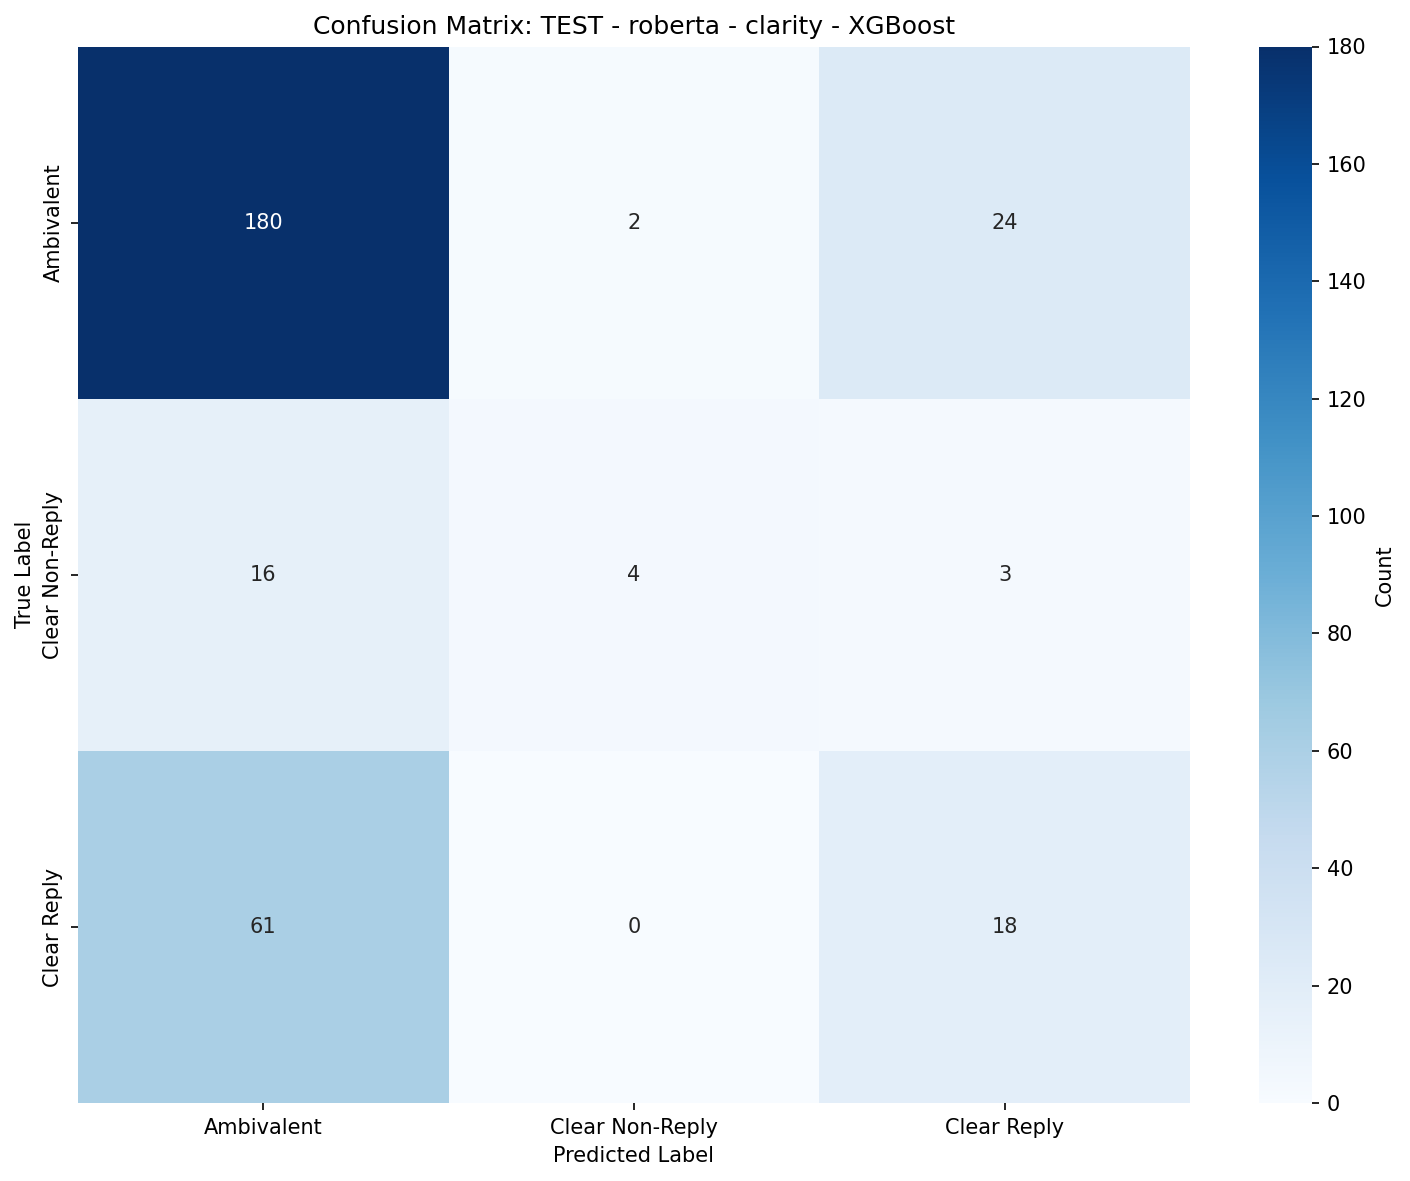


    Training LightGBM...

Classification Report: TEST - roberta - clarity - LightGBM
                 precision    recall  f1-score   support

     Ambivalent     0.6974    0.9175    0.7925       206
Clear Non-Reply     1.0000    0.2174    0.3571        23
    Clear Reply     0.4062    0.1646    0.2342        79

       accuracy                         0.6721       308
      macro avg     0.7012    0.4331    0.4613       308
   weighted avg     0.6453    0.6721    0.6168       308




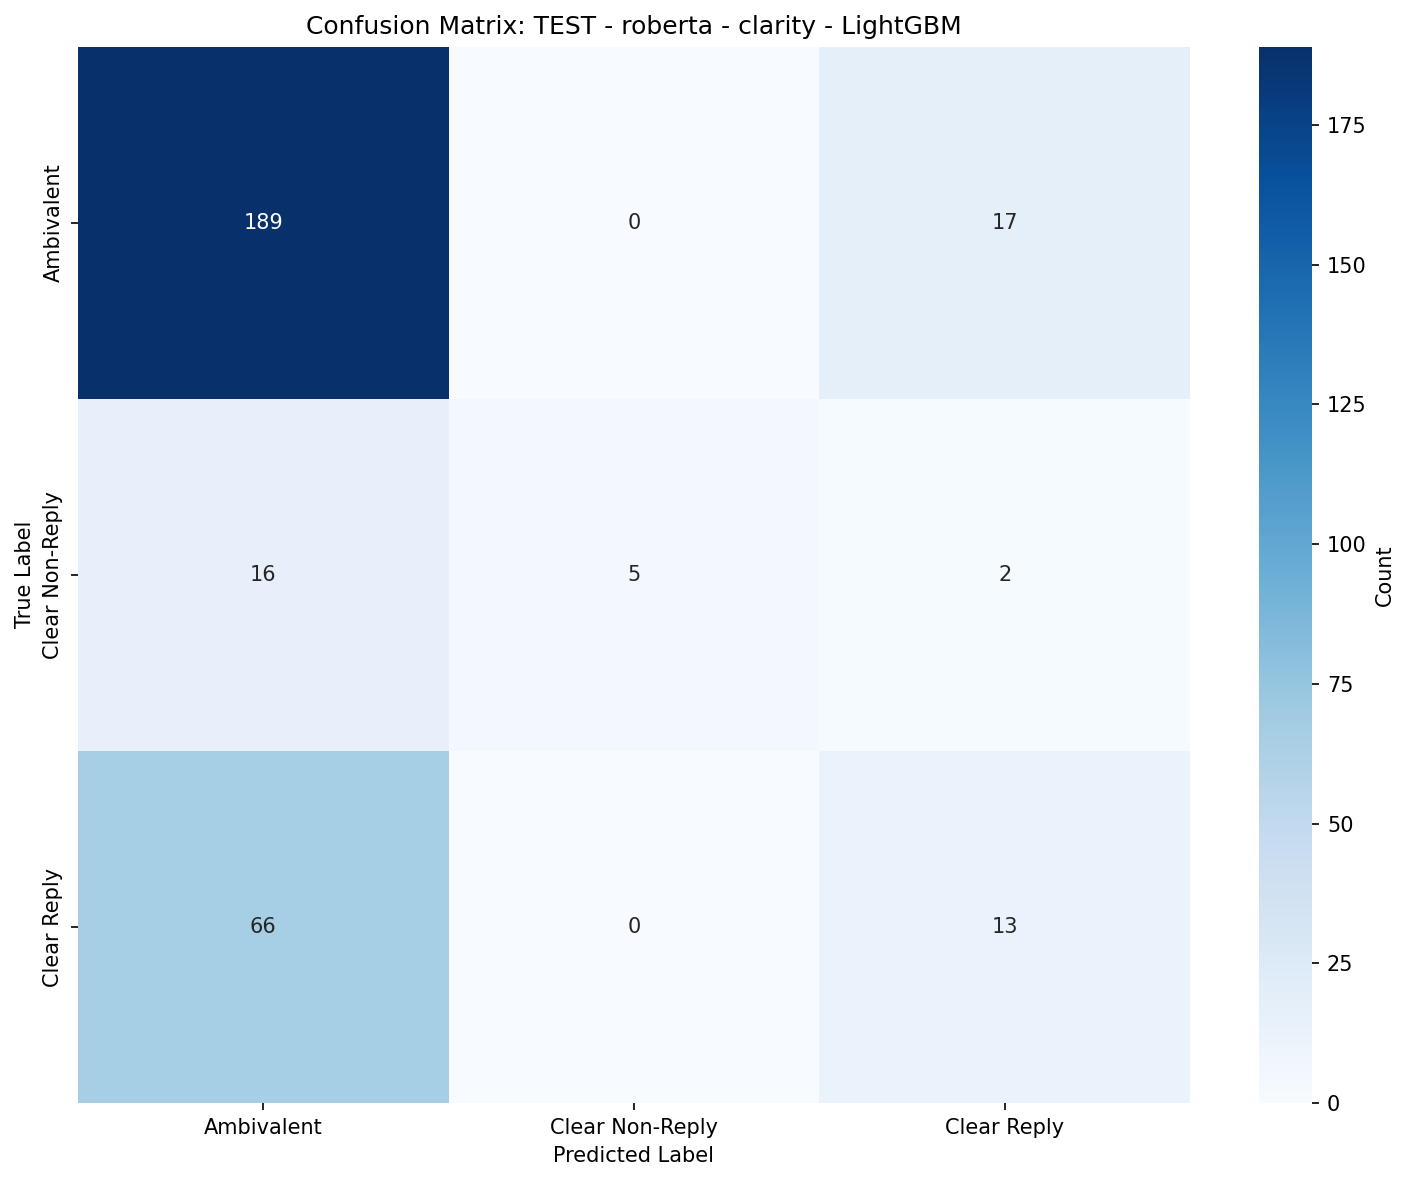


Results Table: TEST - roberta - clarity
        Classifier                     Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest TEST - roberta - clarity  0.688312  0.466303     0.626666         0.690947      0.441232
          LightGBM TEST - roberta - clarity  0.672078  0.461277     0.616766         0.701222      0.433141
           XGBoost TEST - roberta - clarity  0.655844  0.447907     0.615107         0.589019      0.425183
LogisticRegression TEST - roberta - clarity  0.467532  0.407822     0.500057         0.419635      0.486354
         LinearSVC TEST - roberta - clarity  0.636364  0.407706     0.603177         0.437217      0.410271
               MLP TEST - roberta - clarity  0.681818  0.378641     0.585564         0.614210      0.391436

Per-Class Metrics: TEST - roberta - clarity - RandomForest (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent   0.697842 0.941748  0.801653      206
Clear Non-Repl

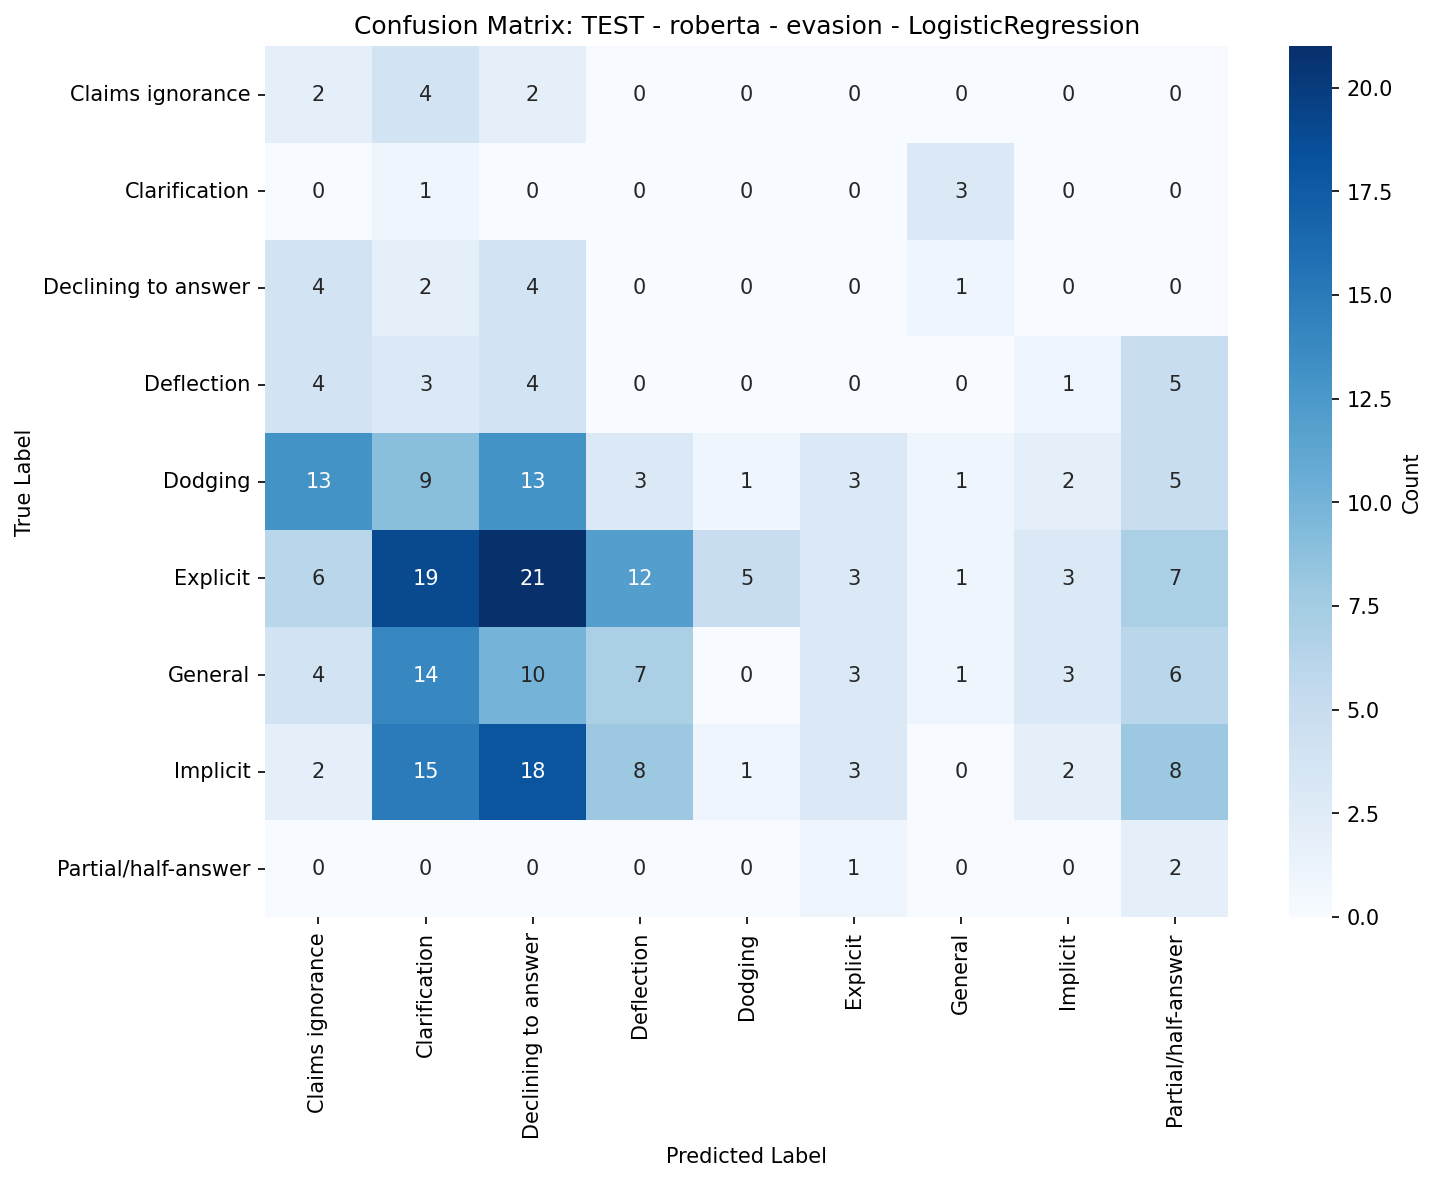


    Training LinearSVC...

Classification Report: TEST - roberta - evasion - LinearSVC
                     precision    recall  f1-score   support

   Claims ignorance     0.1429    0.2500    0.1818         8
      Clarification     0.0204    0.2500    0.0377         4
Declining to answer     0.2000    0.0909    0.1250        11
         Deflection     0.0476    0.0588    0.0526        17
            Dodging     0.1429    0.0800    0.1026        50
           Explicit     0.2800    0.4545    0.3465        77
            General     0.2500    0.0208    0.0385        48
           Implicit     0.0000    0.0000    0.0000        57
Partial/half-answer     0.0417    0.3333    0.0741         3

           accuracy                         0.1673       275
          macro avg     0.1250    0.1709    0.1065       275
       weighted avg     0.1639    0.1673    0.1373       275




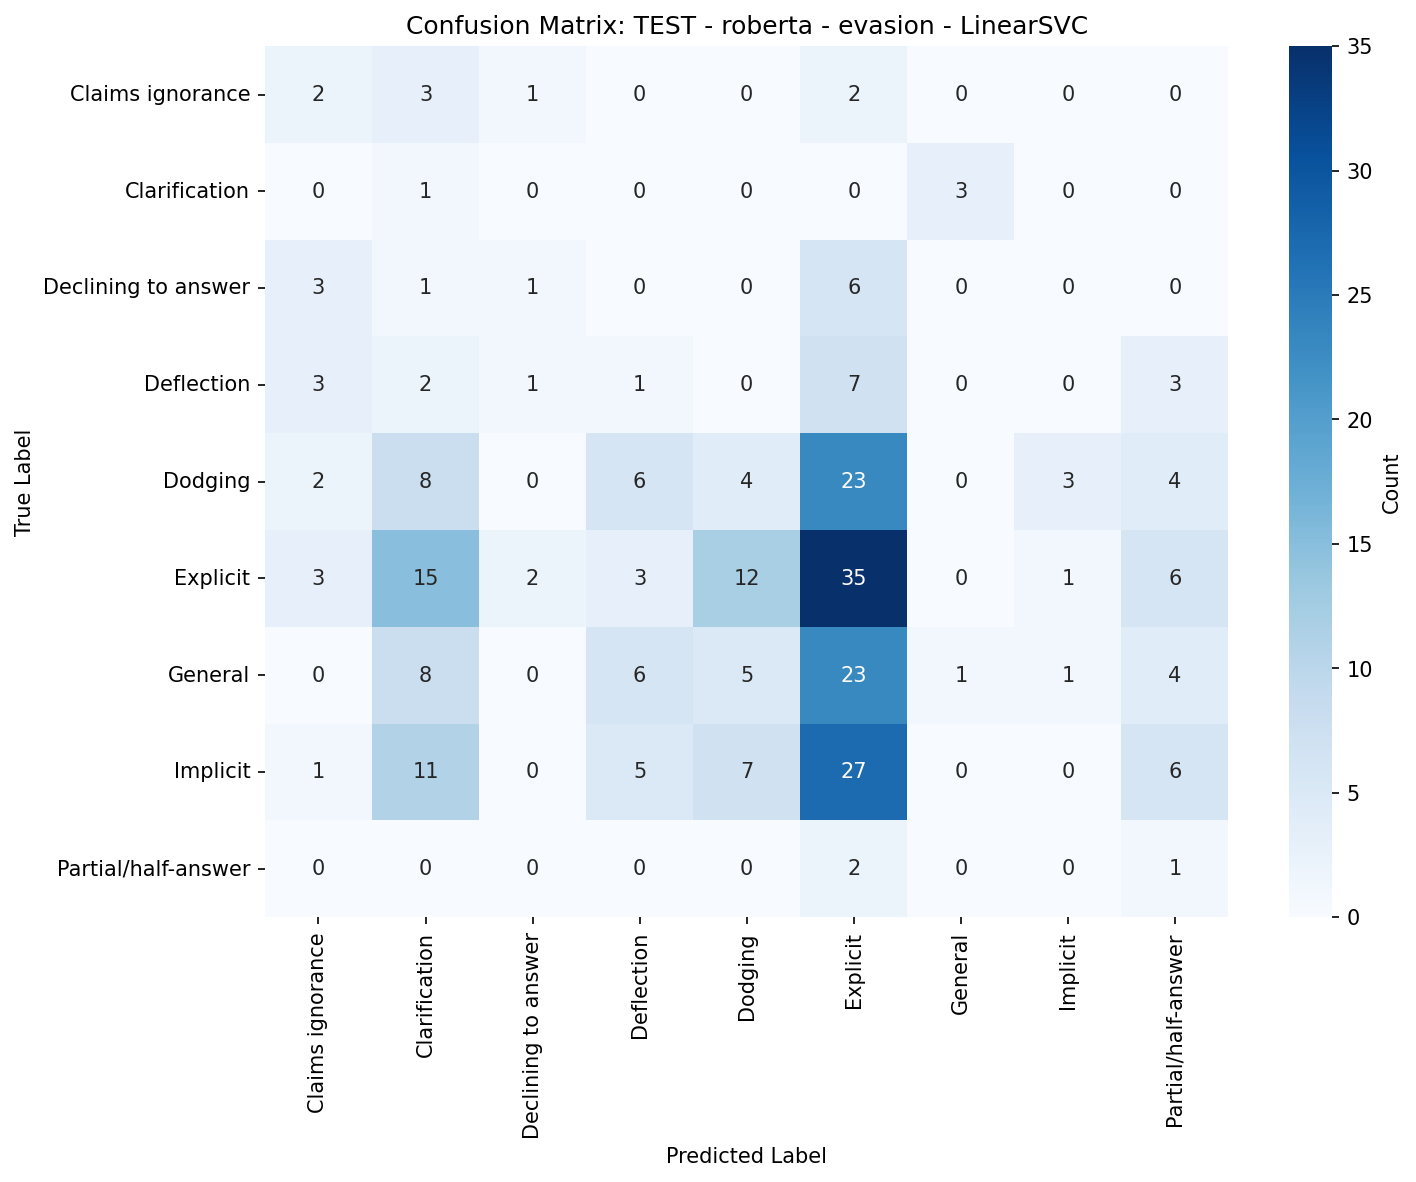


    Training RandomForest...

Classification Report: TEST - roberta - evasion - RandomForest
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.2500    0.1176    0.1600        17
            Dodging     0.1163    0.1000    0.1075        50
           Explicit     0.2732    0.7273    0.3972        77
            General     0.2000    0.0417    0.0690        48
           Implicit     0.0000    0.0000    0.0000        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2364       275
          macro avg     0.0933    0.1096    0.0815       275
       weighted avg     0.1480    0.2364    0.1527       275




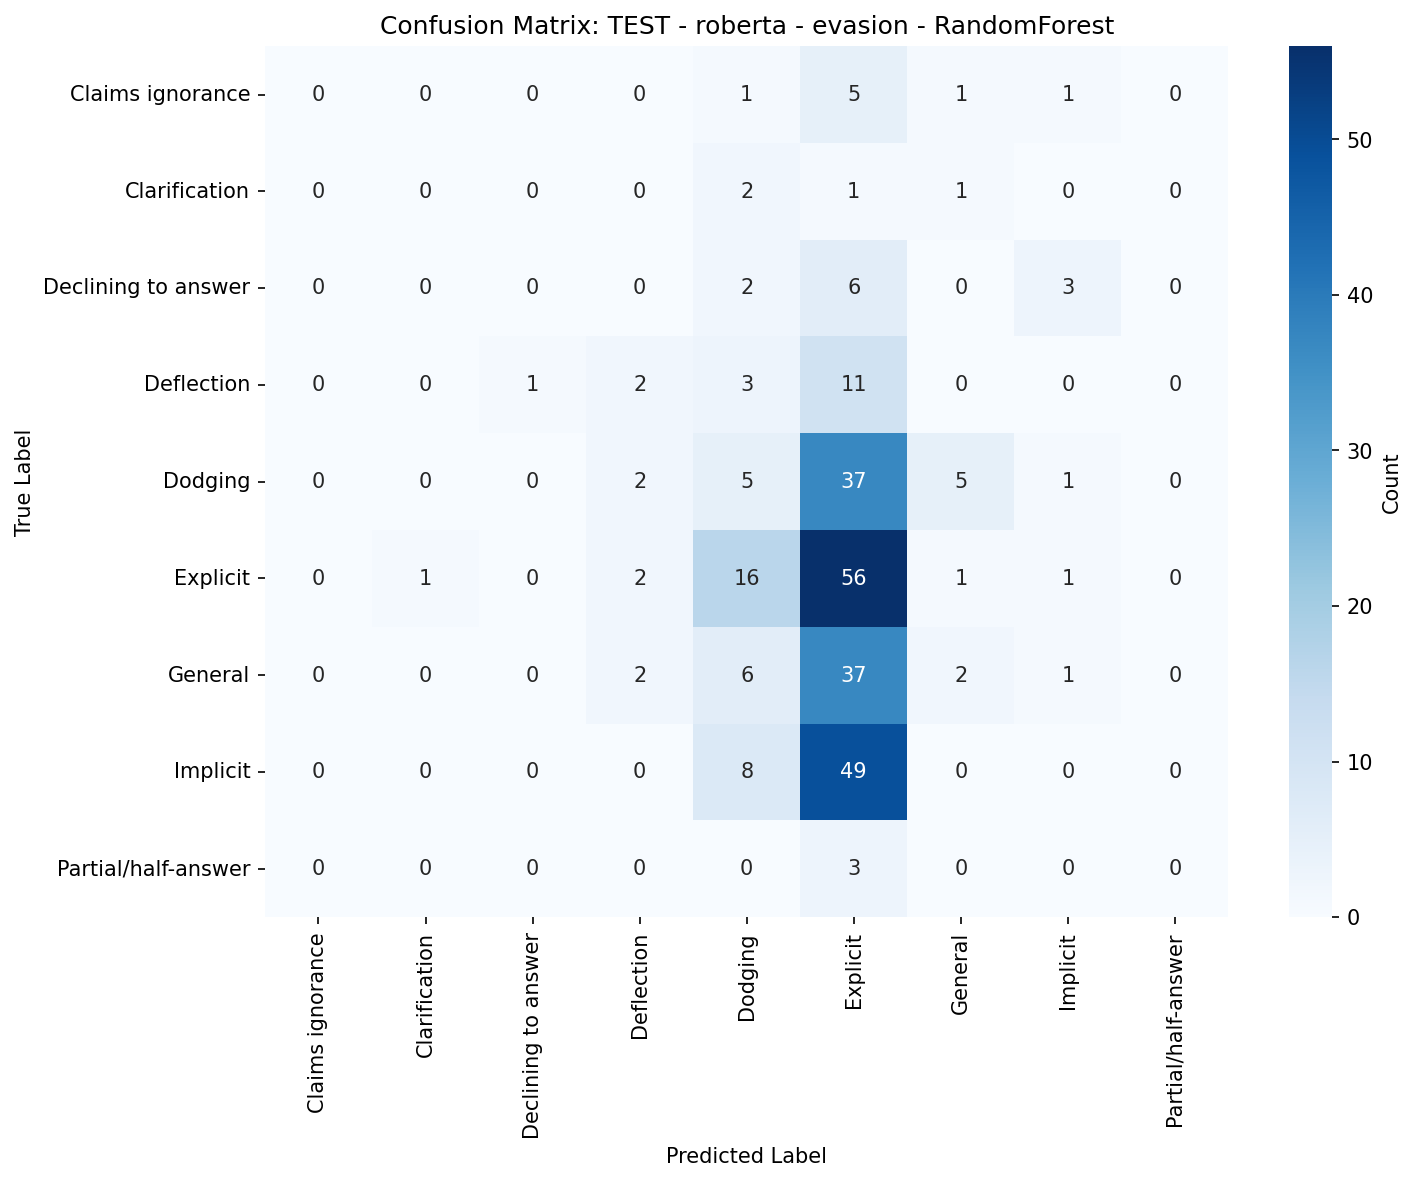


    Training MLP...

Classification Report: TEST - roberta - evasion - MLP
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0000    0.0000    0.0000        17
            Dodging     0.6000    0.0600    0.1091        50
           Explicit     0.2778    0.9740    0.4323        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.0000    0.0000    0.0000        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2836       275
          macro avg     0.0975    0.1149    0.0602       275
       weighted avg     0.1869    0.2836    0.1409       275




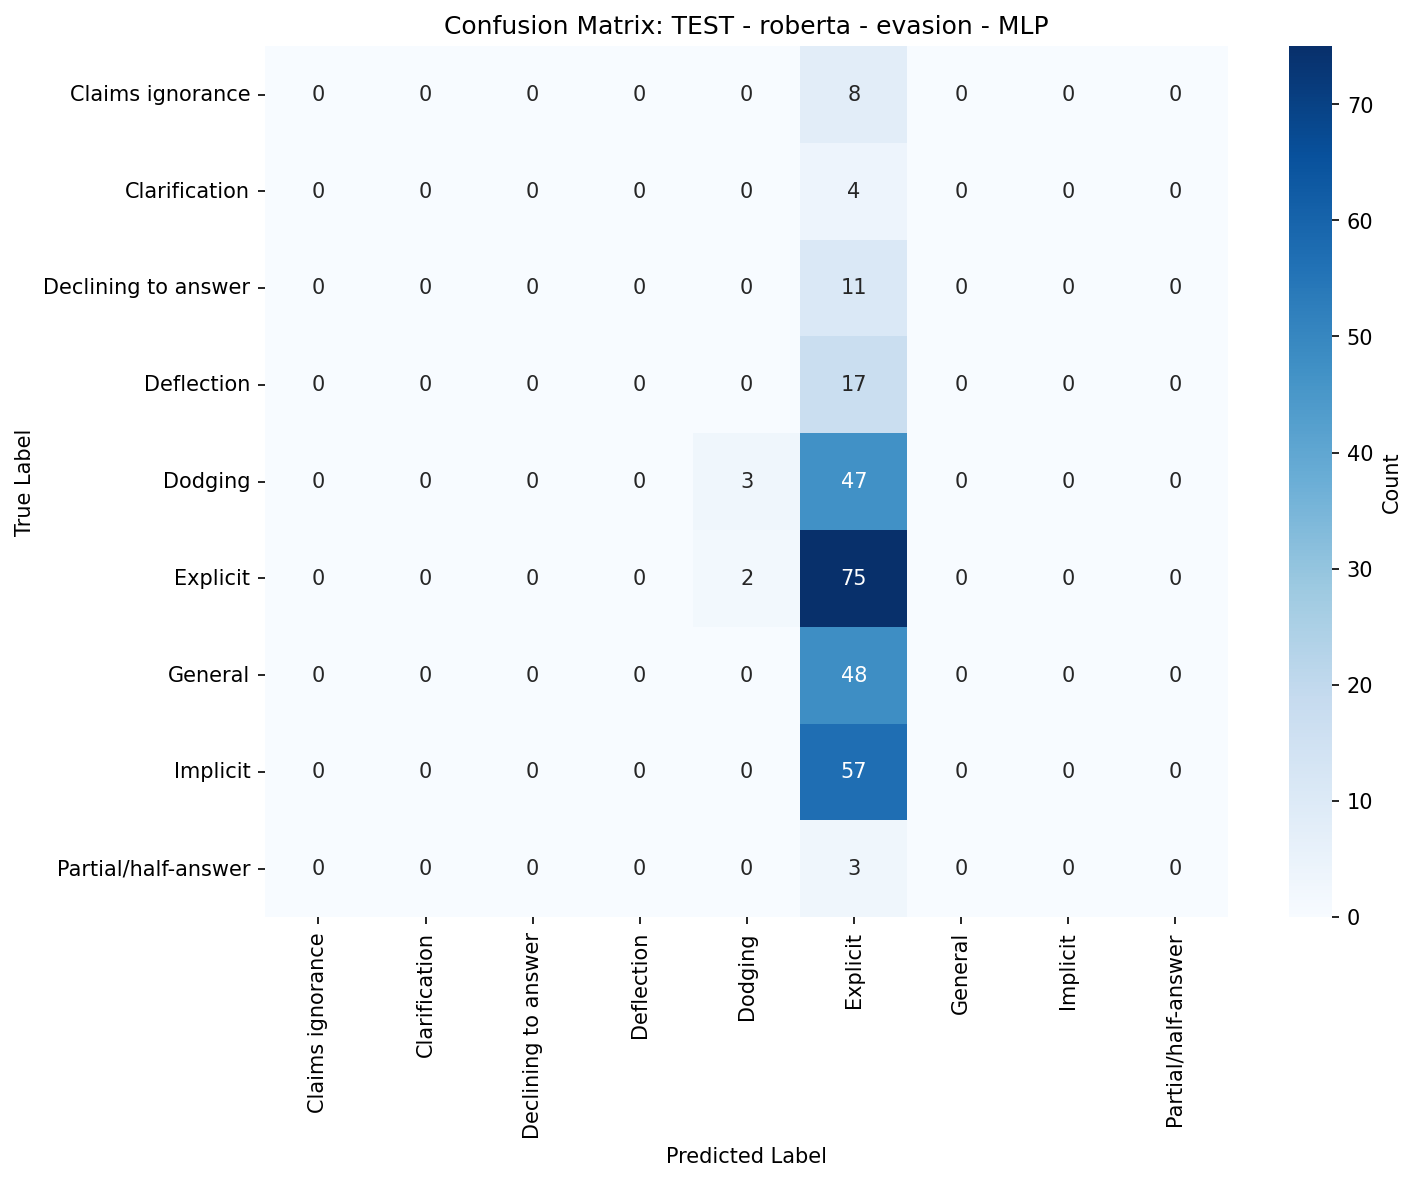


    Training XGBoost...

Classification Report: TEST - roberta - evasion - XGBoost
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.3333    0.2941    0.3125        17
            Dodging     0.1636    0.1800    0.1714        50
           Explicit     0.2649    0.6364    0.3740        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.3333    0.0702    0.1159        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2436       275
          macro avg     0.1217    0.1312    0.1082       275
       weighted avg     0.1936    0.2436    0.1793       275




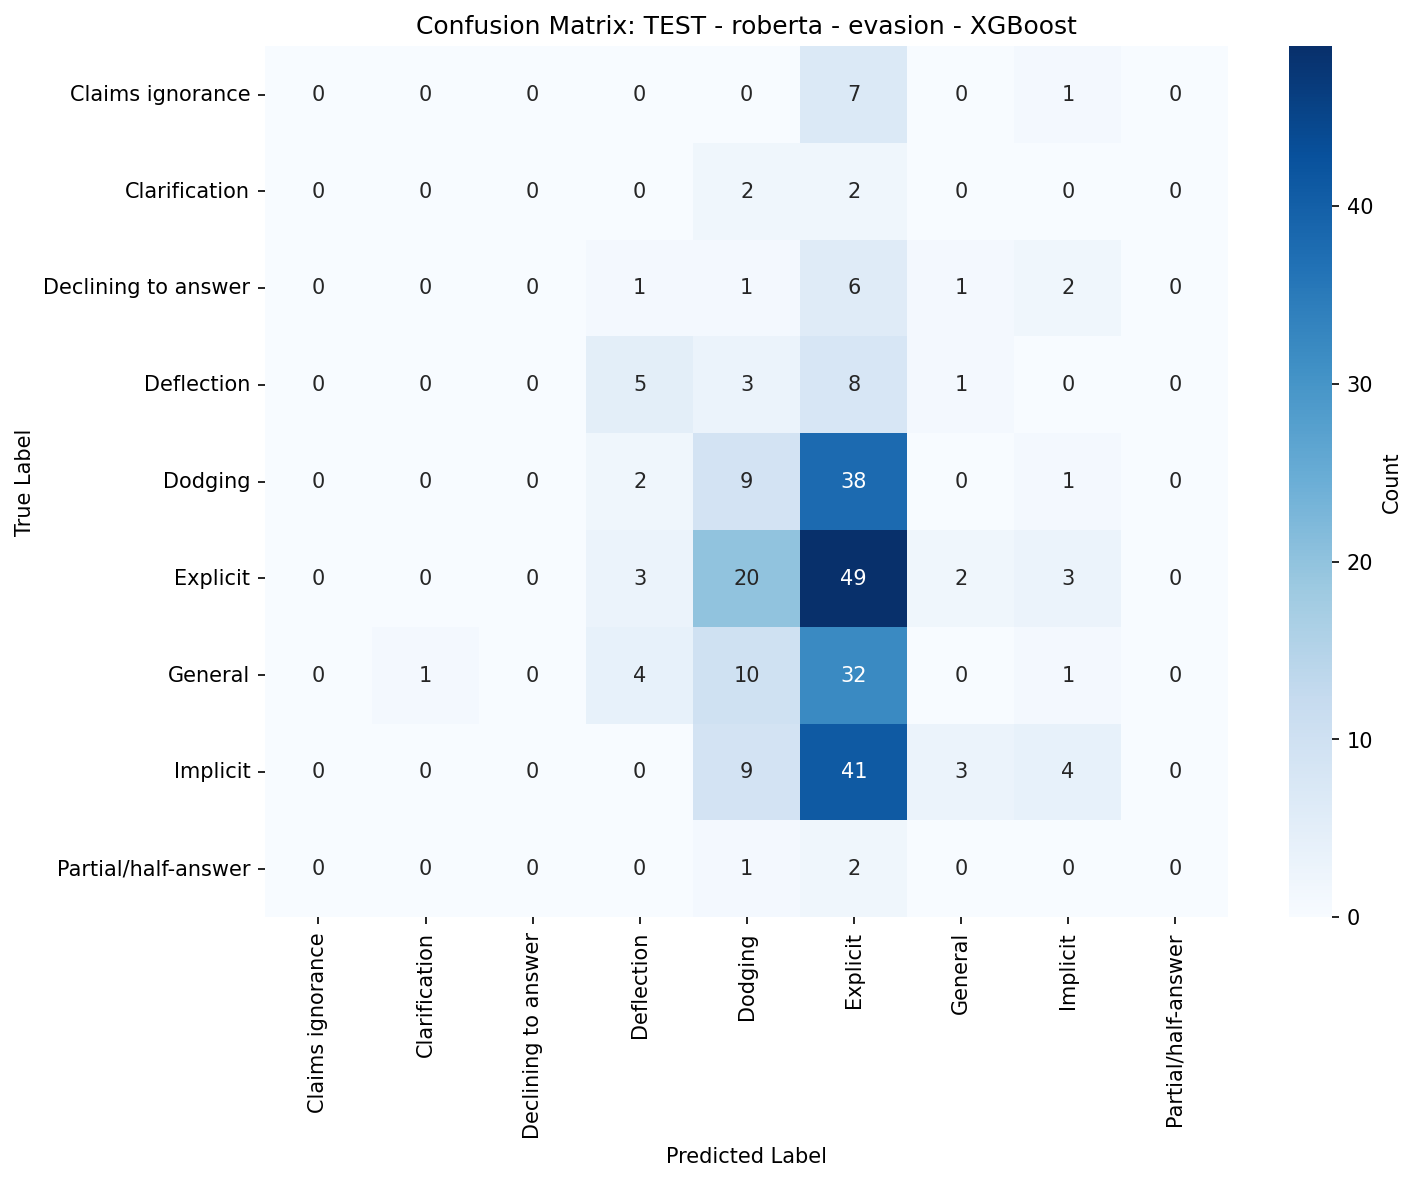


    Training LightGBM...

Classification Report: TEST - roberta - evasion - LightGBM
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.5000    0.2353    0.3200        17
            Dodging     0.2075    0.2200    0.2136        50
           Explicit     0.2798    0.7013    0.4000        77
            General     0.1429    0.0208    0.0364        48
           Implicit     0.1429    0.0351    0.0563        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2618       275
          macro avg     0.1415    0.1347    0.1140       275
       weighted avg     0.2015    0.2618    0.1886       275




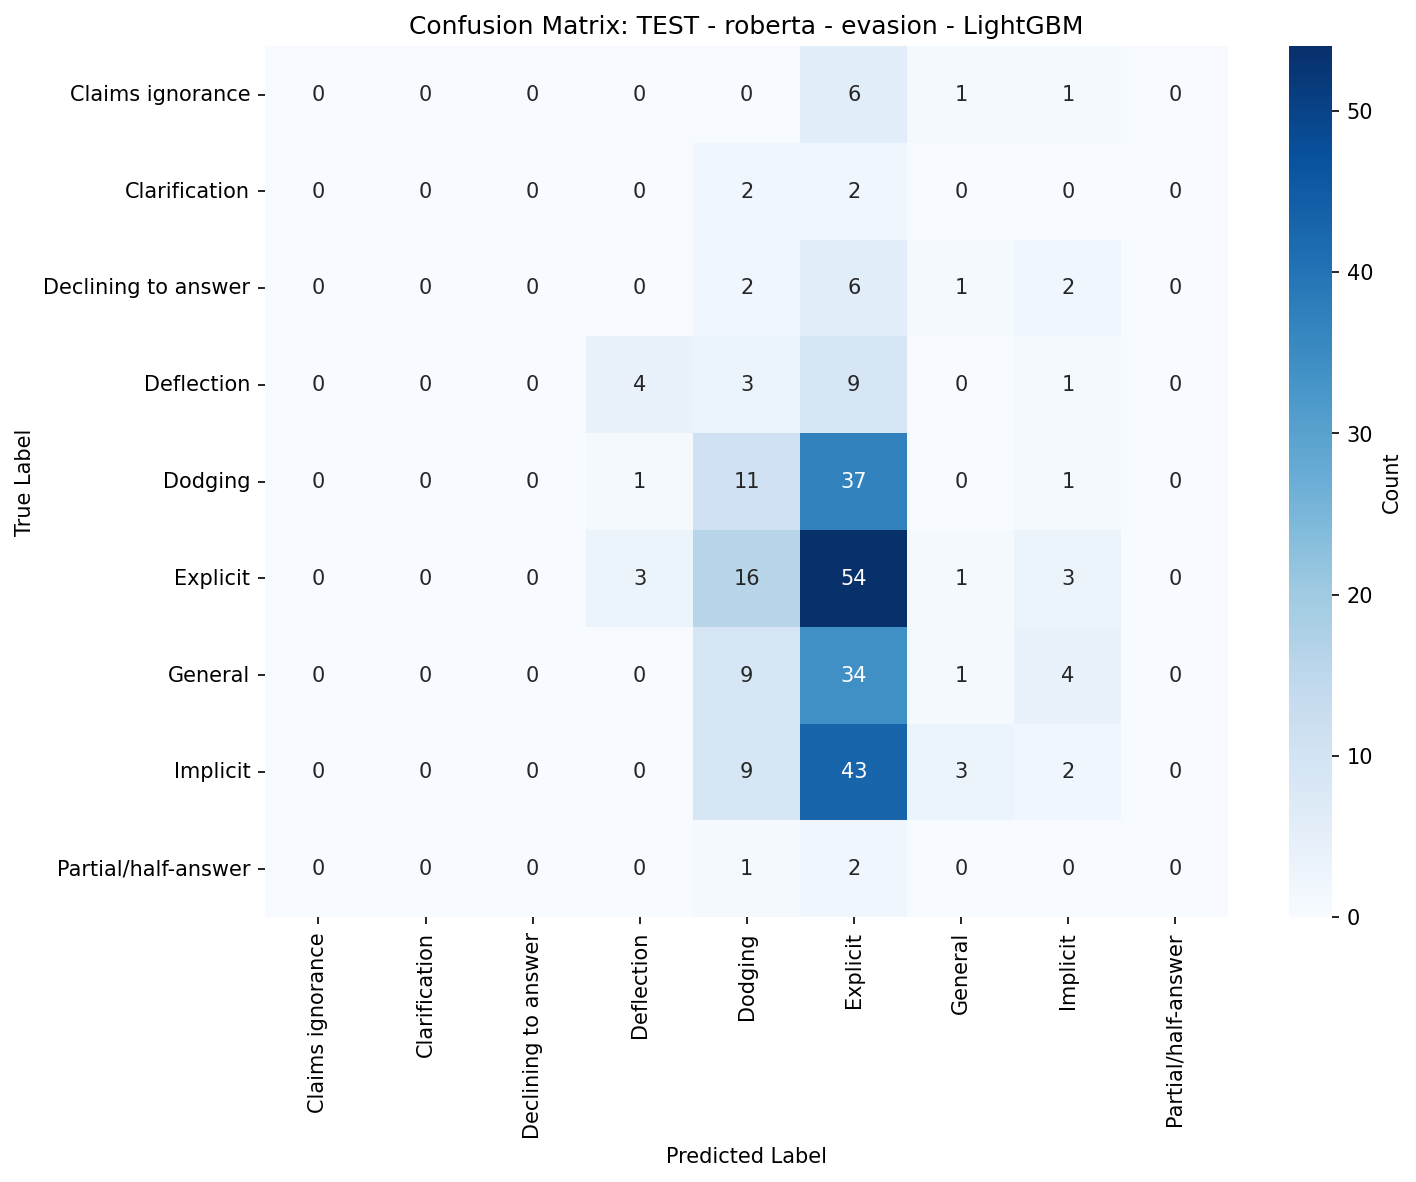


Results Table: TEST - roberta - evasion
        Classifier                     Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
          LightGBM TEST - roberta - evasion  0.261818  0.114033     0.188641         0.141450      0.134724
           XGBoost TEST - roberta - evasion  0.243636  0.108213     0.179251         0.121685      0.131184
         LinearSVC TEST - roberta - evasion  0.167273  0.106536     0.137291         0.125045      0.170938
      RandomForest TEST - roberta - evasion  0.236364  0.081517     0.152685         0.093272      0.109621
               MLP TEST - roberta - evasion  0.283636  0.060152     0.140872         0.097531      0.114892
LogisticRegression TEST - roberta - evasion  0.058182  0.058403     0.051769         0.098504      0.182798

Per-Class Metrics: TEST - roberta - evasion - LightGBM (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.000000 0.000000  0.000000        8
      Clar

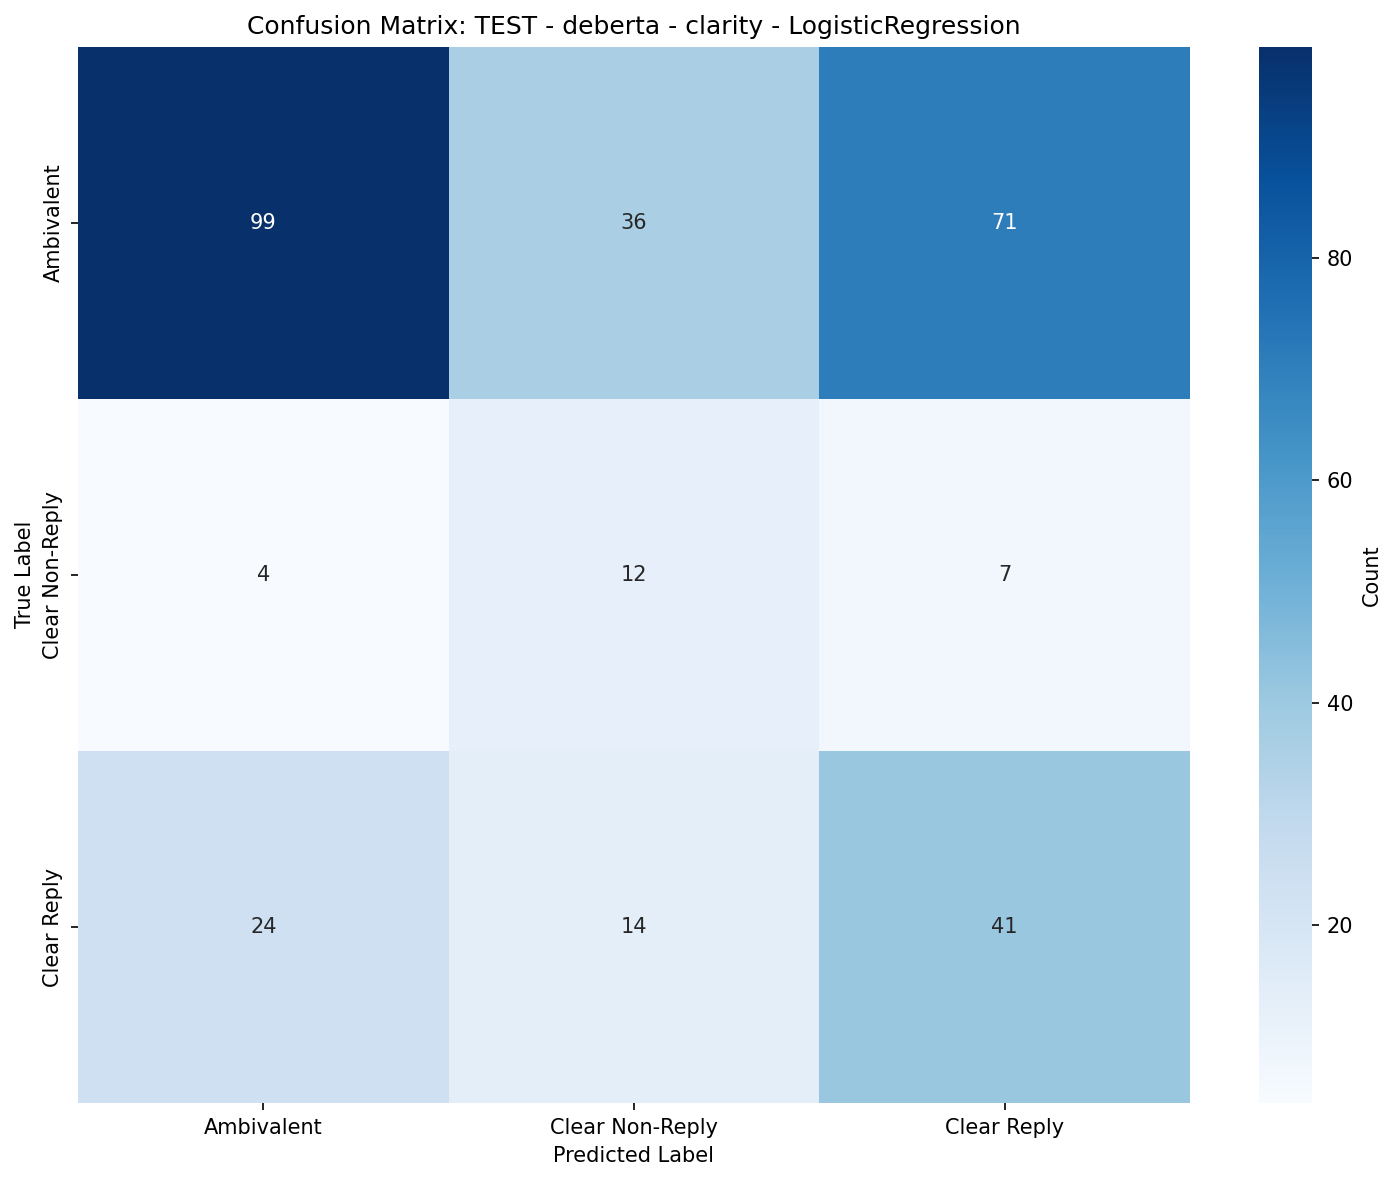


    Training LinearSVC...

Classification Report: TEST - deberta - clarity - LinearSVC
                 precision    recall  f1-score   support

     Ambivalent     0.7040    0.8544    0.7719       206
Clear Non-Reply     0.2273    0.2174    0.2222        23
    Clear Reply     0.4722    0.2152    0.2957        79

       accuracy                         0.6429       308
      macro avg     0.4678    0.4290    0.4299       308
   weighted avg     0.6090    0.6429    0.6087       308




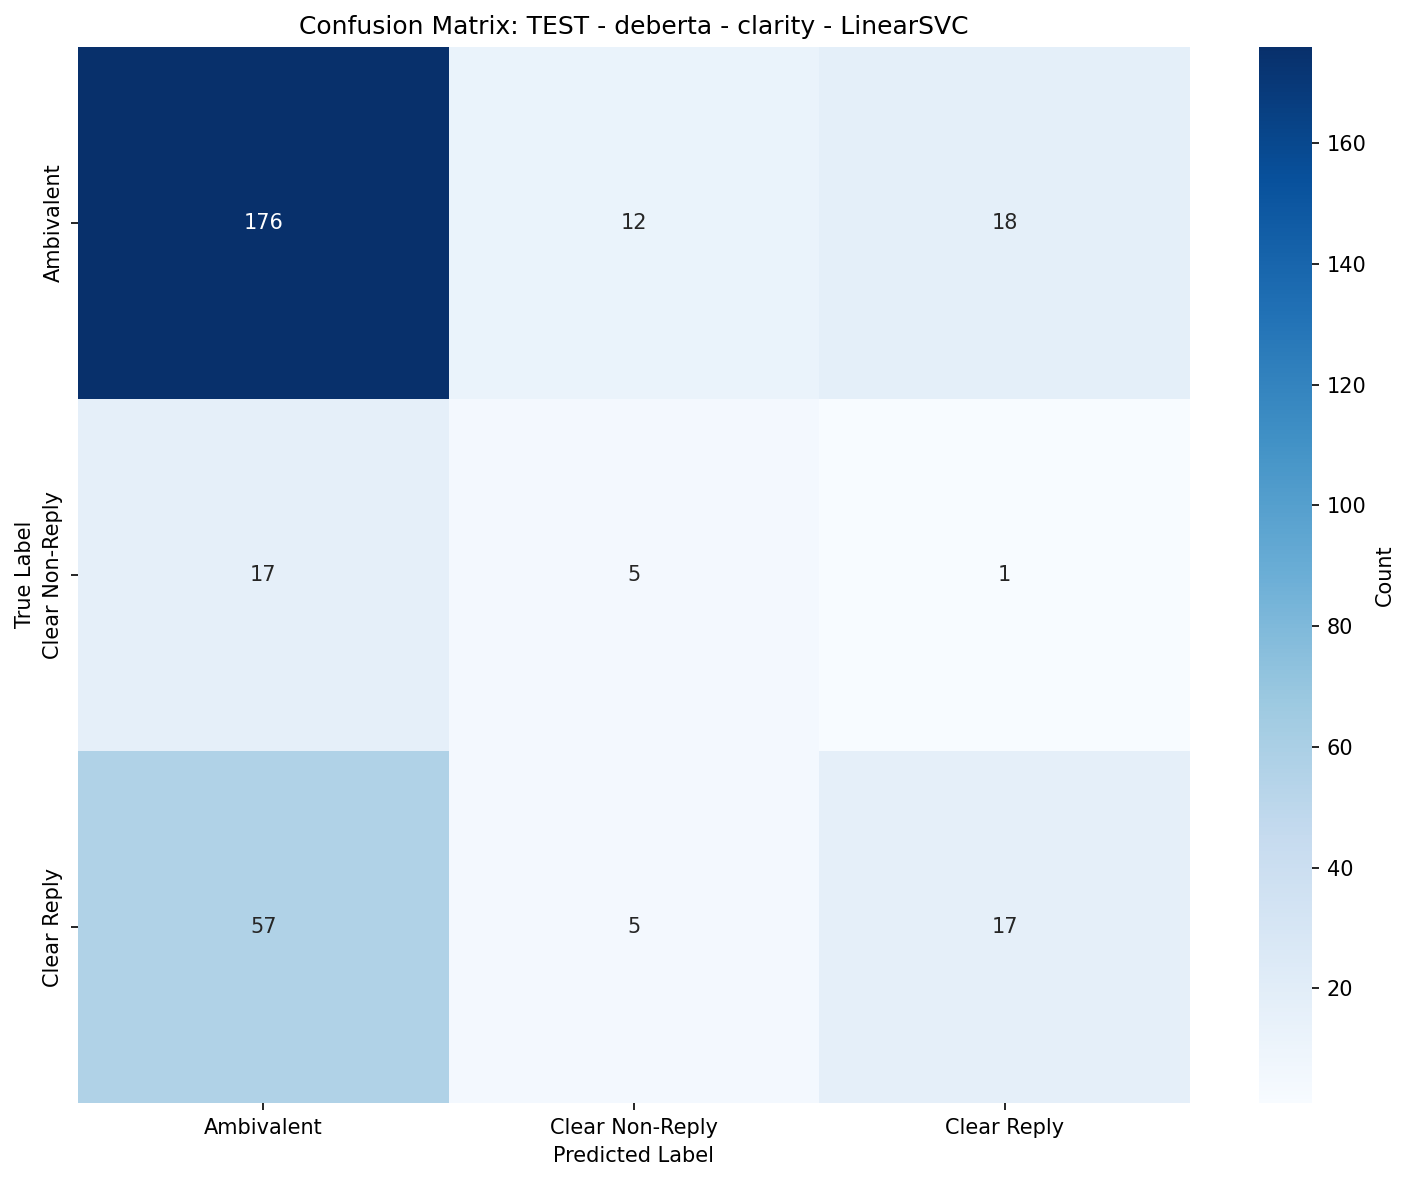


    Training RandomForest...

Classification Report: TEST - deberta - clarity - RandomForest
                 precision    recall  f1-score   support

     Ambivalent     0.6909    0.9223    0.7900       206
Clear Non-Reply     0.8000    0.1739    0.2857        23
    Clear Reply     0.3929    0.1392    0.2056        79

       accuracy                         0.6656       308
      macro avg     0.6279    0.4118    0.4271       308
   weighted avg     0.6226    0.6656    0.6025       308




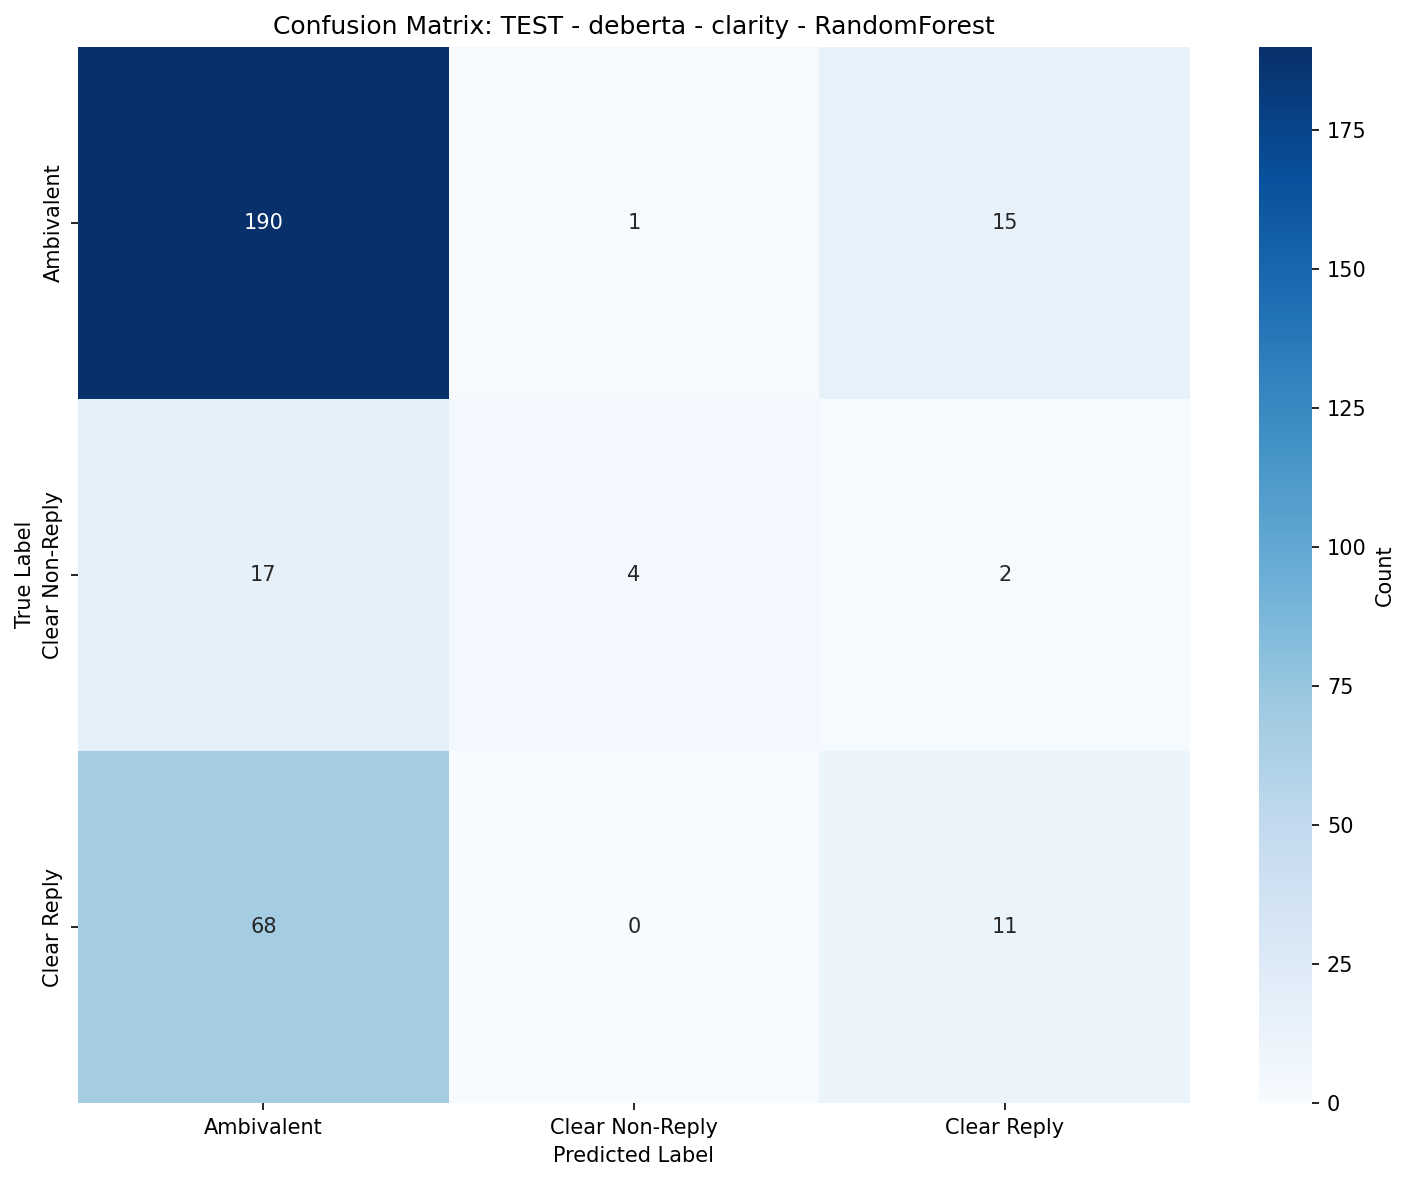


    Training MLP...

Classification Report: TEST - deberta - clarity - MLP
                 precision    recall  f1-score   support

     Ambivalent     0.6873    0.9709    0.8048       206
Clear Non-Reply     0.4286    0.1304    0.2000        23
    Clear Reply     0.6000    0.0759    0.1348        79

       accuracy                         0.6786       308
      macro avg     0.5720    0.3924    0.3799       308
   weighted avg     0.6456    0.6786    0.5878       308




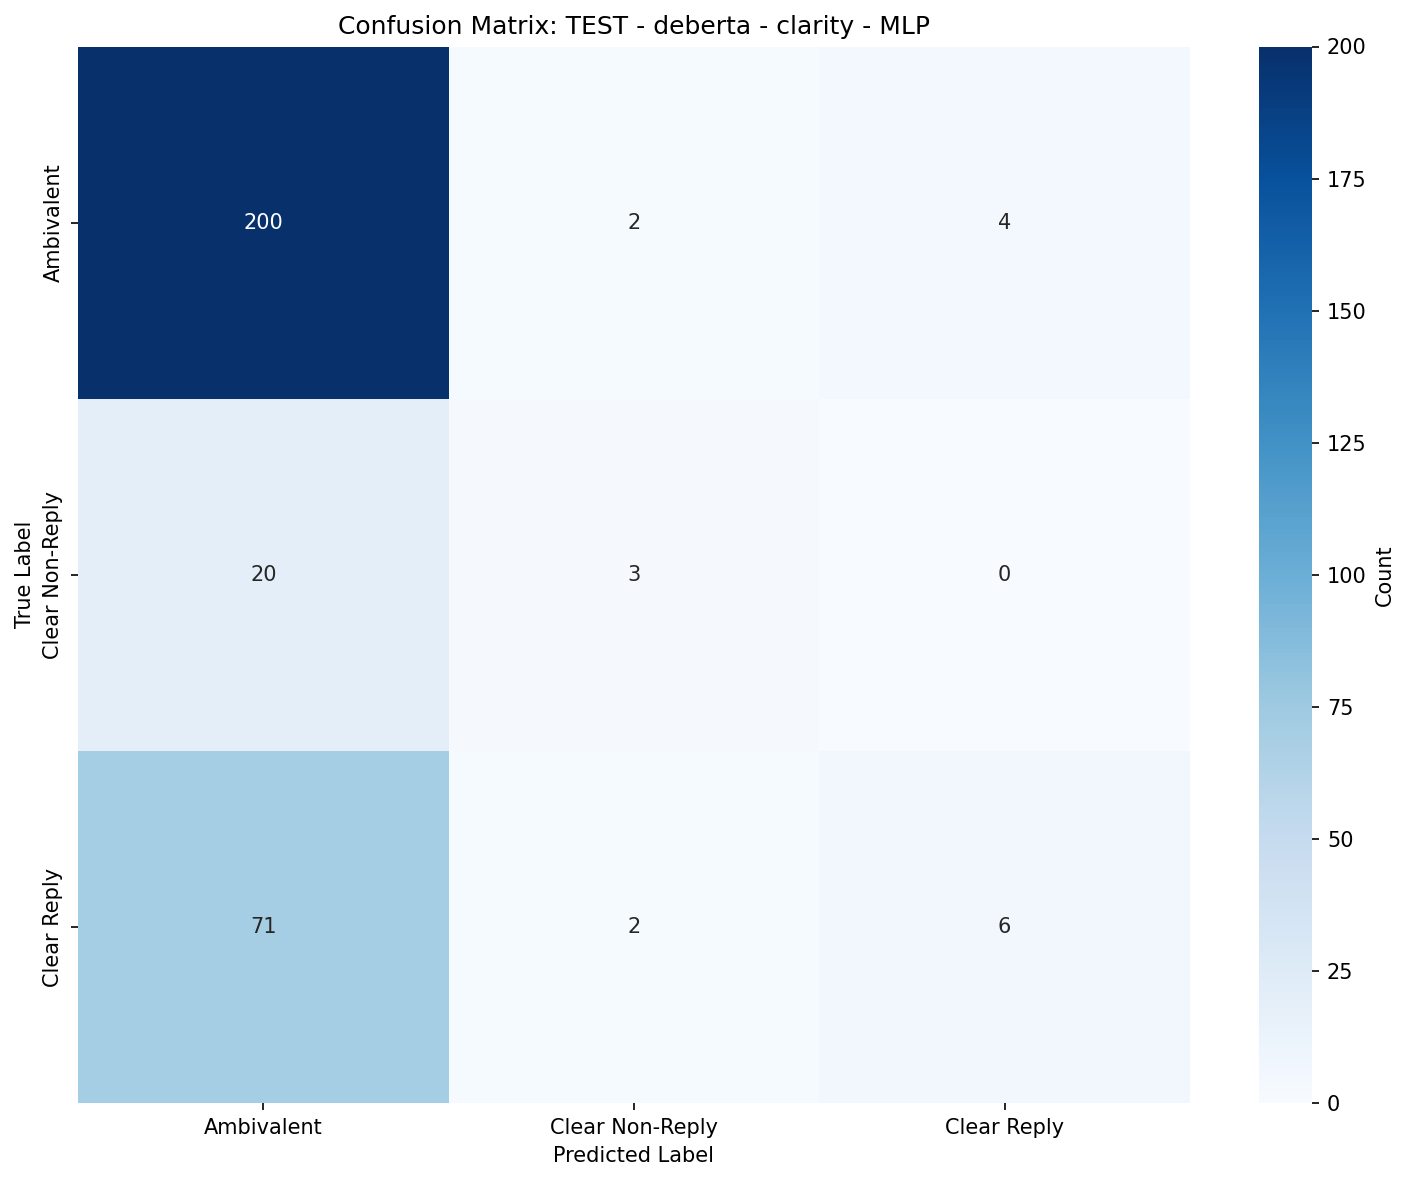


    Training XGBoost...

Classification Report: TEST - deberta - clarity - XGBoost
                 precision    recall  f1-score   support

     Ambivalent     0.7120    0.8641    0.7807       206
Clear Non-Reply     0.8333    0.2174    0.3448        23
    Clear Reply     0.3846    0.2532    0.3053        79

       accuracy                         0.6591       308
      macro avg     0.6433    0.4449    0.4770       308
   weighted avg     0.6371    0.6591    0.6262       308




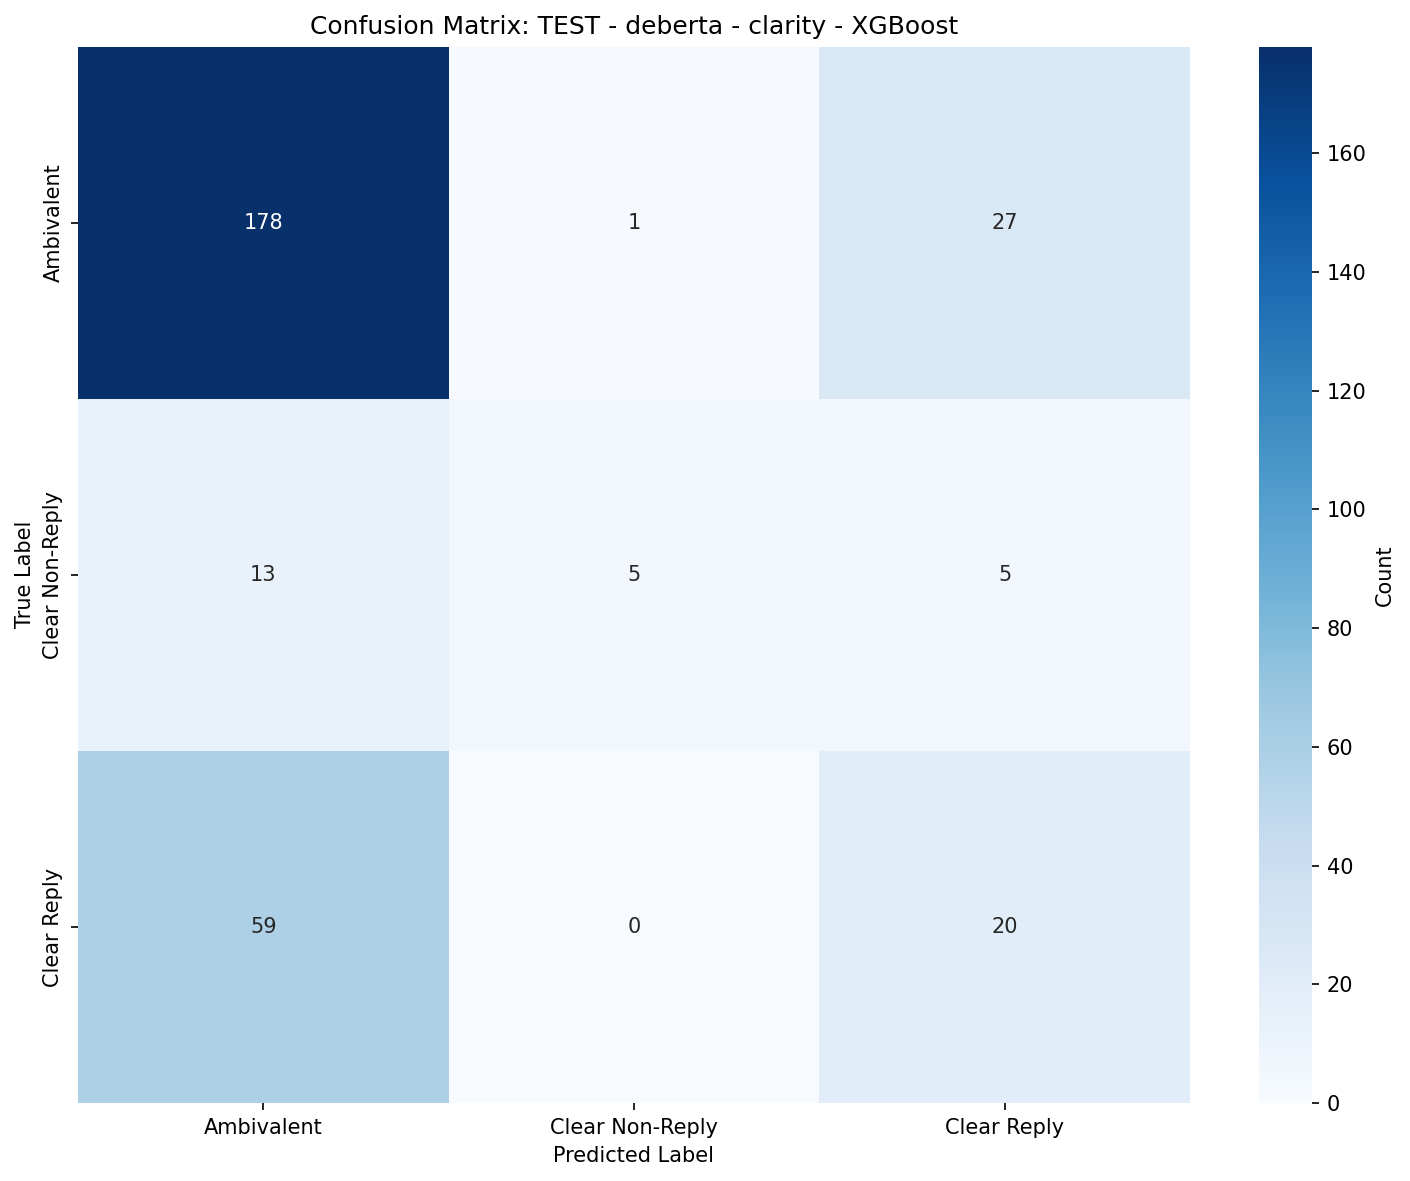


    Training LightGBM...

Classification Report: TEST - deberta - clarity - LightGBM
                 precision    recall  f1-score   support

     Ambivalent     0.7317    0.8738    0.7965       206
Clear Non-Reply     0.5556    0.2174    0.3125        23
    Clear Reply     0.4528    0.3038    0.3636        79

       accuracy                         0.6786       308
      macro avg     0.5800    0.4650    0.4909       308
   weighted avg     0.6470    0.6786    0.6493       308




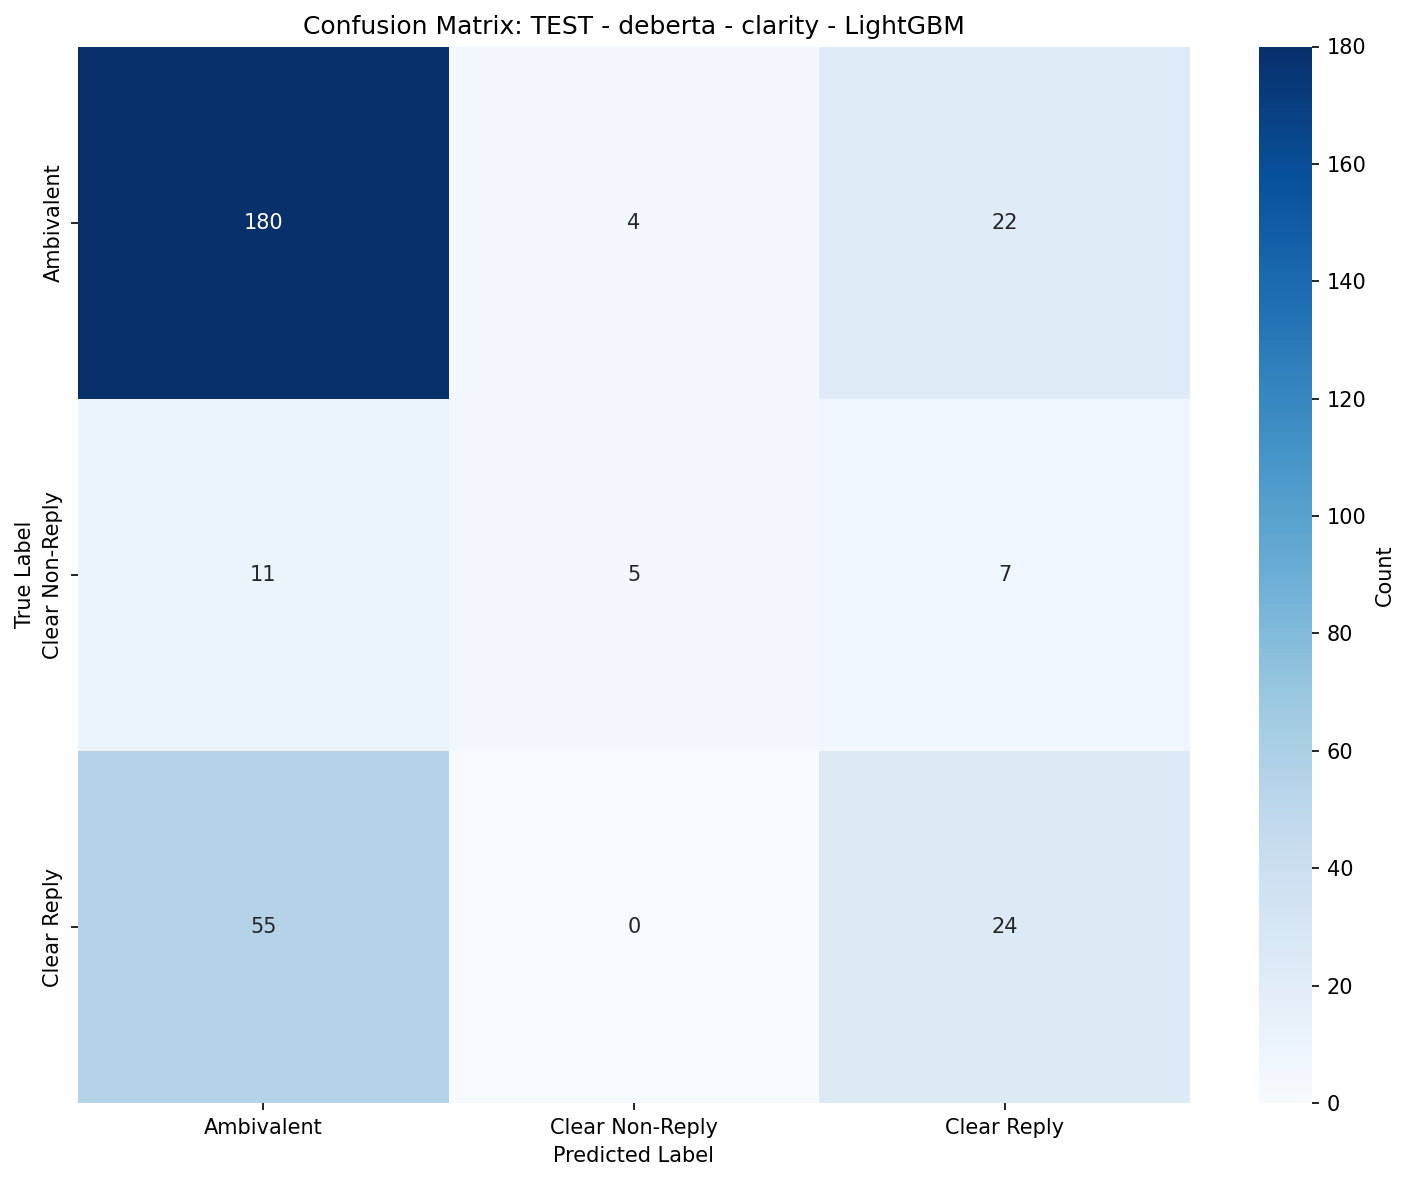


Results Table: TEST - deberta - clarity
        Classifier                     Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
          LightGBM TEST - deberta - clarity  0.678571  0.490866     0.649304         0.580031      0.464992
           XGBoost TEST - deberta - clarity  0.659091  0.476958     0.626226         0.643316      0.444878
LogisticRegression TEST - deberta - clarity  0.493506  0.430363     0.524993         0.439205      0.507103
         LinearSVC TEST - deberta - clarity  0.642857  0.429935     0.608718         0.467832      0.428983
      RandomForest TEST - deberta - clarity  0.665584  0.427114     0.602463         0.627922      0.411828
               MLP TEST - deberta - clarity  0.678571  0.379887     0.587813         0.571952      0.392419

Per-Class Metrics: TEST - deberta - clarity - LightGBM (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent   0.731707 0.873786  0.796460      206
Clear Non-Reply   

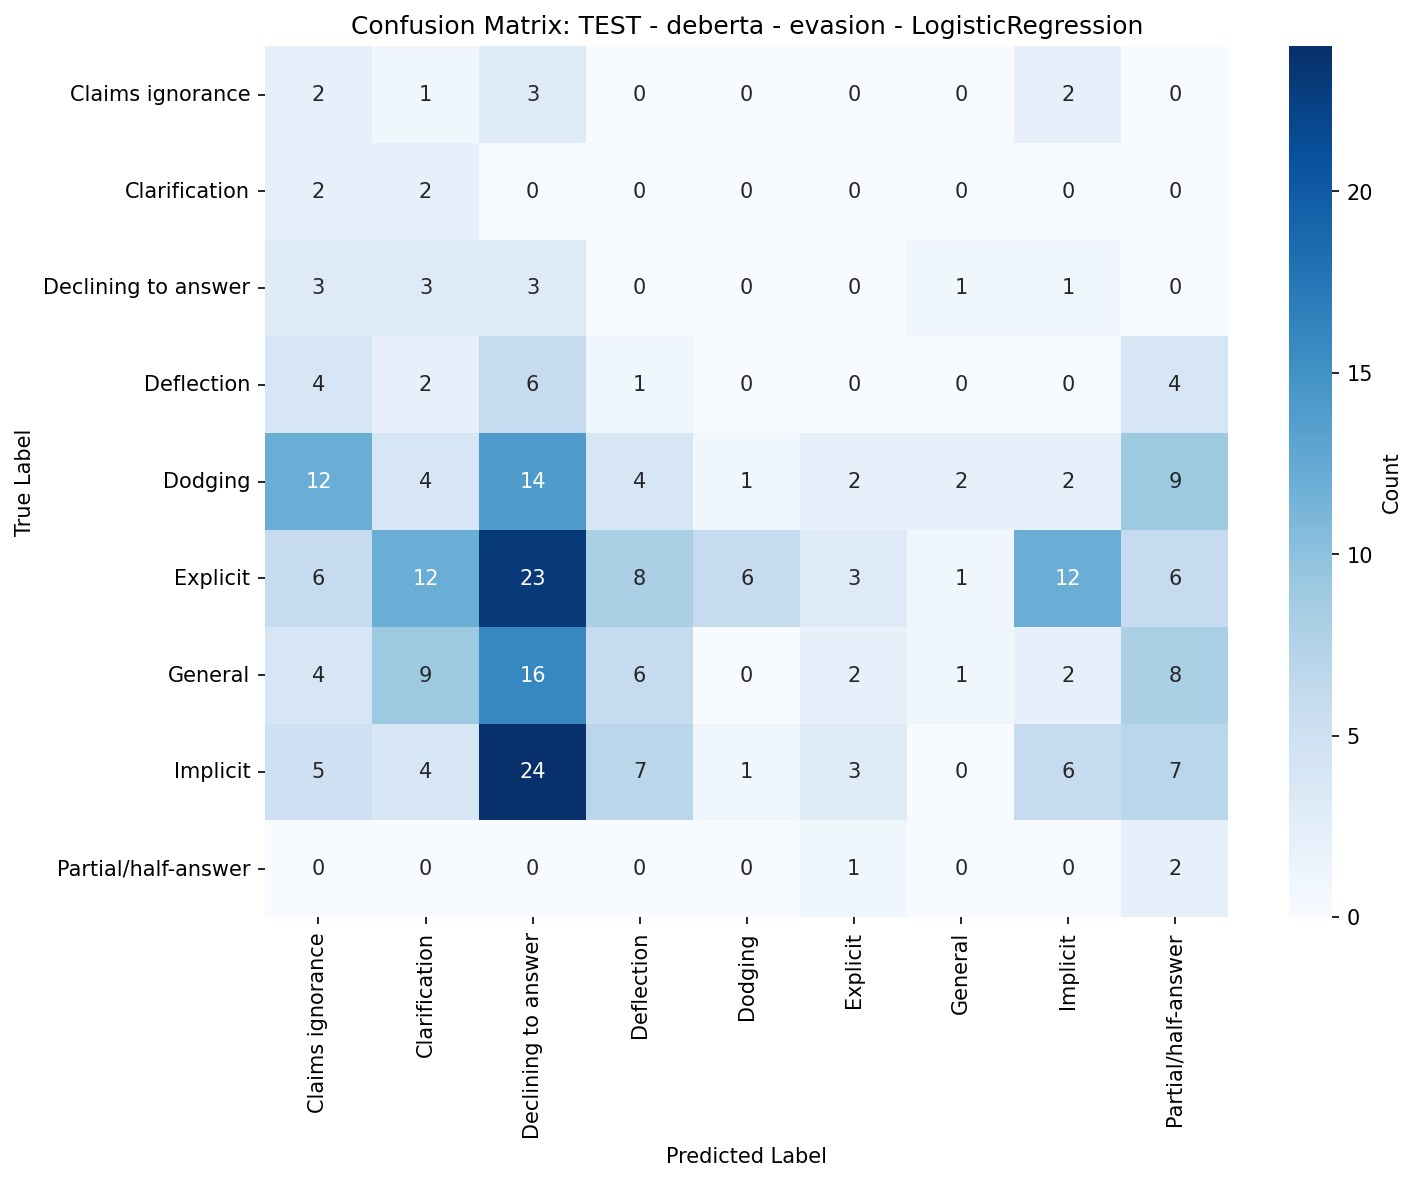


    Training LinearSVC...

Classification Report: TEST - deberta - evasion - LinearSVC
                     precision    recall  f1-score   support

   Claims ignorance     0.0667    0.1250    0.0870         8
      Clarification     0.1000    0.5000    0.1667         4
Declining to answer     0.0500    0.0909    0.0645        11
         Deflection     0.1667    0.0588    0.0870        17
            Dodging     0.1707    0.1400    0.1538        50
           Explicit     0.2606    0.4805    0.3379        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.3333    0.0351    0.0635        57
Partial/half-answer     0.0455    0.3333    0.0800         3

           accuracy                         0.1891       275
          macro avg     0.1326    0.1960    0.1156       275
       weighted avg     0.1893    0.1891    0.1495       275




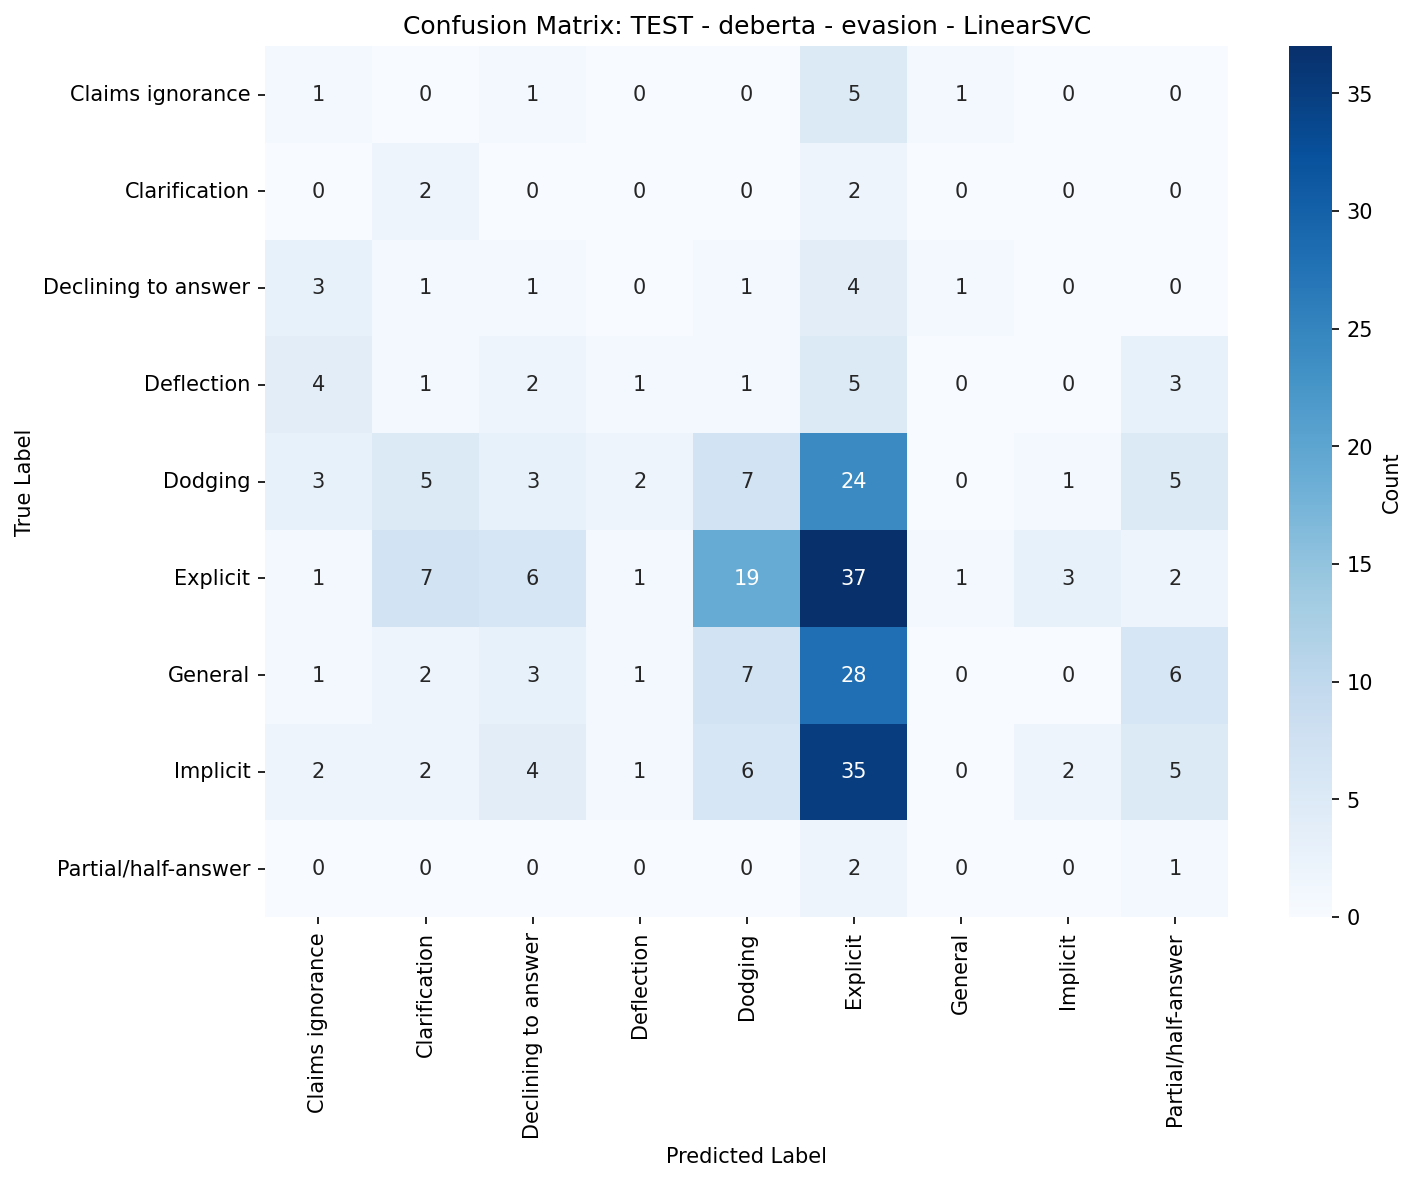


    Training RandomForest...

Classification Report: TEST - deberta - evasion - RandomForest
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.3750    0.1765    0.2400        17
            Dodging     0.2903    0.1800    0.2222        50
           Explicit     0.2824    0.7922    0.4164        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.1250    0.0175    0.0308        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2691       275
          macro avg     0.1192    0.1296    0.1010       275
       weighted avg     0.1810    0.2691    0.1782       275




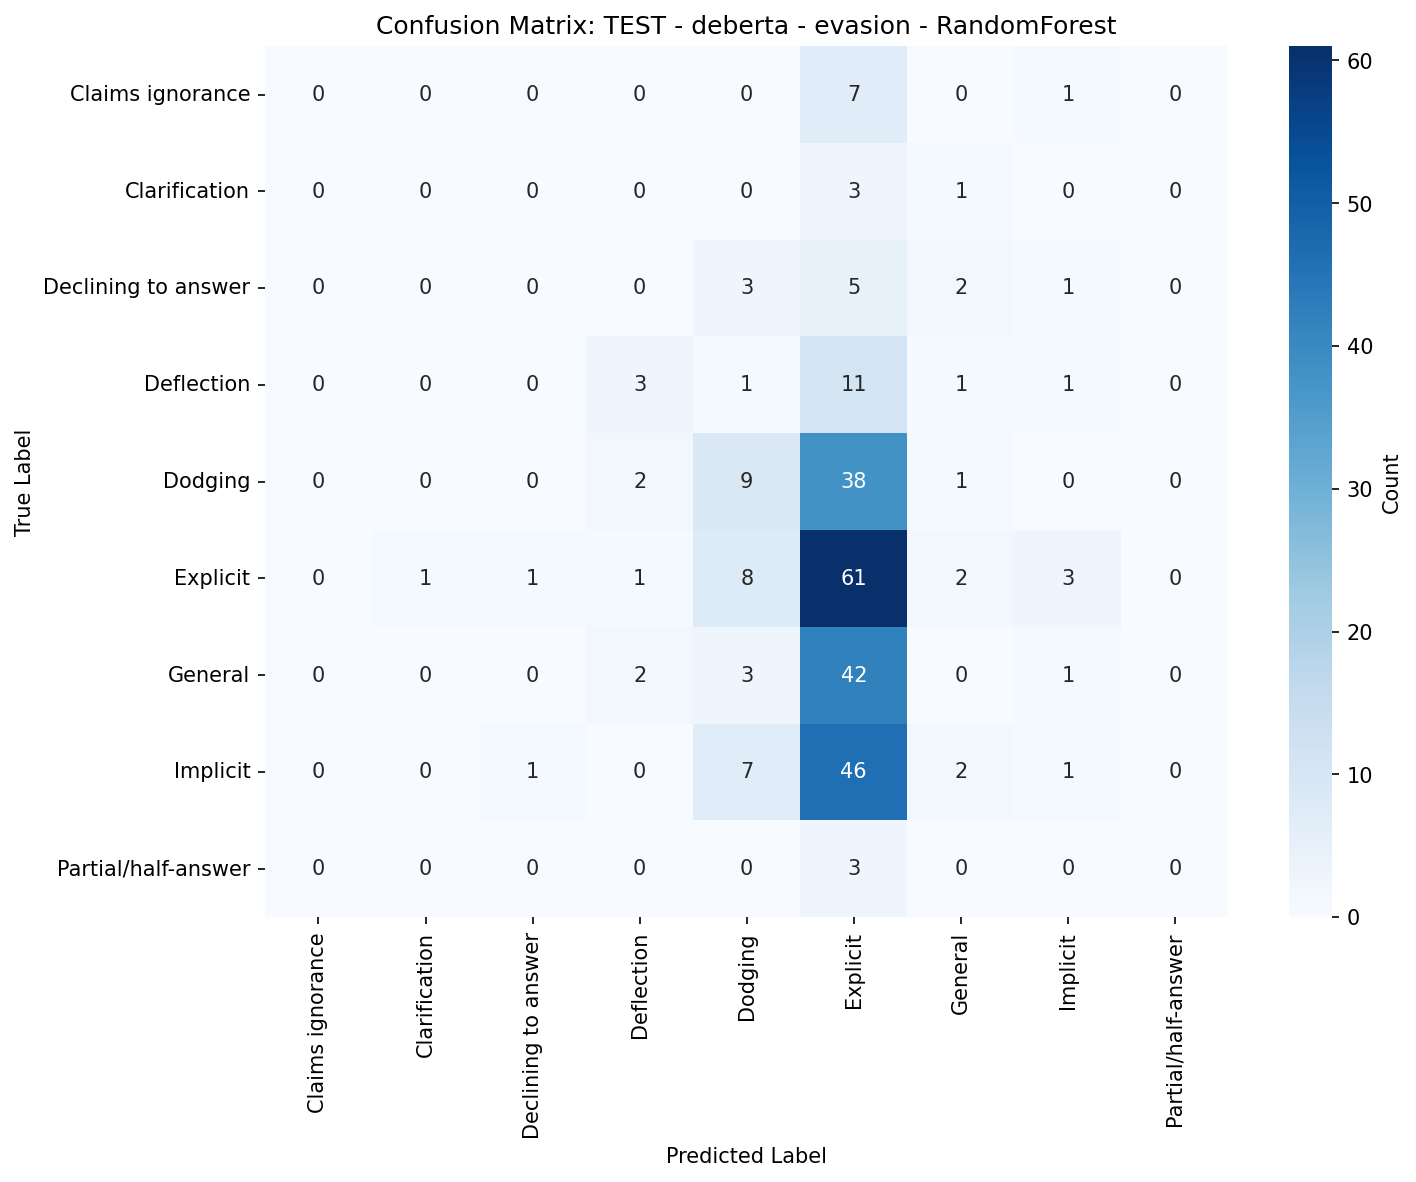


    Training MLP...

Classification Report: TEST - deberta - evasion - MLP
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0000    0.0000    0.0000        17
            Dodging     0.0000    0.0000    0.0000        50
           Explicit     0.2784    0.9870    0.4343        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.0000    0.0000    0.0000        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2764       275
          macro avg     0.0309    0.1097    0.0483       275
       weighted avg     0.0779    0.2764    0.1216       275




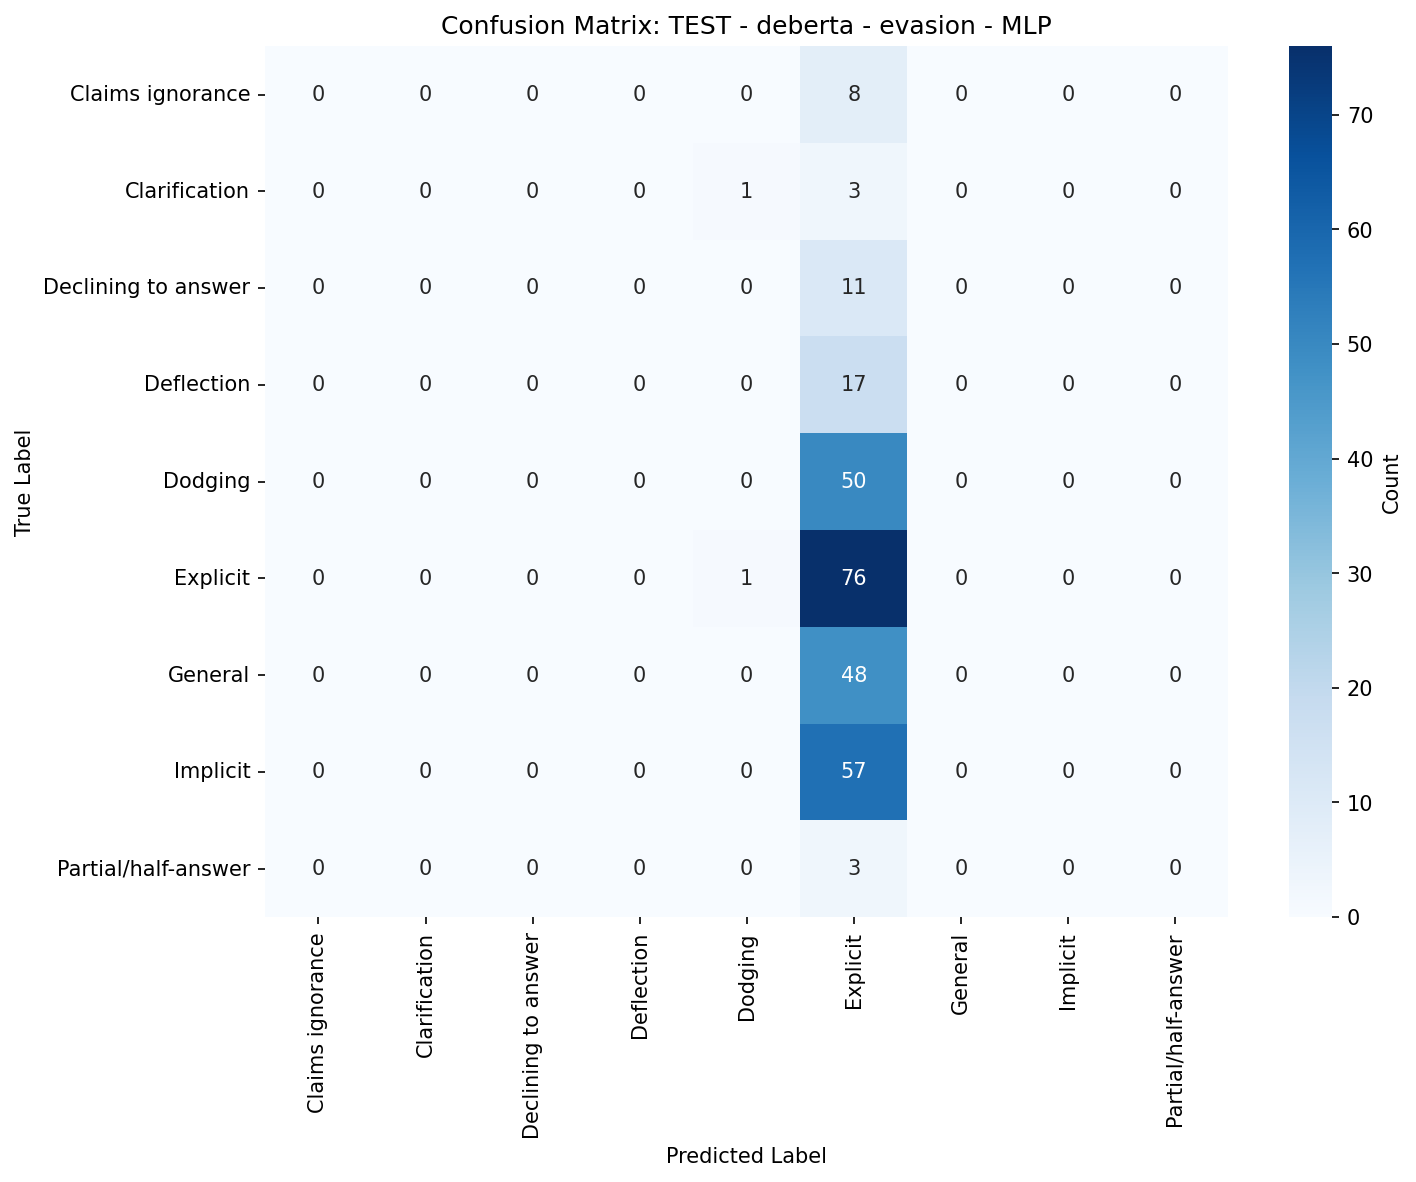


    Training XGBoost...

Classification Report: TEST - deberta - evasion - XGBoost
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0833    0.0588    0.0690        17
            Dodging     0.2708    0.2600    0.2653        50
           Explicit     0.3039    0.7143    0.4264        77
            General     0.2000    0.0417    0.0690        48
           Implicit     0.2174    0.0877    0.1250        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2764       275
          macro avg     0.1195    0.1292    0.1061       275
       weighted avg     0.2194    0.2764    0.2098       275




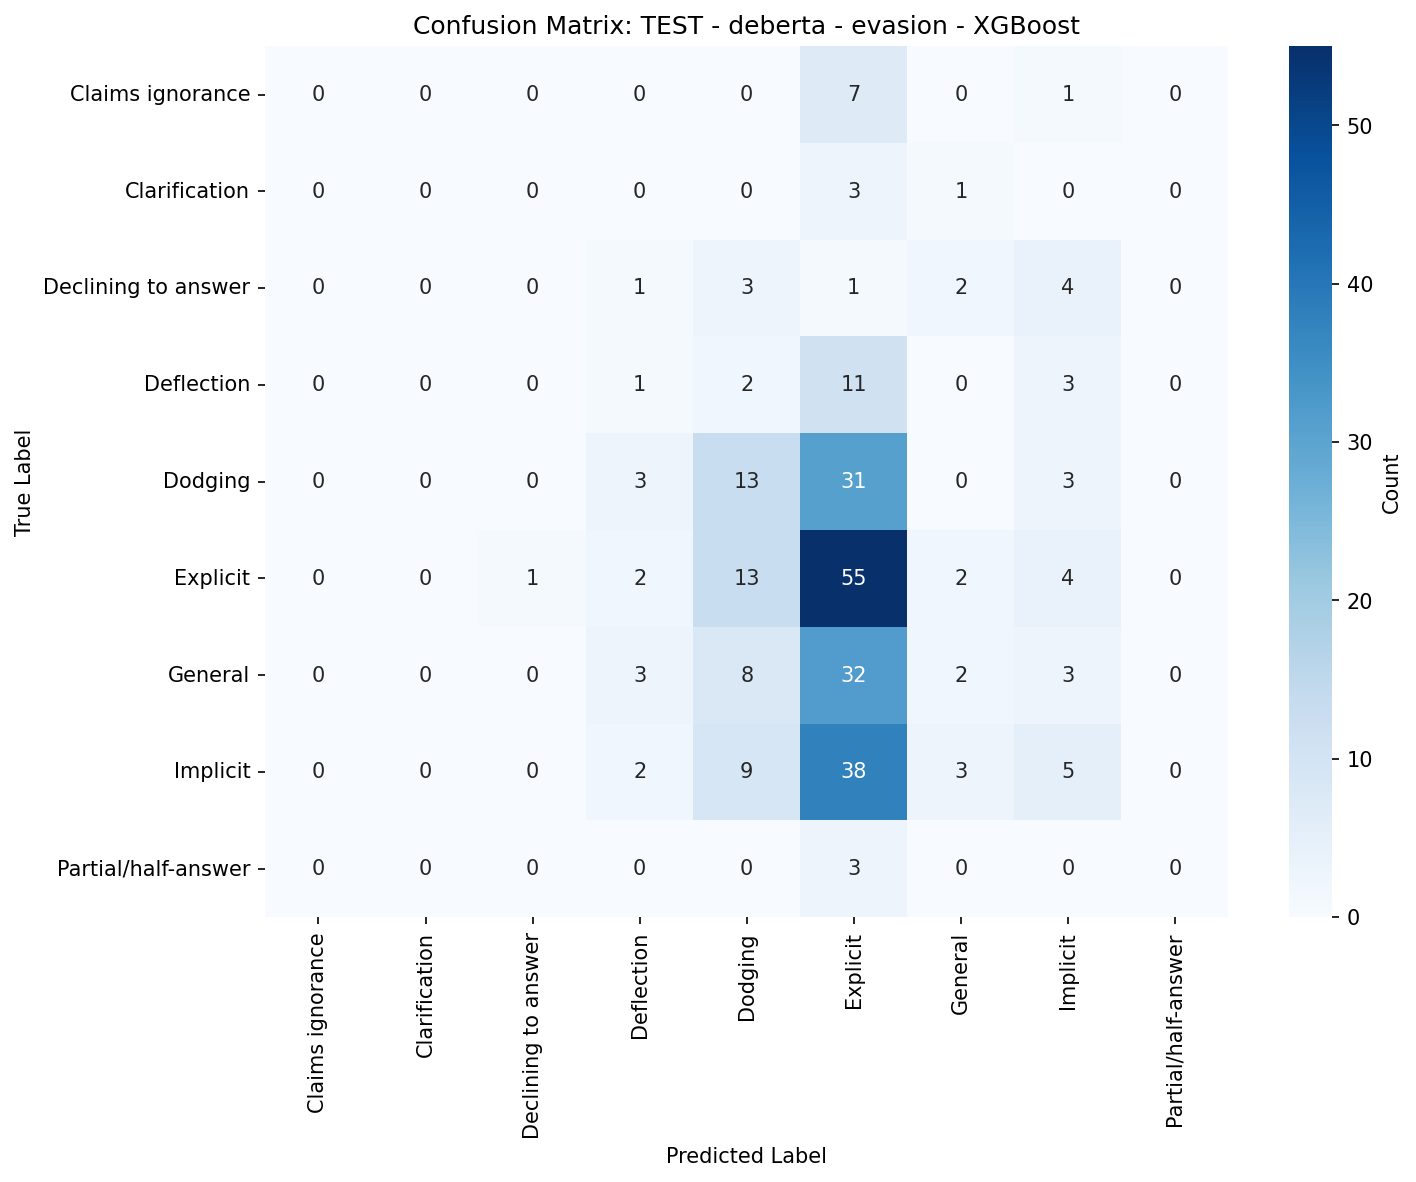


    Training LightGBM...

Classification Report: TEST - deberta - evasion - LightGBM
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.2500    0.0588    0.0952        17
            Dodging     0.2787    0.3400    0.3063        50
           Explicit     0.3152    0.7532    0.4444        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.2941    0.0877    0.1351        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2945       275
          macro avg     0.1264    0.1378    0.1090       275
       weighted avg     0.2153    0.2945    0.2140       275




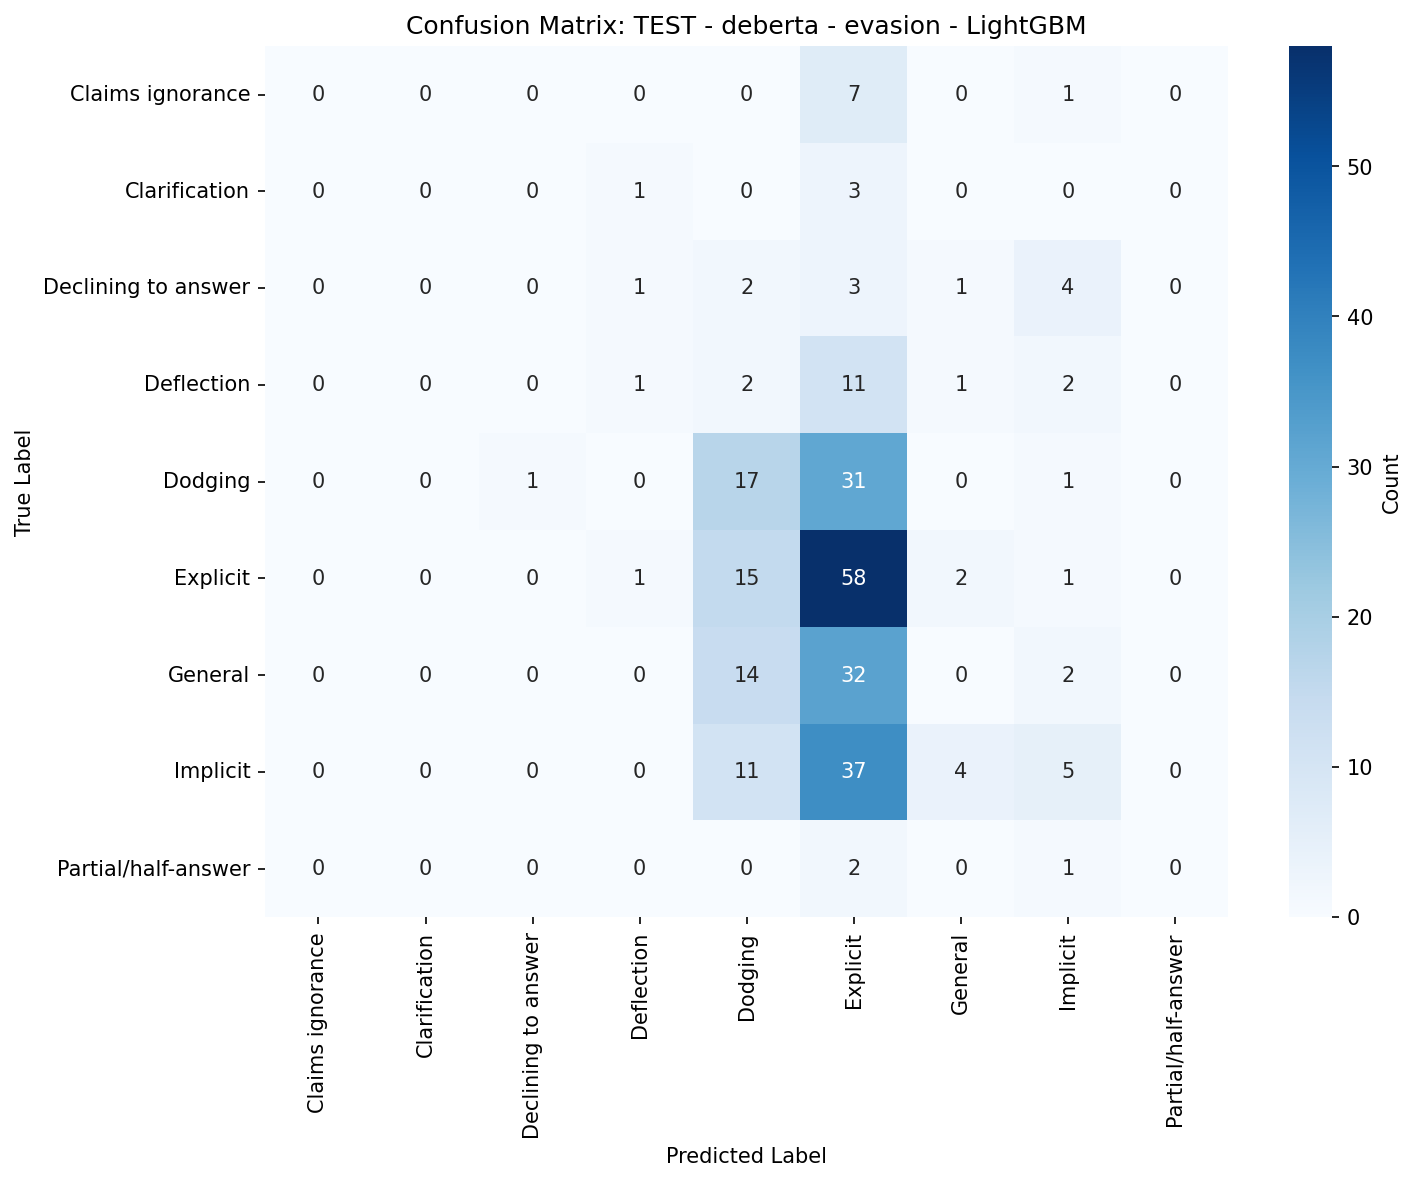


Results Table: TEST - deberta - evasion
        Classifier                     Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
         LinearSVC TEST - deberta - evasion  0.189091  0.115593     0.149527         0.132602      0.195964
          LightGBM TEST - deberta - evasion  0.294545  0.109014     0.214034         0.126447      0.137754
           XGBoost TEST - deberta - evasion  0.276364  0.106066     0.209827         0.119492      0.129166
      RandomForest TEST - deberta - evasion  0.269091  0.101042     0.178205         0.119192      0.129580
LogisticRegression TEST - deberta - evasion  0.076364  0.075593     0.072623         0.119126      0.214808
               MLP TEST - deberta - evasion  0.276364  0.048254     0.121600         0.030932      0.109668

Per-Class Metrics: TEST - deberta - evasion - LinearSVC (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.066667 0.125000  0.086957        8
      Cla

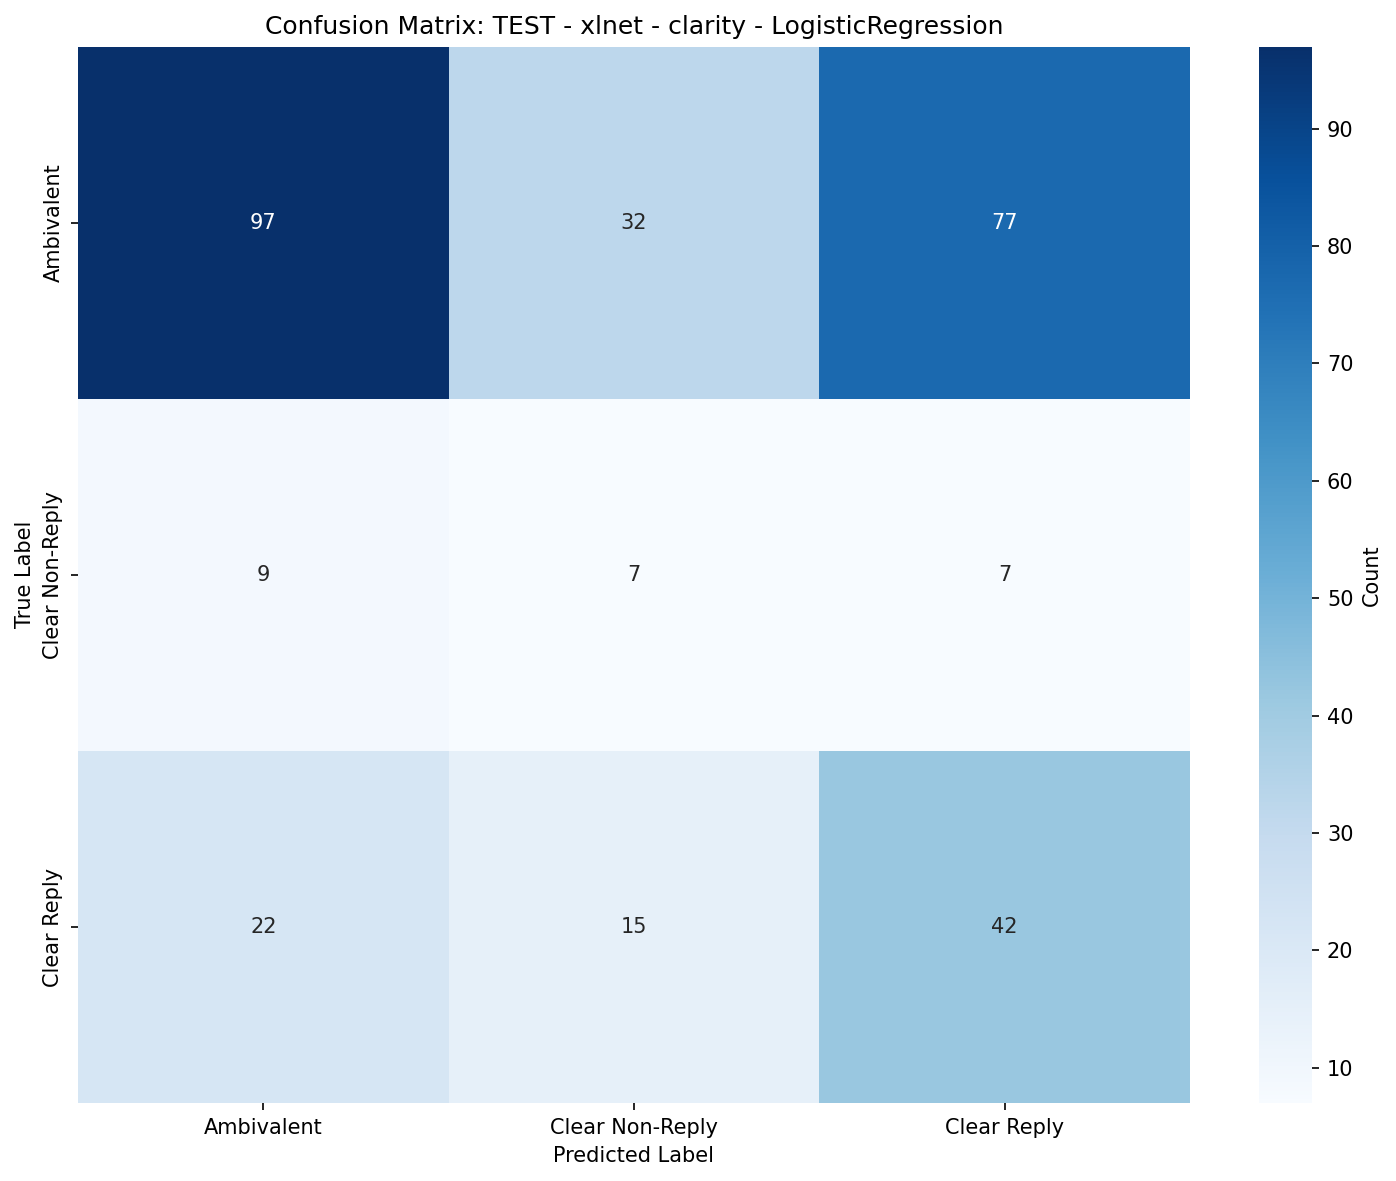


    Training LinearSVC...

Classification Report: TEST - xlnet - clarity - LinearSVC
                 precision    recall  f1-score   support

     Ambivalent     0.7115    0.8738    0.7843       206
Clear Non-Reply     0.2083    0.2174    0.2128        23
    Clear Reply     0.4839    0.1899    0.2727        79

       accuracy                         0.6494       308
      macro avg     0.4679    0.4270    0.4233       308
   weighted avg     0.6155    0.6494    0.6104       308




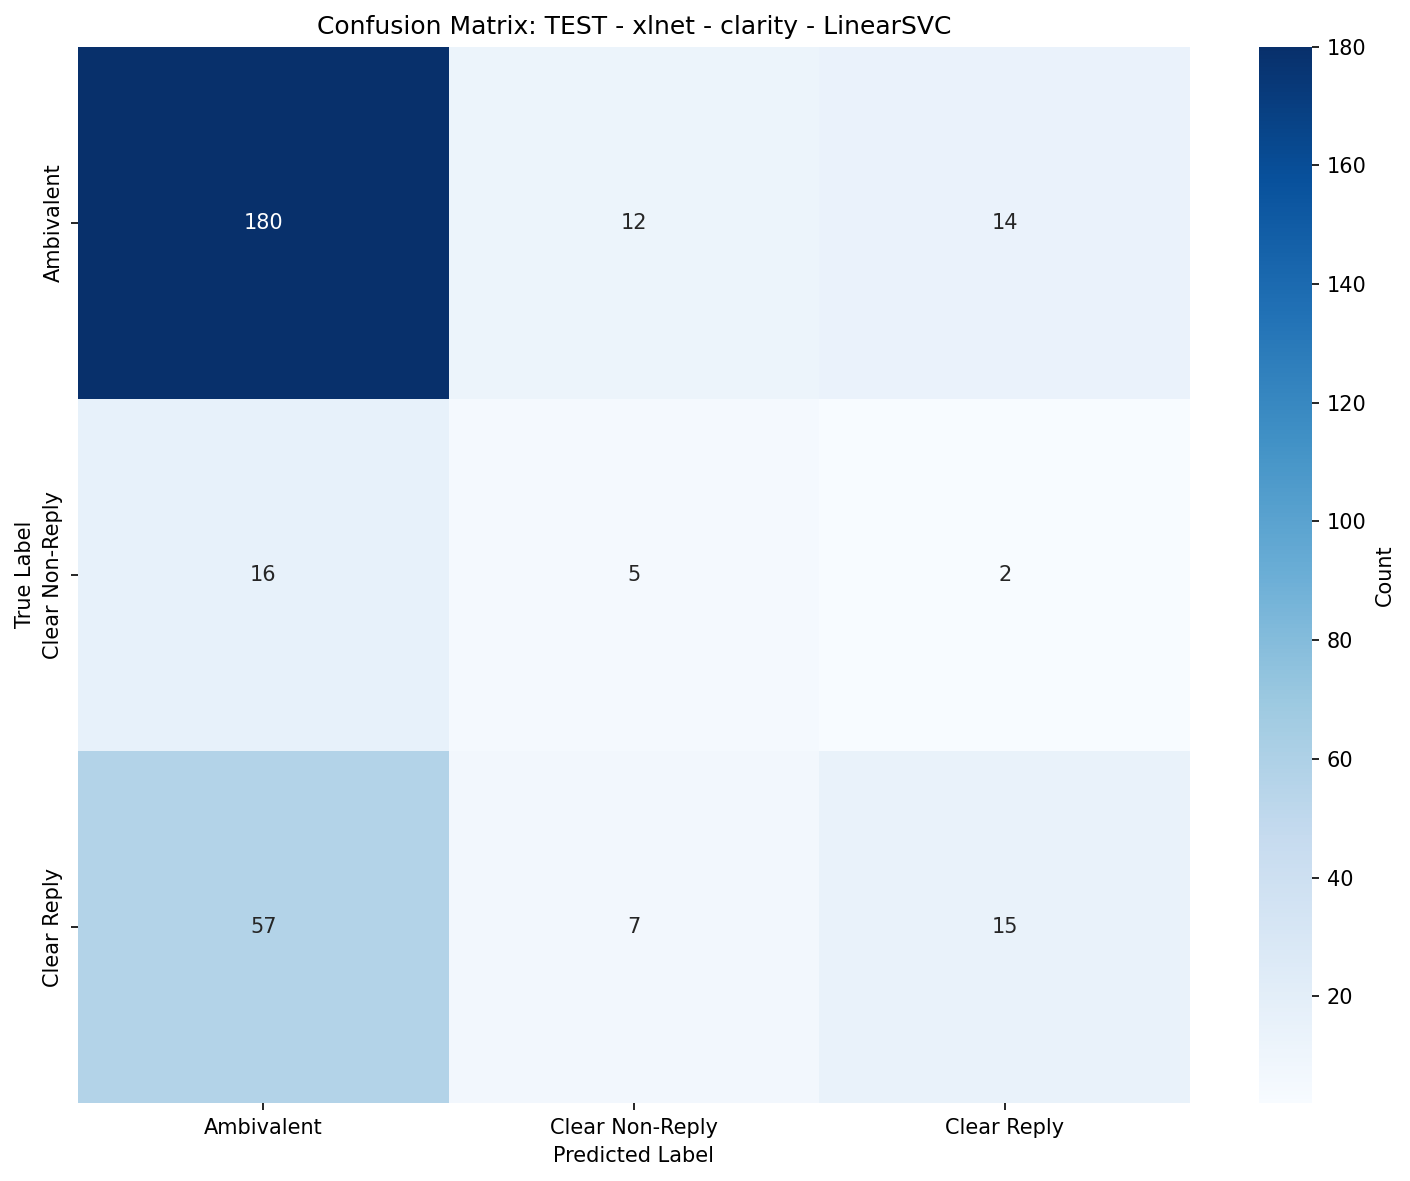


    Training RandomForest...

Classification Report: TEST - xlnet - clarity - RandomForest
                 precision    recall  f1-score   support

     Ambivalent     0.7014    0.9466    0.8058       206
Clear Non-Reply     0.7500    0.2609    0.3871        23
    Clear Reply     0.5000    0.1392    0.2178        79

       accuracy                         0.6883       308
      macro avg     0.6505    0.4489    0.4702       308
   weighted avg     0.6534    0.6883    0.6237       308




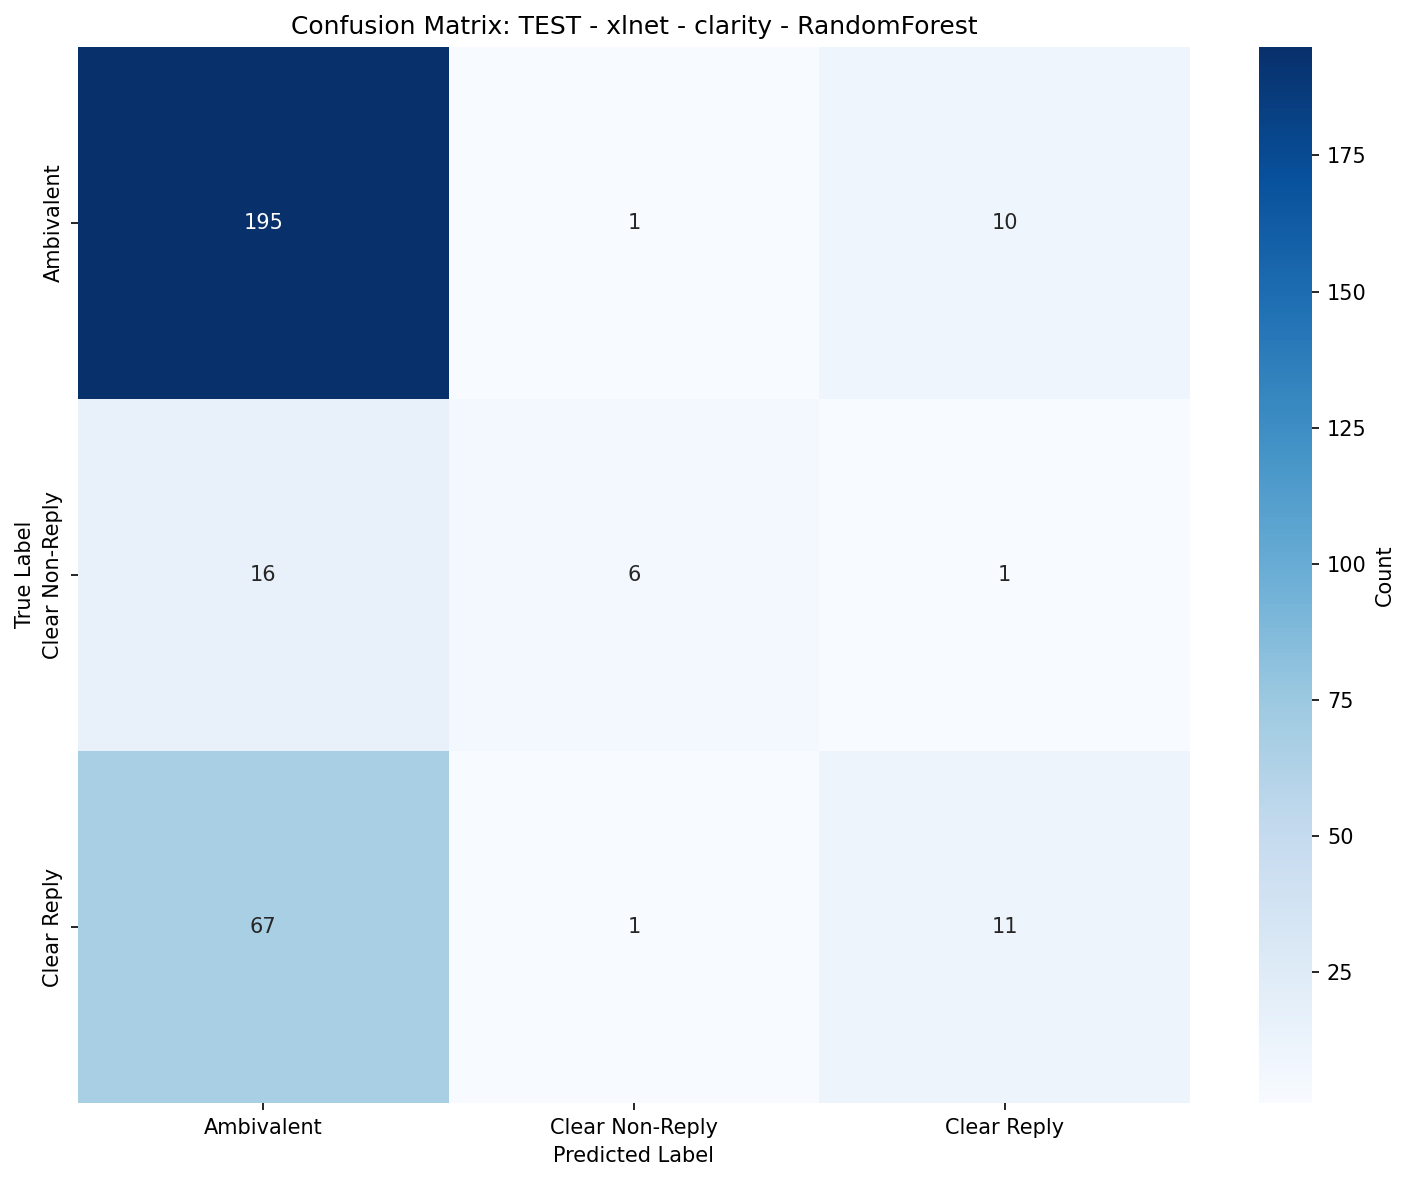


    Training MLP...

Classification Report: TEST - xlnet - clarity - MLP
                 precision    recall  f1-score   support

     Ambivalent     0.6846    0.9903    0.8095       206
Clear Non-Reply     1.0000    0.0435    0.0833        23
    Clear Reply     0.6667    0.0759    0.1364        79

       accuracy                         0.6851       308
      macro avg     0.7837    0.3699    0.3431       308
   weighted avg     0.7035    0.6851    0.5826       308




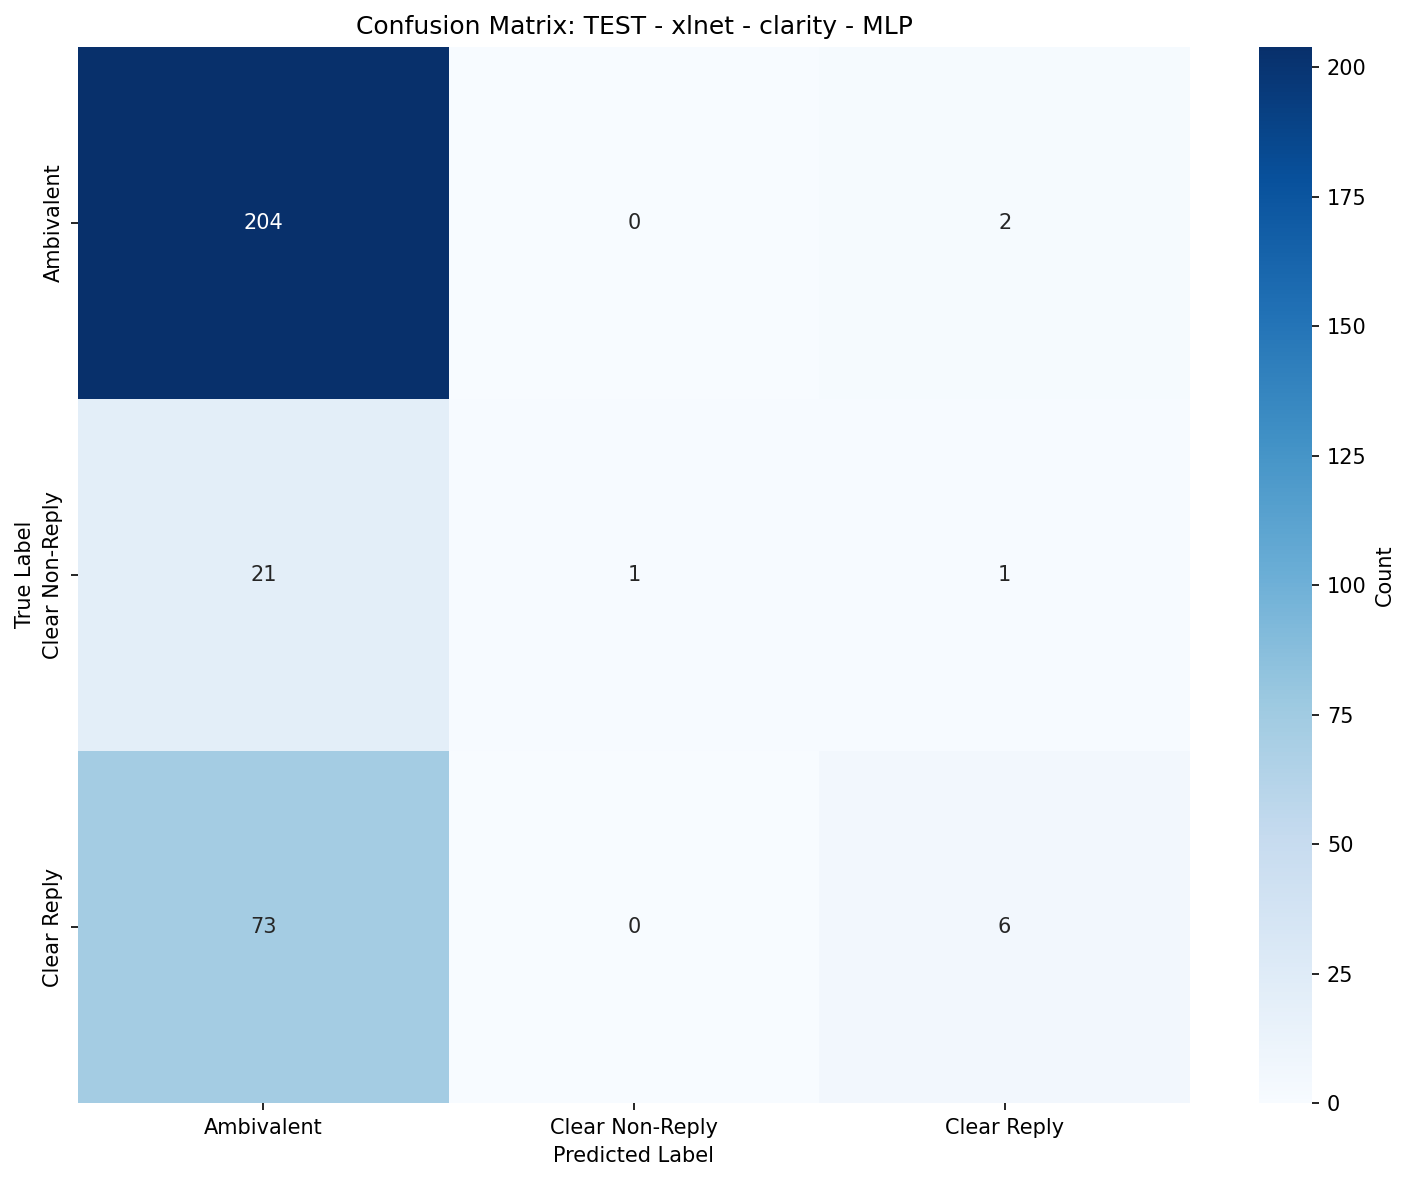


    Training XGBoost...

Classification Report: TEST - xlnet - clarity - XGBoost
                 precision    recall  f1-score   support

     Ambivalent     0.7209    0.9029    0.8017       206
Clear Non-Reply     0.6250    0.2174    0.3226        23
    Clear Reply     0.5000    0.2658    0.3471        79

       accuracy                         0.6883       308
      macro avg     0.6153    0.4620    0.4905       308
   weighted avg     0.6571    0.6883    0.6493       308




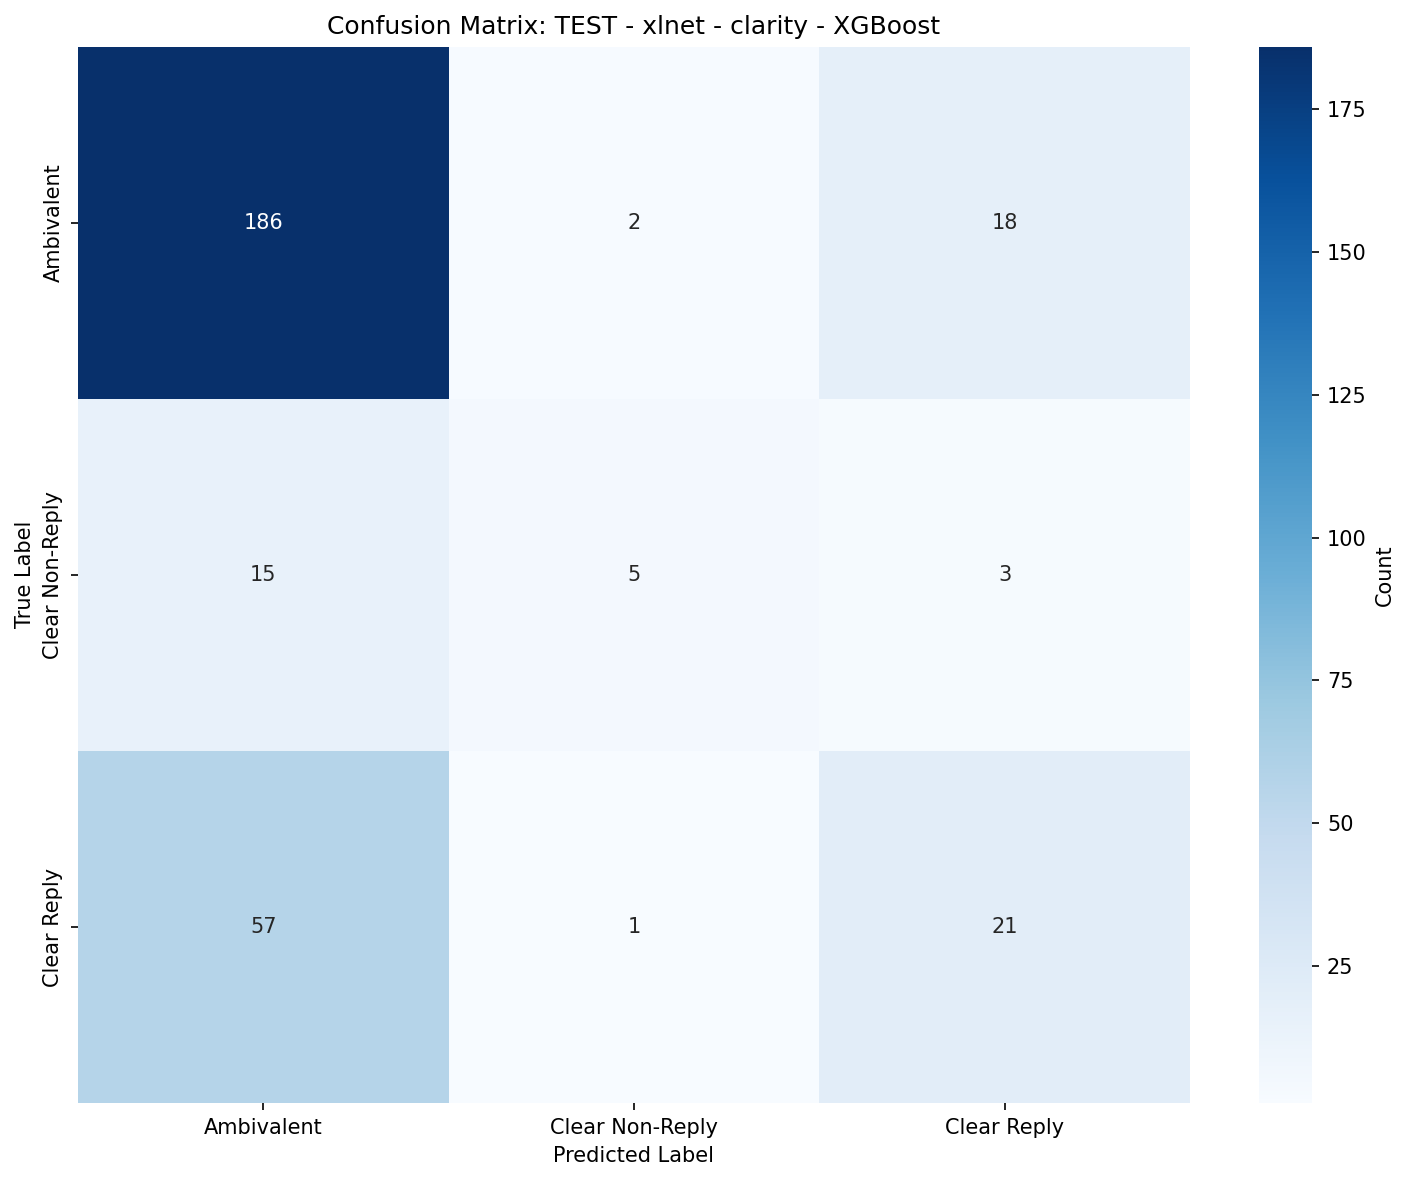


    Training LightGBM...

Classification Report: TEST - xlnet - clarity - LightGBM
                 precision    recall  f1-score   support

     Ambivalent     0.7192    0.9078    0.8026       206
Clear Non-Reply     0.6667    0.2609    0.3750        23
    Clear Reply     0.4359    0.2152    0.2881        79

       accuracy                         0.6818       308
      macro avg     0.6073    0.4613    0.4886       308
   weighted avg     0.6426    0.6818    0.6387       308




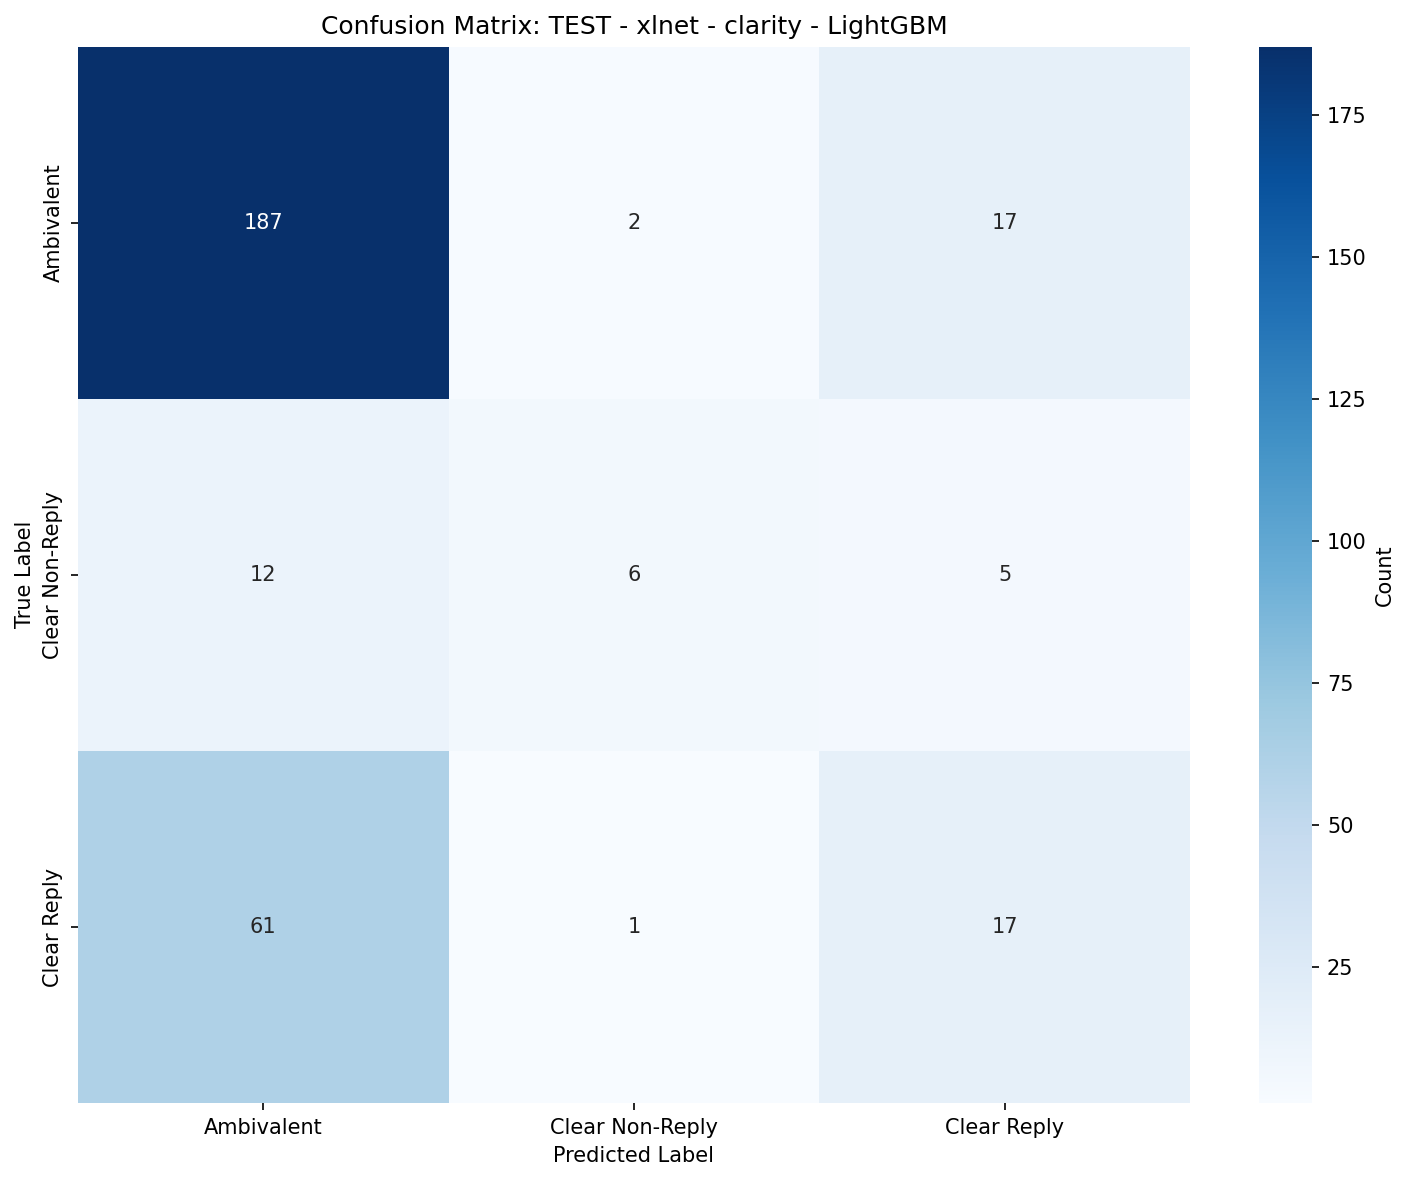


Results Table: TEST - xlnet - clarity
        Classifier                   Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
           XGBoost TEST - xlnet - clarity  0.688312  0.490471     0.649338         0.615310      0.462042
          LightGBM TEST - xlnet - clarity  0.681818  0.488570     0.638695         0.607265      0.461275
      RandomForest TEST - xlnet - clarity  0.688312  0.470235     0.623711         0.650480      0.448904
         LinearSVC TEST - xlnet - clarity  0.649351  0.423269     0.610415         0.467889      0.427017
LogisticRegression TEST - xlnet - clarity  0.474026  0.390804     0.507160         0.406925      0.435622
               MLP TEST - xlnet - clarity  0.685065  0.343074     0.582634         0.783743      0.369906

Per-Class Metrics: TEST - xlnet - clarity - XGBoost (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent    0.72093 0.902913  0.801724      206
Clear Non-Reply    0.62500 0.217391  

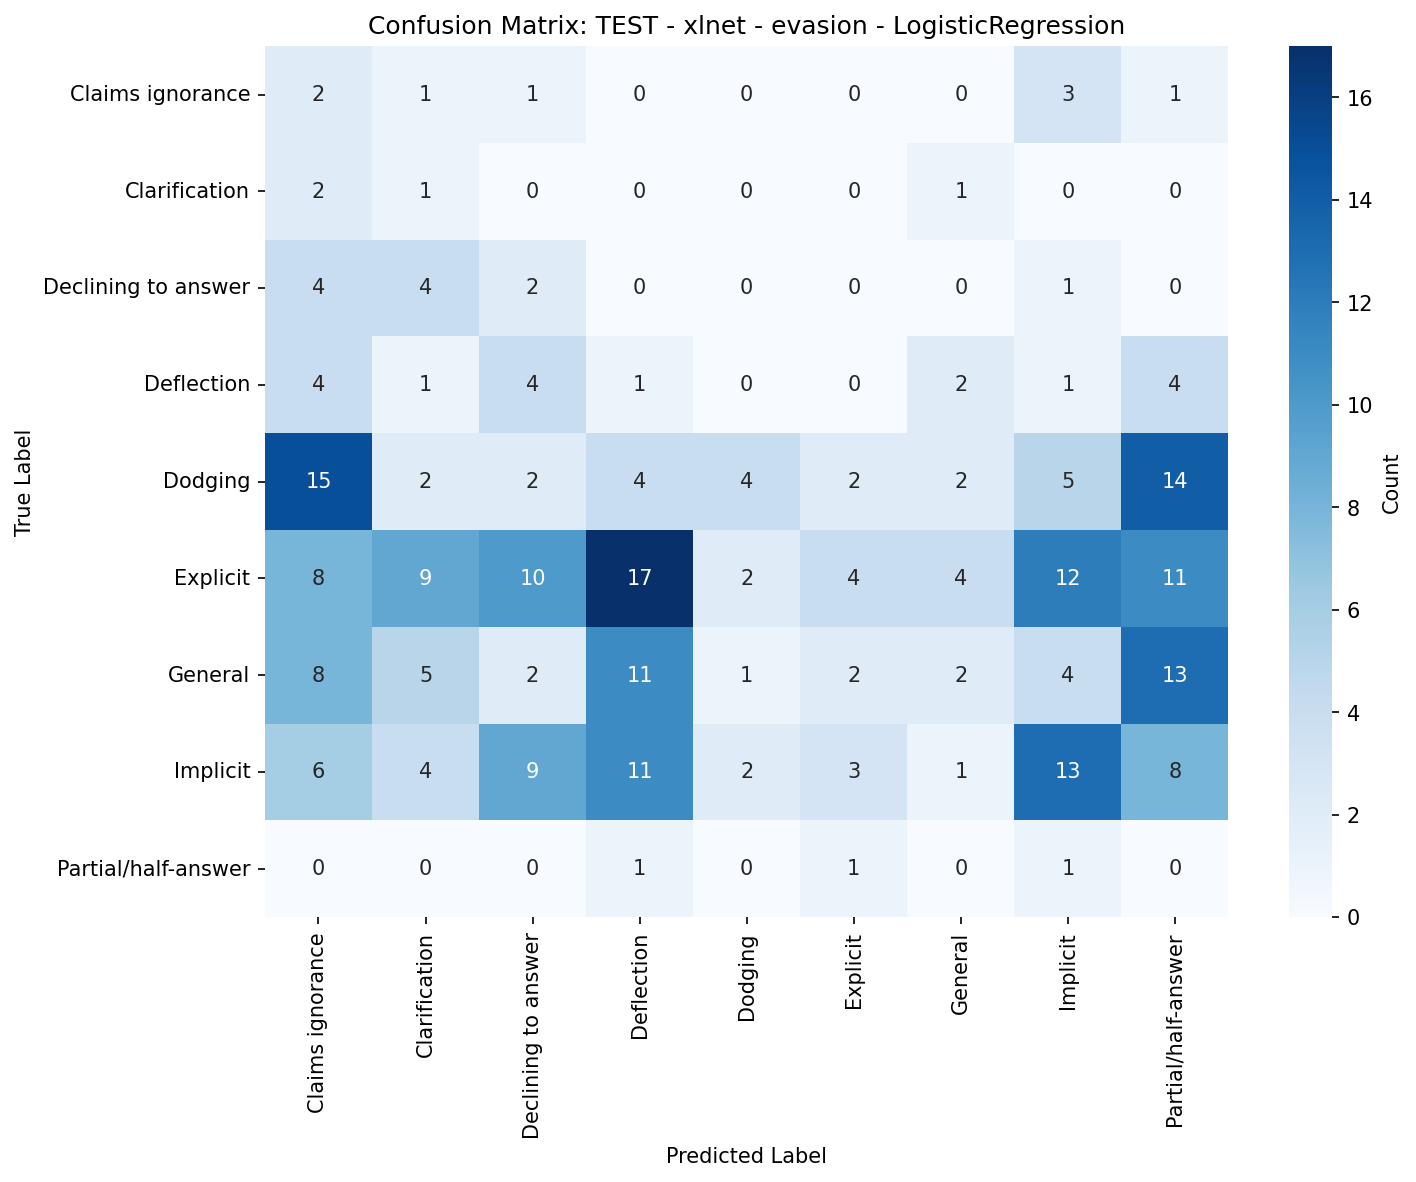


    Training LinearSVC...

Classification Report: TEST - xlnet - evasion - LinearSVC
                     precision    recall  f1-score   support

   Claims ignorance     0.0588    0.1250    0.0800         8
      Clarification     0.0714    0.2500    0.1111         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0000    0.0000    0.0000        17
            Dodging     0.1364    0.1200    0.1277        50
           Explicit     0.2867    0.5584    0.3789        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.2500    0.0351    0.0615        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.1927       275
          macro avg     0.0893    0.1209    0.0844       275
       weighted avg     0.1596    0.1927    0.1460       275




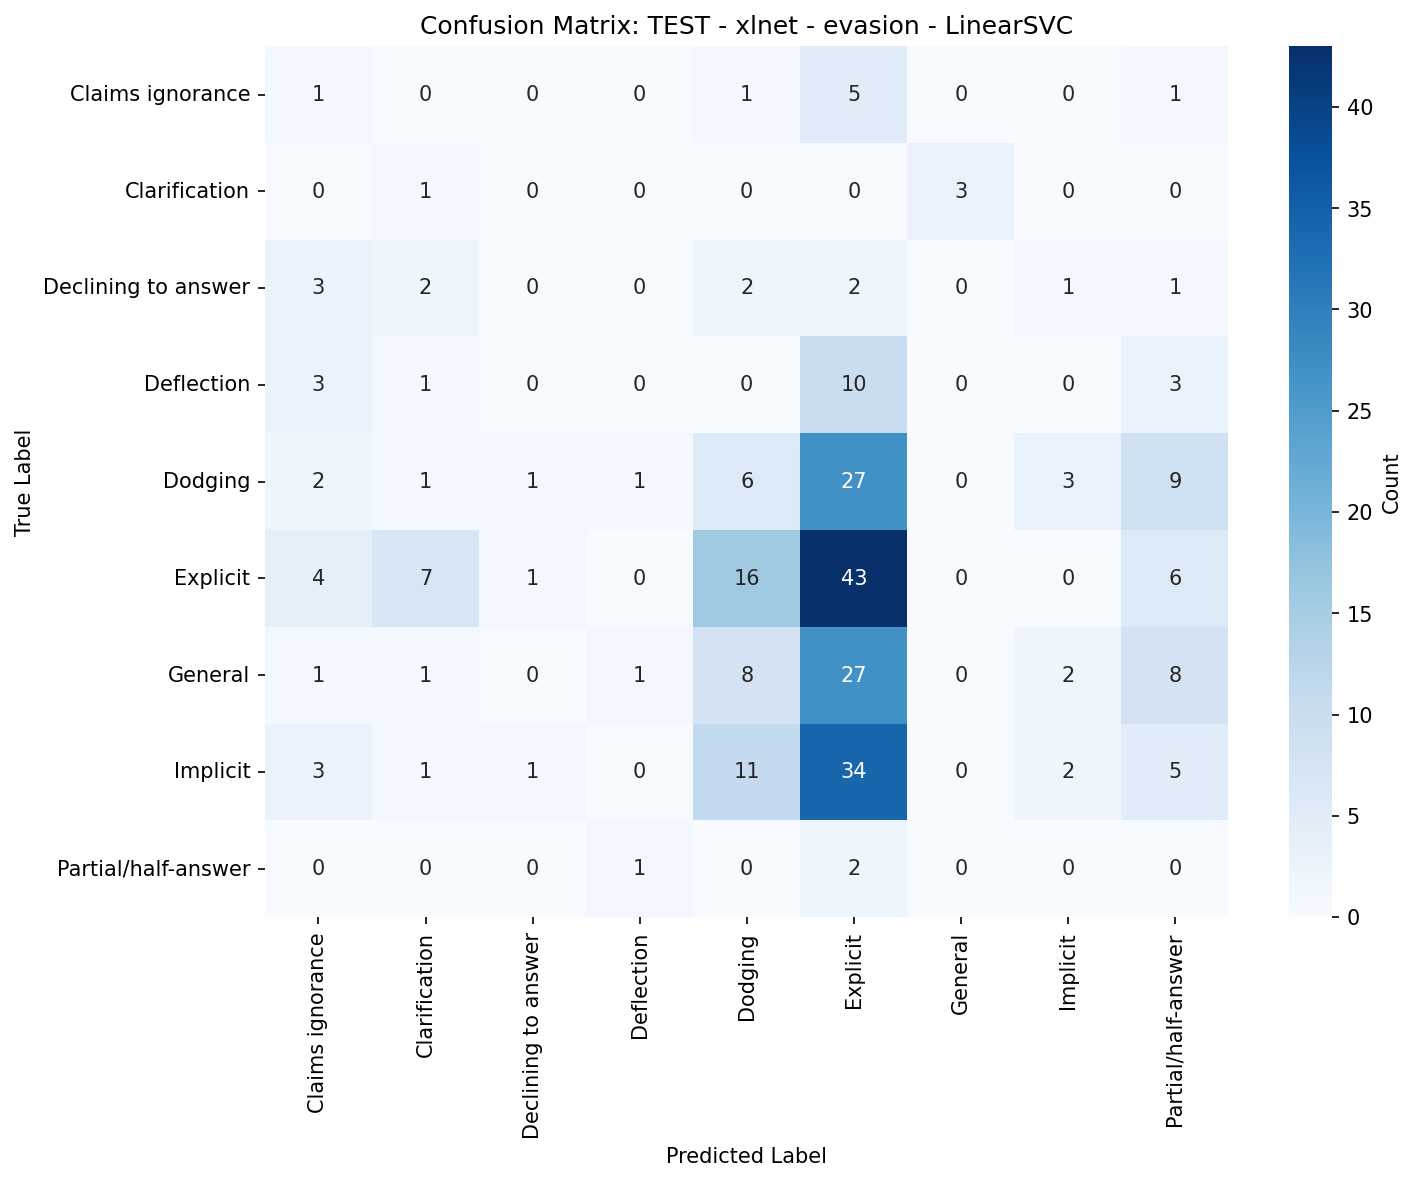


    Training RandomForest...

Classification Report: TEST - xlnet - evasion - RandomForest
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.3333    0.1176    0.1739        17
            Dodging     0.2500    0.1800    0.2093        50
           Explicit     0.3005    0.8312    0.4414        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.2143    0.0526    0.0845        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2836       275
          macro avg     0.1220    0.1313    0.1010       275
       weighted avg     0.1946    0.2836    0.1899       275




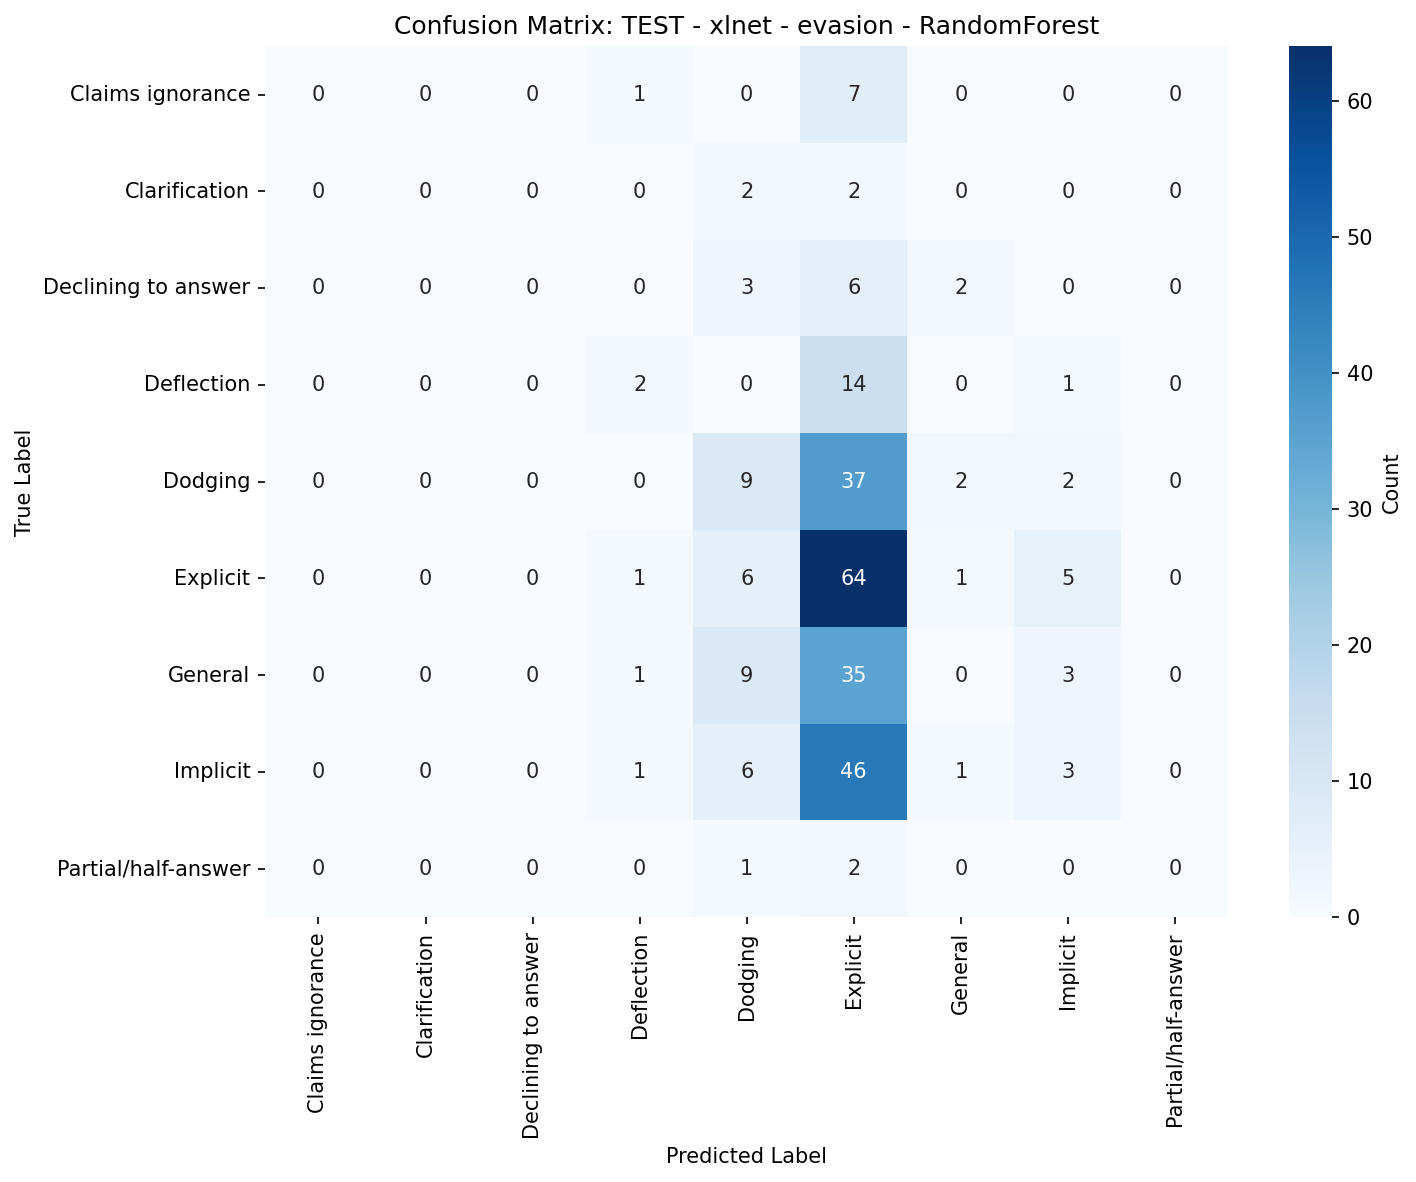


    Training MLP...

Classification Report: TEST - xlnet - evasion - MLP
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.0000    0.0000    0.0000        17
            Dodging     0.0000    0.0000    0.0000        50
           Explicit     0.2784    0.9870    0.4343        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.0000    0.0000    0.0000        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2764       275
          macro avg     0.0309    0.1097    0.0483       275
       weighted avg     0.0779    0.2764    0.1216       275




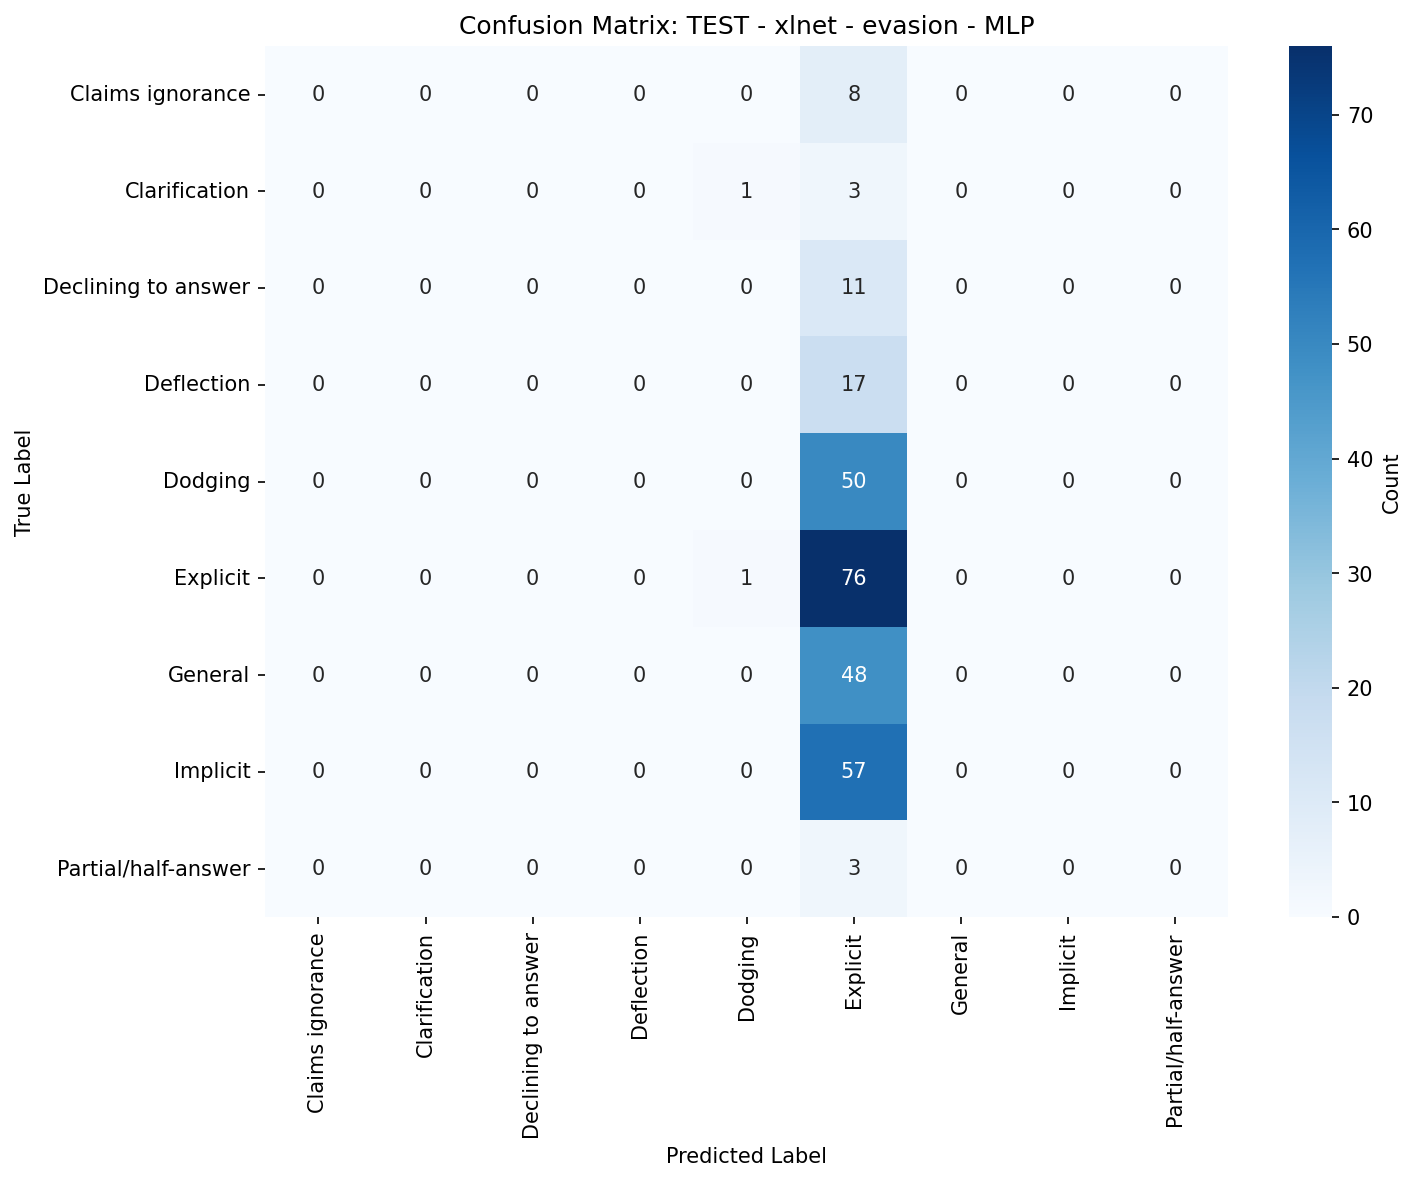


    Training XGBoost...

Classification Report: TEST - xlnet - evasion - XGBoost
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.2727    0.1765    0.2143        17
            Dodging     0.2000    0.1400    0.1647        50
           Explicit     0.2694    0.6753    0.3852        77
            General     0.2000    0.0833    0.1176        48
           Implicit     0.1250    0.0351    0.0548        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2473       275
          macro avg     0.1186    0.1234    0.1041       275
       weighted avg     0.1895    0.2473    0.1829       275




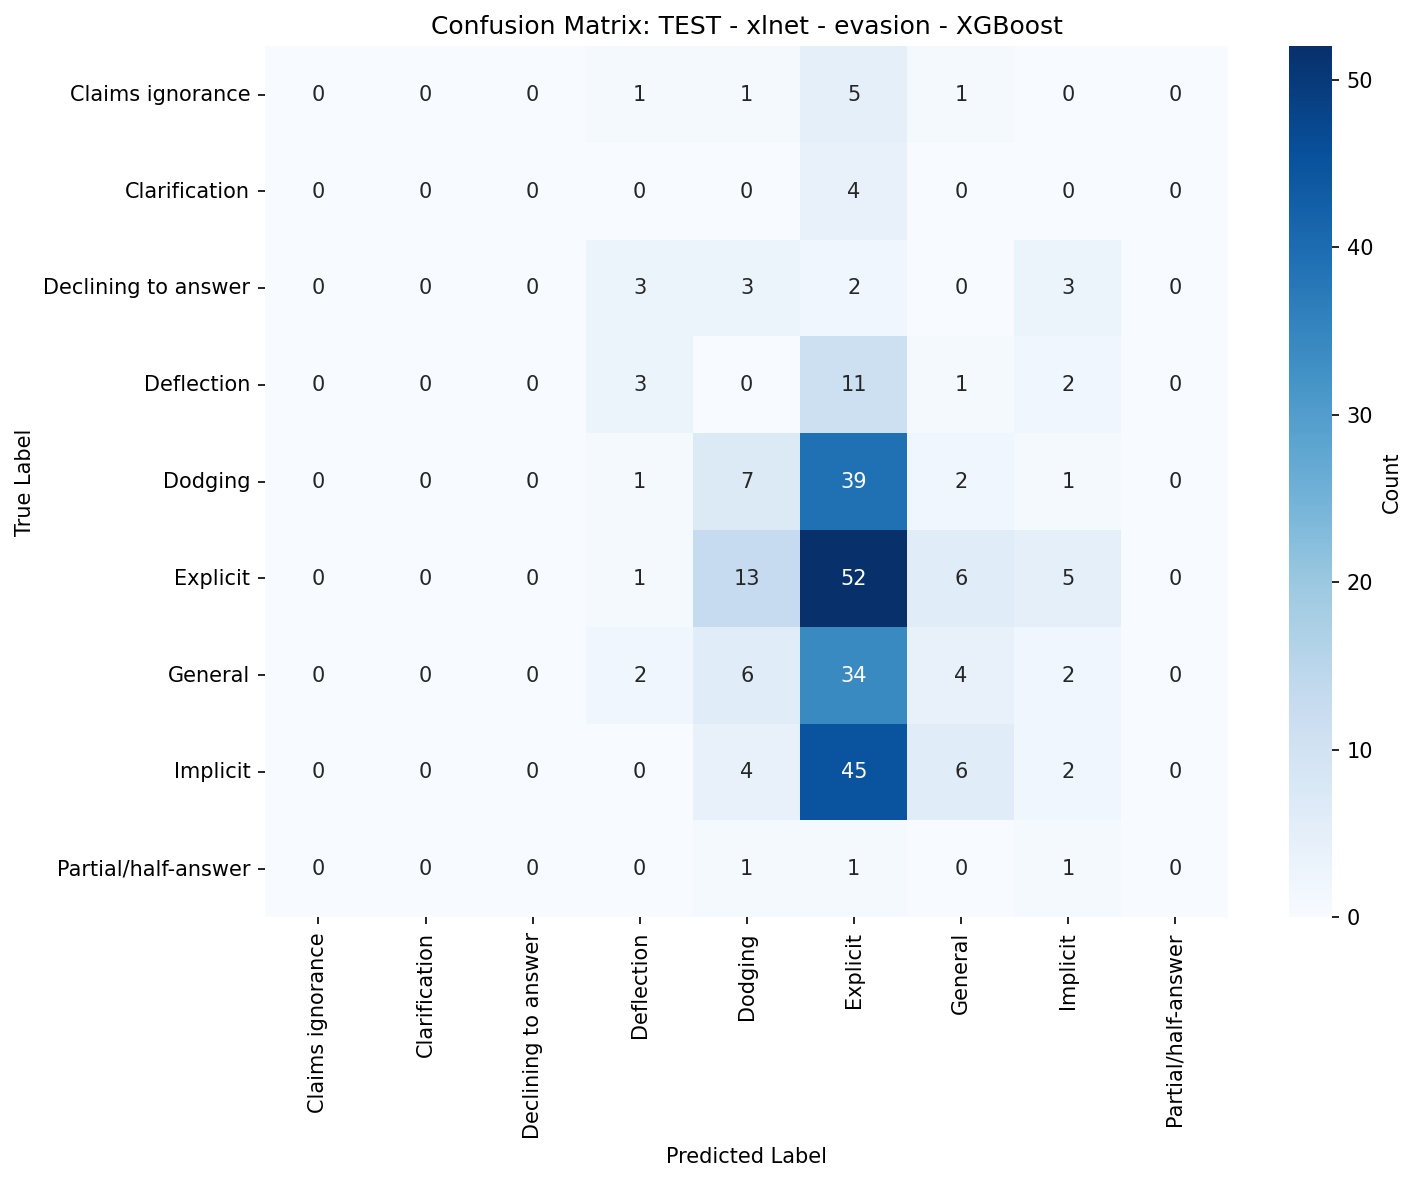


    Training LightGBM...

Classification Report: TEST - xlnet - evasion - LightGBM
                     precision    recall  f1-score   support

   Claims ignorance     0.0000    0.0000    0.0000         8
      Clarification     0.0000    0.0000    0.0000         4
Declining to answer     0.0000    0.0000    0.0000        11
         Deflection     0.1667    0.1176    0.1379        17
            Dodging     0.1837    0.1800    0.1818        50
           Explicit     0.2953    0.7403    0.4222        77
            General     0.0000    0.0000    0.0000        48
           Implicit     0.2667    0.0702    0.1111        57
Partial/half-answer     0.0000    0.0000    0.0000         3

           accuracy                         0.2618       275
          macro avg     0.1014    0.1231    0.0948       275
       weighted avg     0.1817    0.2618    0.1828       275




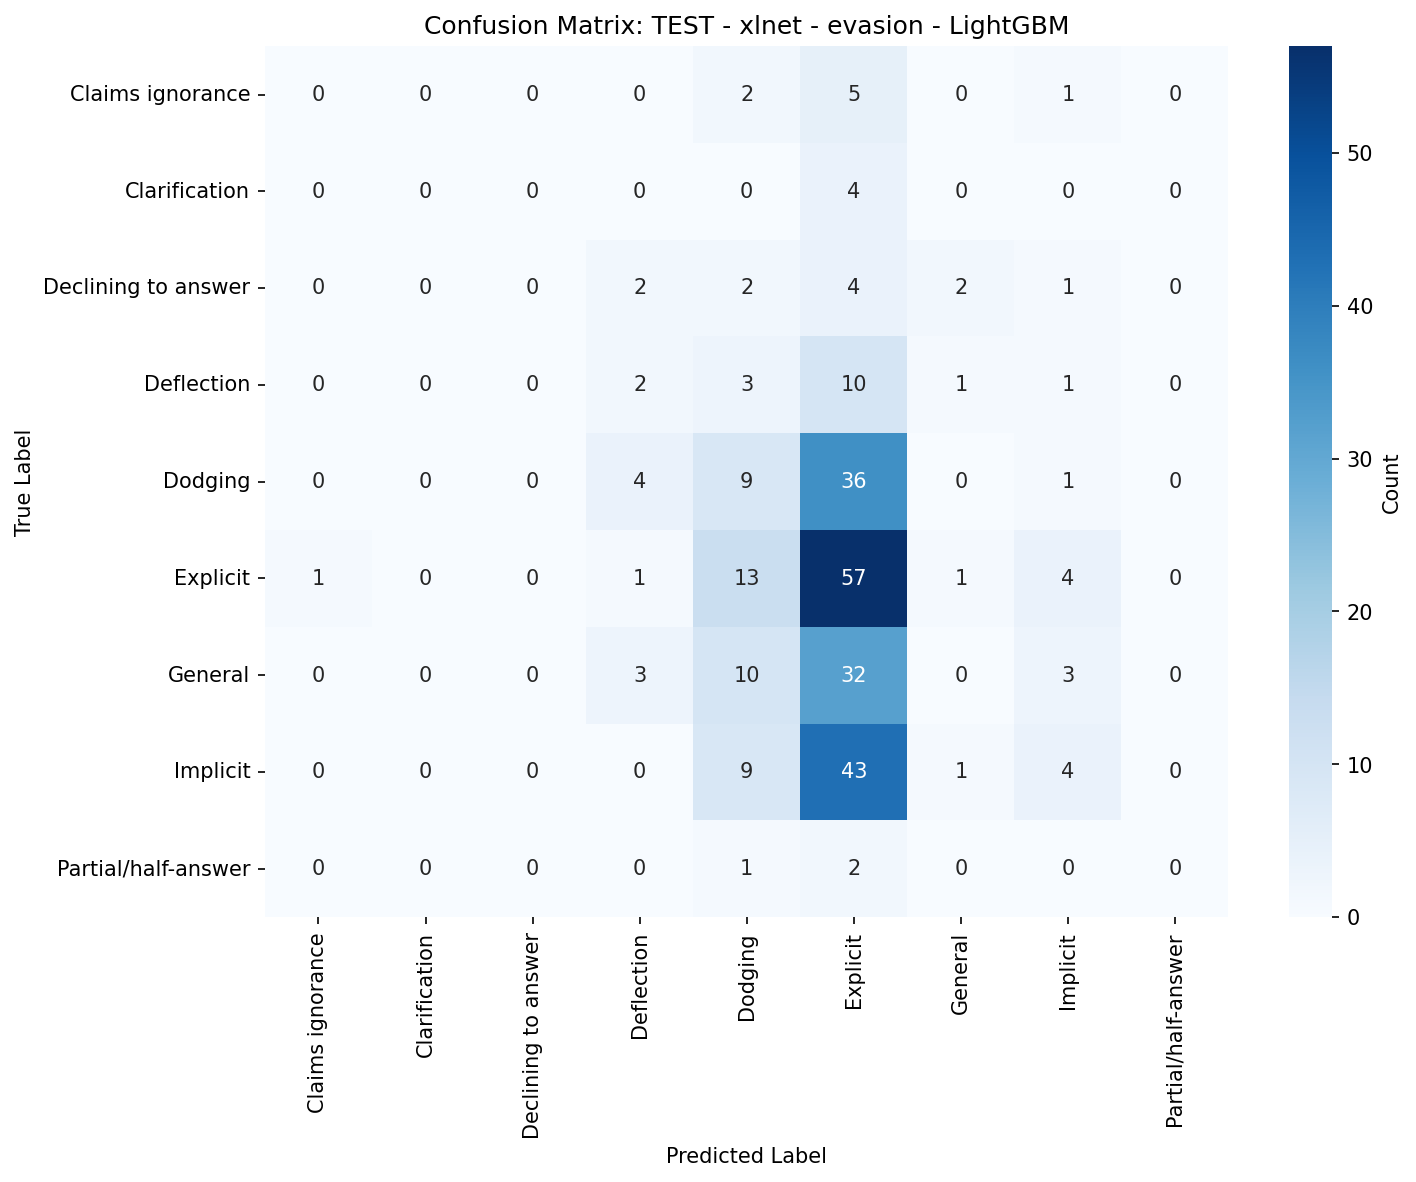


Results Table: TEST - xlnet - evasion
        Classifier                   Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
           XGBoost TEST - xlnet - evasion  0.247273  0.104069     0.182937         0.118573      0.123357
      RandomForest TEST - xlnet - evasion  0.283636  0.101011     0.189908         0.122010      0.131272
          LightGBM TEST - xlnet - evasion  0.261818  0.094787     0.182837         0.101372      0.123120
LogisticRegression TEST - xlnet - evasion  0.105455  0.091633     0.125892         0.159576      0.126925
         LinearSVC TEST - xlnet - evasion  0.192727  0.084352     0.145989         0.089254      0.120948
               MLP TEST - xlnet - evasion  0.276364  0.048254     0.121600         0.030932      0.109668

Per-Class Metrics: TEST - xlnet - evasion - XGBoost (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.000000 0.000000  0.000000        8
      Clarification   0.00000

In [3]:
# ============================================================================
# FINAL EVALUATION: YARIŞMAYA UYGUN TEK FONKSİYON ÇAĞRISI
# ============================================================================
# Bu fonksiyon tüm final evaluation işlemlerini yapar:
# 1. Test feature'larını extract eder (yoksa) veya Drive'dan yükler
# 2. Train+Dev üzerinde tüm model×classifier kombinasyonlarını eğitir
# 3. Test setinde tahmin yapar ve metrikleri hesaplar
# 4. Hierarchical evaluation yapar (evasion → clarity)
# 5. Sonuçları kaydeder ve görselleştirir

results = run_final_evaluation(
    storage=storage,
    models=MODELS,
    tasks=TASKS,
    model_configs=MODEL_CONFIGS,
    model_max_lengths=MODEL_MAX_LENGTHS,
    label_lists=LABEL_LISTS,
    device=device,
    classifiers=classifiers,
    random_state=42,
    batch_size=8,
    save_results=True,    # Sonuçları kaydet
    create_plots=True     # Plot'ları oluştur
)

print("\n" + "="*80)
print("FINAL EVALUATION COMPLETE")
print("="*80)
print("\nResults are available in the 'results' dictionary:")
print("  - results['final_results']: Model/task/classifier predictions and metrics")
print("  - results['hierarchical_results']: Hierarchical evasion→clarity results")
print("\nAll predictions and plots have been saved to Google Drive.")
